In [19]:
import os
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
DATA_DIR = "data"
VEC_OUT_DIR = "models/rf/vectorized"
os.makedirs(VEC_OUT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load already split processed data with 'category'
# -------------------------------
train_df = pd.read_csv(f"{DATA_DIR}/processed_train.csv").dropna(subset=["clean_headline", "label_encoded", "category"])
val_df = pd.read_csv(f"{DATA_DIR}/processed_val.csv").dropna(subset=["clean_headline", "label_encoded", "category"])
test_df = pd.read_csv(f"{DATA_DIR}/processed_test.csv").dropna(subset=["clean_headline", "label_encoded", "category"])

# -------------------------------
# 🔠 Fit TF-IDF Vectorizers
# -------------------------------
vec_bigram = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
vec_char = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)

X_train = train_df["clean_headline"].astype(str)
X_val = val_df["clean_headline"].astype(str)
X_test = test_df["clean_headline"].astype(str)

# Word-level bigrams
X_train_bigram = vec_bigram.fit_transform(X_train)
X_val_bigram = vec_bigram.transform(X_val)
X_test_bigram = vec_bigram.transform(X_test)

# Char-level ngrams
X_train_char = vec_char.fit_transform(X_train)
X_val_char = vec_char.transform(X_val)
X_test_char = vec_char.transform(X_test)

# Save vectorizers
joblib.dump(vec_bigram, f"{VEC_OUT_DIR}/vectorizer_bigram.pkl")
joblib.dump(vec_char, f"{VEC_OUT_DIR}/vectorizer_char.pkl")

# -------------------------------
# 💾 Save updated CSVs (with category)
# -------------------------------
train_df.to_csv(f"{VEC_OUT_DIR}/train.csv", index=False)
val_df.to_csv(f"{VEC_OUT_DIR}/val.csv", index=False)
test_df.to_csv(f"{VEC_OUT_DIR}/test.csv", index=False)

print("✅ Updated: train.csv, val.csv, test.csv with `category` column saved to models/rf/vectorized/")

✅ Updated: train.csv, val.csv, test.csv with `category` column saved to models/rf/vectorized/


In [12]:
import pandas as pd

for split in ["train", "val", "test"]:
    path = f"models/rf/vectorized/{split}.csv"
    df = pd.read_csv(path)
    df.rename(columns={"text": "clean_headline", "label": "label_encoded"}, inplace=True)
    df.to_csv(path, index=False)
    print(f"✅ Renamed columns in {split}.csv")

✅ Renamed columns in train.csv
✅ Renamed columns in val.csv
✅ Renamed columns in test.csv


In [1]:
import os
import time
import pandas as pd
import numpy as np
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import joblib
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from tqdm import tqdm

# -------------------------------
# ✅ Settings
# -------------------------------
VERBOSE = True
start_time = time.time()

# -------------------------------
# 📂 Paths
# -------------------------------
os.makedirs("models/rf/results", exist_ok=True)
os.makedirs("models/rf/plots", exist_ok=True)
os.makedirs("models/rf/artifacts", exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
train = pd.read_csv("models/rf/vectorized/train.csv").dropna(subset=["clean_headline", "label_encoded"])
val = pd.read_csv("models/rf/vectorized/val.csv").dropna(subset=["clean_headline", "label_encoded"])
test = pd.read_csv("models/rf/vectorized/test.csv").dropna(subset=["clean_headline", "label_encoded"])

X_train, y_train = train["clean_headline"], train["label_encoded"]
X_val, y_val = val["clean_headline"], val["label_encoded"]
X_test, y_test = test["clean_headline"], test["label_encoded"]

# Load vectorizers
vec_word = joblib.load("models/rf/vectorized/vectorizer_bigram.pkl")
vec_char = joblib.load("models/rf/vectorized/vectorizer_char.pkl")

X_train_vec = hstack([vec_word.transform(X_train), vec_char.transform(X_train)])
X_val_vec = hstack([vec_word.transform(X_val), vec_char.transform(X_val)])
X_test_vec = hstack([vec_word.transform(X_test), vec_char.transform(X_test)])

# -------------------------------
# 🔧 Full Hyperparameter Grid
# -------------------------------
grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"],
    "class_weight": [None, "balanced", "balanced_subsample"],
    "bootstrap": [True],
    "oob_score": [True]
}

keys = list(grid.keys())
param_combos = list(product(*grid.values()))

# -------------------------------
# 🔁 Training Loop
# -------------------------------
results = []
best_f1 = 0
best_model = None
best_report = None
best_conf_matrix = None

success_count = 0
fail_count = 0

print(f"🧪 Starting full RF grid search with {len(param_combos)} combinations...\n")

for i, combo in enumerate(tqdm(param_combos, desc="Training Combos", ncols=100)):
    params = dict(zip(keys, combo))
    try:
        clf = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
        clf.fit(X_train_vec, y_train)
        y_pred = clf.predict(X_val_vec)

        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, clf.predict_proba(X_val_vec)[:, 1])
        oob = clf.oob_score_ if params.get("oob_score") else None

        results.append({
            **params,
            "F1": round(f1, 4),
            "AUC": round(auc, 4),
            "OOB": round(oob, 4) if oob is not None else None
        })

        success_count += 1

        if VERBOSE:
            print(f"✅ Combo {i+1}: F1={f1:.4f}, AUC={auc:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_model = clf
            best_report = classification_report(y_test, clf.predict(X_test_vec), output_dict=True)
            best_conf_matrix = confusion_matrix(y_test, clf.predict(X_test_vec))

    except Exception as e:
        results.append({
            **params,
            "F1": None,
            "AUC": None,
            "OOB": None,
            "Error": str(e)
        })
        fail_count += 1
        print(f"❌ Combo {i+1} failed: {e}")

# -------------------------------
# 💾 Save Results
# -------------------------------
pd.DataFrame(results).to_csv("models/rf/results/rf_summary.csv", index=False)

if best_model:
    joblib.dump(best_model, "models/rf/artifacts/rf_best_model.pkl")
    pd.DataFrame(best_report).transpose().to_csv("models/rf/results/rf_test_report.csv")

    disp = ConfusionMatrixDisplay(confusion_matrix=best_conf_matrix, display_labels=["Real", "Fake"])
    disp.plot(cmap="Blues")
    plt.title("🧩 RF Confusion Matrix")
    plt.tight_layout()
    plt.savefig("models/rf/plots/rf_confusion_matrix.png")
    plt.close()

# -------------------------------
# ⏱️ End Time
# -------------------------------
end_time = time.time()
total_time = end_time - start_time
mins, secs = divmod(total_time, 60)

print(f"\n✅ Grid search complete in {int(mins)}m {int(secs)}s")
print(f"📊 Successful combos: {success_count} | Failed combos: {fail_count}")

🧪 Starting full RF grid search with 648 combinations...



Training Combos:   0%|                                                      | 0/648 [00:00<?, ?it/s]

✅ Combo 1: F1=0.8784, AUC=0.9601


Training Combos:   0%|                                            | 1/648 [00:17<3:06:47, 17.32s/it]

✅ Combo 2: F1=0.8789, AUC=0.9606


Training Combos:   0%|▏                                           | 3/648 [01:02<3:52:25, 21.62s/it]

✅ Combo 3: F1=0.8780, AUC=0.9609


Training Combos:   1%|▎                                           | 4/648 [01:17<3:21:45, 18.80s/it]

✅ Combo 4: F1=0.8743, AUC=0.9677


Training Combos:   1%|▎                                           | 5/648 [01:36<3:24:46, 19.11s/it]

✅ Combo 5: F1=0.8770, AUC=0.9685
✅ Combo 6: F1=0.8792, AUC=0.9669


Training Combos:   1%|▍                                           | 7/648 [02:14<3:21:17, 18.84s/it]

✅ Combo 7: F1=0.8722, AUC=0.9571


Training Combos:   1%|▌                                           | 8/648 [02:35<3:27:08, 19.42s/it]

✅ Combo 8: F1=0.8724, AUC=0.9571


Training Combos:   1%|▌                                           | 9/648 [02:56<3:32:05, 19.92s/it]

✅ Combo 9: F1=0.8748, AUC=0.9562


Training Combos:   2%|▋                                          | 10/648 [03:01<2:43:18, 15.36s/it]

✅ Combo 10: F1=0.8526, AUC=0.9561


Training Combos:   2%|▋                                          | 11/648 [03:06<2:10:28, 12.29s/it]

✅ Combo 11: F1=0.8781, AUC=0.9557


Training Combos:   2%|▊                                          | 12/648 [03:12<1:48:55, 10.28s/it]

✅ Combo 12: F1=0.8777, AUC=0.9558


Training Combos:   2%|▊                                          | 13/648 [03:26<2:00:29, 11.38s/it]

✅ Combo 13: F1=0.8564, AUC=0.9477


Training Combos:   2%|▉                                          | 14/648 [03:38<2:03:39, 11.70s/it]

✅ Combo 14: F1=0.8654, AUC=0.9487


Training Combos:   2%|▉                                          | 15/648 [03:51<2:05:14, 11.87s/it]

✅ Combo 15: F1=0.8629, AUC=0.9483


Training Combos:   2%|█                                          | 16/648 [03:54<1:38:14,  9.33s/it]

✅ Combo 16: F1=0.7813, AUC=0.9500


Training Combos:   3%|█▏                                         | 17/648 [03:58<1:20:32,  7.66s/it]

✅ Combo 17: F1=0.8658, AUC=0.9496


Training Combos:   3%|█▏                                         | 18/648 [04:02<1:09:00,  6.57s/it]

✅ Combo 18: F1=0.8649, AUC=0.9500
✅ Combo 19: F1=0.8799, AUC=0.9608


Training Combos:   3%|█▎                                         | 20/648 [04:57<2:57:35, 16.97s/it]

✅ Combo 20: F1=0.8769, AUC=0.9601
✅ Combo 21: F1=0.8801, AUC=0.9606


Training Combos:   3%|█▍                                         | 22/648 [05:41<3:17:33, 18.93s/it]

✅ Combo 22: F1=0.8789, AUC=0.9677
✅ Combo 23: F1=0.8880, AUC=0.9679


Training Combos:   4%|█▌                                         | 24/648 [06:10<2:54:43, 16.80s/it]

✅ Combo 24: F1=0.8880, AUC=0.9673


Training Combos:   4%|█▋                                         | 25/648 [06:33<3:13:08, 18.60s/it]

✅ Combo 25: F1=0.8697, AUC=0.9568


Training Combos:   4%|█▋                                         | 26/648 [06:57<3:31:04, 20.36s/it]

✅ Combo 26: F1=0.8730, AUC=0.9567


Training Combos:   4%|█▊                                         | 27/648 [07:23<3:48:59, 22.13s/it]

✅ Combo 27: F1=0.8758, AUC=0.9564


Training Combos:   4%|█▊                                         | 28/648 [07:29<2:58:39, 17.29s/it]

✅ Combo 28: F1=0.8479, AUC=0.9555


Training Combos:   4%|█▉                                         | 29/648 [07:34<2:19:00, 13.47s/it]

✅ Combo 29: F1=0.8779, AUC=0.9555


Training Combos:   5%|█▉                                         | 30/648 [07:39<1:52:56, 10.96s/it]

✅ Combo 30: F1=0.8790, AUC=0.9554


Training Combos:   5%|██                                         | 31/648 [07:53<2:00:23, 11.71s/it]

✅ Combo 31: F1=0.8564, AUC=0.9477


Training Combos:   5%|██                                         | 32/648 [08:05<2:03:01, 11.98s/it]

✅ Combo 32: F1=0.8654, AUC=0.9487


Training Combos:   5%|██▏                                        | 33/648 [08:21<2:13:25, 13.02s/it]

✅ Combo 33: F1=0.8629, AUC=0.9483


Training Combos:   5%|██▎                                        | 34/648 [08:26<1:48:07, 10.57s/it]

✅ Combo 34: F1=0.7813, AUC=0.9500


Training Combos:   5%|██▎                                        | 35/648 [08:29<1:26:40,  8.48s/it]

✅ Combo 35: F1=0.8658, AUC=0.9496


Training Combos:   6%|██▍                                        | 36/648 [08:33<1:13:21,  7.19s/it]

✅ Combo 36: F1=0.8649, AUC=0.9500


Training Combos:   6%|██▍                                        | 37/648 [08:58<2:06:54, 12.46s/it]

✅ Combo 37: F1=0.8770, AUC=0.9607


Training Combos:   6%|██▌                                        | 38/648 [09:22<2:41:28, 15.88s/it]

✅ Combo 38: F1=0.8759, AUC=0.9604


Training Combos:   6%|██▌                                        | 39/648 [09:47<3:10:08, 18.73s/it]

✅ Combo 39: F1=0.8748, AUC=0.9603


Training Combos:   6%|██▋                                        | 40/648 [10:01<2:53:58, 17.17s/it]

✅ Combo 40: F1=0.8836, AUC=0.9687
✅ Combo 41: F1=0.8917, AUC=0.9672


Training Combos:   6%|██▊                                        | 42/648 [10:38<2:59:36, 17.78s/it]

✅ Combo 42: F1=0.8900, AUC=0.9683


Training Combos:   7%|██▊                                        | 43/648 [11:06<3:32:53, 21.11s/it]

✅ Combo 43: F1=0.8694, AUC=0.9571


Training Combos:   7%|██▉                                        | 44/648 [11:32<3:46:42, 22.52s/it]

✅ Combo 44: F1=0.8735, AUC=0.9563


Training Combos:   7%|██▉                                        | 45/648 [11:58<3:54:49, 23.37s/it]

✅ Combo 45: F1=0.8730, AUC=0.9559


Training Combos:   7%|███                                        | 46/648 [12:03<3:01:08, 18.05s/it]

✅ Combo 46: F1=0.8486, AUC=0.9554


Training Combos:   7%|███                                        | 47/648 [12:08<2:21:49, 14.16s/it]

✅ Combo 47: F1=0.8793, AUC=0.9555


Training Combos:   7%|███▏                                       | 48/648 [12:14<1:55:21, 11.54s/it]

✅ Combo 48: F1=0.8796, AUC=0.9554


Training Combos:   8%|███▎                                       | 49/648 [12:31<2:12:41, 13.29s/it]

✅ Combo 49: F1=0.8564, AUC=0.9477


Training Combos:   8%|███▎                                       | 50/648 [12:48<2:23:08, 14.36s/it]

✅ Combo 50: F1=0.8654, AUC=0.9487


Training Combos:   8%|███▍                                       | 51/648 [13:04<2:29:02, 14.98s/it]

✅ Combo 51: F1=0.8629, AUC=0.9483


Training Combos:   8%|███▍                                       | 52/648 [13:08<1:55:53, 11.67s/it]

✅ Combo 52: F1=0.7813, AUC=0.9500


Training Combos:   8%|███▌                                       | 53/648 [13:13<1:33:46,  9.46s/it]

✅ Combo 53: F1=0.8658, AUC=0.9496


Training Combos:   8%|███▌                                       | 54/648 [13:17<1:19:19,  8.01s/it]

✅ Combo 54: F1=0.8649, AUC=0.9500


Training Combos:   8%|███▋                                       | 55/648 [13:21<1:06:54,  6.77s/it]

✅ Combo 55: F1=0.7082, AUC=0.9095


Training Combos:   9%|███▉                                         | 56/648 [13:25<58:57,  5.97s/it]

✅ Combo 56: F1=0.7982, AUC=0.9106


Training Combos:   9%|███▉                                         | 57/648 [13:30<53:54,  5.47s/it]

✅ Combo 57: F1=0.7995, AUC=0.9102


Training Combos:   9%|████                                         | 58/648 [13:33<46:40,  4.75s/it]

✅ Combo 58: F1=0.0033, AUC=0.9011


Training Combos:   9%|████                                         | 59/648 [13:36<42:15,  4.30s/it]

✅ Combo 59: F1=0.7839, AUC=0.8975


Training Combos:   9%|████▏                                        | 60/648 [13:40<41:07,  4.20s/it]

✅ Combo 60: F1=0.7770, AUC=0.8978


Training Combos:   9%|████▏                                        | 61/648 [13:44<39:58,  4.09s/it]

✅ Combo 61: F1=0.7056, AUC=0.9093


Training Combos:  10%|████▎                                        | 62/648 [13:48<40:46,  4.17s/it]

✅ Combo 62: F1=0.7972, AUC=0.9107


Training Combos:  10%|████▍                                        | 63/648 [13:53<41:39,  4.27s/it]

✅ Combo 63: F1=0.7961, AUC=0.9104


Training Combos:  10%|████▍                                        | 64/648 [13:56<38:11,  3.92s/it]

✅ Combo 64: F1=0.0083, AUC=0.9008


Training Combos:  10%|████▌                                        | 65/648 [13:59<35:36,  3.67s/it]

✅ Combo 65: F1=0.7807, AUC=0.8979


Training Combos:  10%|████▌                                        | 66/648 [14:02<35:02,  3.61s/it]

✅ Combo 66: F1=0.7796, AUC=0.8987


Training Combos:  10%|████▋                                        | 67/648 [14:06<35:21,  3.65s/it]

✅ Combo 67: F1=0.7043, AUC=0.9083


Training Combos:  10%|████▋                                        | 68/648 [14:09<34:49,  3.60s/it]

✅ Combo 68: F1=0.7958, AUC=0.9102


Training Combos:  11%|████▊                                        | 69/648 [14:13<35:33,  3.68s/it]

✅ Combo 69: F1=0.7966, AUC=0.9099


Training Combos:  11%|████▊                                        | 70/648 [14:16<33:29,  3.48s/it]

✅ Combo 70: F1=0.0058, AUC=0.8998


Training Combos:  11%|████▉                                        | 71/648 [14:19<32:24,  3.37s/it]

✅ Combo 71: F1=0.7807, AUC=0.8977


Training Combos:  11%|█████                                        | 72/648 [14:23<32:12,  3.35s/it]

✅ Combo 72: F1=0.7794, AUC=0.8979


Training Combos:  11%|█████                                        | 73/648 [14:26<32:11,  3.36s/it]

✅ Combo 73: F1=0.7111, AUC=0.9112


Training Combos:  11%|█████▏                                       | 74/648 [14:30<32:25,  3.39s/it]

✅ Combo 74: F1=0.7994, AUC=0.9106


Training Combos:  12%|█████▏                                       | 75/648 [14:33<33:46,  3.54s/it]

✅ Combo 75: F1=0.7988, AUC=0.9103


Training Combos:  12%|█████▎                                       | 76/648 [14:36<31:55,  3.35s/it]

✅ Combo 76: F1=0.0033, AUC=0.9009


Training Combos:  12%|█████▎                                       | 77/648 [14:39<30:09,  3.17s/it]

✅ Combo 77: F1=0.7805, AUC=0.8985


Training Combos:  12%|█████▍                                       | 78/648 [14:43<31:04,  3.27s/it]

✅ Combo 78: F1=0.7751, AUC=0.8978


Training Combos:  12%|█████▍                                       | 79/648 [14:46<32:20,  3.41s/it]

✅ Combo 79: F1=0.7091, AUC=0.9100


Training Combos:  12%|█████▌                                       | 80/648 [14:50<32:50,  3.47s/it]

✅ Combo 80: F1=0.7972, AUC=0.9104


Training Combos:  12%|█████▋                                       | 81/648 [14:54<35:12,  3.73s/it]

✅ Combo 81: F1=0.7960, AUC=0.9099


Training Combos:  13%|█████▋                                       | 82/648 [14:57<33:29,  3.55s/it]

✅ Combo 82: F1=0.0083, AUC=0.9009


Training Combos:  13%|█████▊                                       | 83/648 [15:00<31:50,  3.38s/it]

✅ Combo 83: F1=0.7807, AUC=0.8980


Training Combos:  13%|█████▊                                       | 84/648 [15:04<32:06,  3.42s/it]

✅ Combo 84: F1=0.7778, AUC=0.8991


Training Combos:  13%|█████▉                                       | 85/648 [15:08<33:53,  3.61s/it]

✅ Combo 85: F1=0.7043, AUC=0.9083


Training Combos:  13%|█████▉                                       | 86/648 [15:13<36:32,  3.90s/it]

✅ Combo 86: F1=0.7958, AUC=0.9102


Training Combos:  13%|██████                                       | 87/648 [15:18<40:03,  4.28s/it]

✅ Combo 87: F1=0.7966, AUC=0.9099


Training Combos:  14%|██████                                       | 88/648 [15:21<37:31,  4.02s/it]

✅ Combo 88: F1=0.0058, AUC=0.8998


Training Combos:  14%|██████▏                                      | 89/648 [15:25<36:01,  3.87s/it]

✅ Combo 89: F1=0.7807, AUC=0.8977


Training Combos:  14%|██████▎                                      | 90/648 [15:28<35:14,  3.79s/it]

✅ Combo 90: F1=0.7794, AUC=0.8979


Training Combos:  14%|██████▎                                      | 91/648 [15:32<36:20,  3.91s/it]

✅ Combo 91: F1=0.7075, AUC=0.9105


Training Combos:  14%|██████▍                                      | 92/648 [15:37<36:58,  3.99s/it]

✅ Combo 92: F1=0.8006, AUC=0.9112


Training Combos:  14%|██████▍                                      | 93/648 [15:41<38:08,  4.12s/it]

✅ Combo 93: F1=0.7993, AUC=0.9100


Training Combos:  15%|██████▌                                      | 94/648 [15:44<35:59,  3.90s/it]

✅ Combo 94: F1=0.0033, AUC=0.9013


Training Combos:  15%|██████▌                                      | 95/648 [15:48<34:42,  3.77s/it]

✅ Combo 95: F1=0.7816, AUC=0.8996


Training Combos:  15%|██████▋                                      | 96/648 [15:52<34:55,  3.80s/it]

✅ Combo 96: F1=0.7797, AUC=0.8996


Training Combos:  15%|██████▋                                      | 97/648 [15:56<34:48,  3.79s/it]

✅ Combo 97: F1=0.7065, AUC=0.9091


Training Combos:  15%|██████▊                                      | 98/648 [16:00<35:23,  3.86s/it]

✅ Combo 98: F1=0.7997, AUC=0.9111


Training Combos:  15%|██████▉                                      | 99/648 [16:03<35:36,  3.89s/it]

✅ Combo 99: F1=0.8008, AUC=0.9113


Training Combos:  15%|██████▊                                     | 100/648 [16:06<32:35,  3.57s/it]

✅ Combo 100: F1=0.0083, AUC=0.9016


Training Combos:  16%|██████▊                                     | 101/648 [16:09<30:52,  3.39s/it]

✅ Combo 101: F1=0.7824, AUC=0.8981


Training Combos:  16%|██████▉                                     | 102/648 [16:13<31:21,  3.45s/it]

✅ Combo 102: F1=0.7811, AUC=0.8984


Training Combos:  16%|██████▉                                     | 103/648 [16:17<32:47,  3.61s/it]

✅ Combo 103: F1=0.7043, AUC=0.9083


Training Combos:  16%|███████                                     | 104/648 [16:21<33:21,  3.68s/it]

✅ Combo 104: F1=0.7958, AUC=0.9102


Training Combos:  16%|███████▏                                    | 105/648 [16:24<33:35,  3.71s/it]

✅ Combo 105: F1=0.7966, AUC=0.9099


Training Combos:  16%|███████▏                                    | 106/648 [16:28<31:49,  3.52s/it]

✅ Combo 106: F1=0.0058, AUC=0.8998


Training Combos:  17%|███████▎                                    | 107/648 [16:31<30:34,  3.39s/it]

✅ Combo 107: F1=0.7807, AUC=0.8977


Training Combos:  17%|███████▎                                    | 108/648 [16:34<31:35,  3.51s/it]

✅ Combo 108: F1=0.7794, AUC=0.8979


Training Combos:  17%|███████▍                                    | 109/648 [16:41<39:38,  4.41s/it]

✅ Combo 109: F1=0.7933, AUC=0.9252


Training Combos:  17%|███████▍                                    | 110/648 [16:48<46:03,  5.14s/it]

✅ Combo 110: F1=0.8199, AUC=0.9250


Training Combos:  17%|███████▌                                    | 111/648 [16:55<52:34,  5.87s/it]

✅ Combo 111: F1=0.8205, AUC=0.9258


Training Combos:  17%|███████▌                                    | 112/648 [16:59<45:17,  5.07s/it]

✅ Combo 112: F1=0.1534, AUC=0.9256


Training Combos:  17%|███████▋                                    | 113/648 [17:02<41:27,  4.65s/it]

✅ Combo 113: F1=0.8160, AUC=0.9225


Training Combos:  18%|███████▋                                    | 114/648 [17:06<40:13,  4.52s/it]

✅ Combo 114: F1=0.8181, AUC=0.9252


Training Combos:  18%|███████▊                                    | 115/648 [17:13<44:59,  5.06s/it]

✅ Combo 115: F1=0.7894, AUC=0.9241


Training Combos:  18%|███████▉                                    | 116/648 [17:19<47:32,  5.36s/it]

✅ Combo 116: F1=0.8188, AUC=0.9240


Training Combos:  18%|███████▉                                    | 117/648 [17:25<49:17,  5.57s/it]

✅ Combo 117: F1=0.8180, AUC=0.9235


Training Combos:  18%|████████                                    | 118/648 [17:28<42:17,  4.79s/it]

✅ Combo 118: F1=0.1376, AUC=0.9259


Training Combos:  18%|████████                                    | 119/648 [17:31<37:50,  4.29s/it]

✅ Combo 119: F1=0.8160, AUC=0.9244


Training Combos:  19%|████████▏                                   | 120/648 [17:35<36:25,  4.14s/it]

✅ Combo 120: F1=0.8176, AUC=0.9251


Training Combos:  19%|████████▏                                   | 121/648 [17:40<39:18,  4.48s/it]

✅ Combo 121: F1=0.7858, AUC=0.9203


Training Combos:  19%|████████▎                                   | 122/648 [17:46<42:46,  4.88s/it]

✅ Combo 122: F1=0.8122, AUC=0.9226


Training Combos:  19%|████████▎                                   | 123/648 [17:52<46:17,  5.29s/it]

✅ Combo 123: F1=0.8133, AUC=0.9218


Training Combos:  19%|████████▍                                   | 124/648 [17:54<38:10,  4.37s/it]

✅ Combo 124: F1=0.1398, AUC=0.9236


Training Combos:  19%|████████▍                                   | 125/648 [17:56<30:25,  3.49s/it]

✅ Combo 125: F1=0.8185, AUC=0.9221


Training Combos:  19%|████████▌                                   | 126/648 [17:57<25:33,  2.94s/it]

✅ Combo 126: F1=0.8161, AUC=0.9222


Training Combos:  20%|████████▌                                   | 127/648 [18:00<24:39,  2.84s/it]

✅ Combo 127: F1=0.7923, AUC=0.9248


Training Combos:  20%|████████▋                                   | 128/648 [18:03<24:06,  2.78s/it]

✅ Combo 128: F1=0.8187, AUC=0.9249


Training Combos:  20%|████████▊                                   | 129/648 [18:06<24:11,  2.80s/it]

✅ Combo 129: F1=0.8191, AUC=0.9256


Training Combos:  20%|████████▊                                   | 130/648 [18:07<20:15,  2.35s/it]

✅ Combo 130: F1=0.1549, AUC=0.9271


Training Combos:  20%|████████▉                                   | 131/648 [18:08<17:46,  2.06s/it]

✅ Combo 131: F1=0.8176, AUC=0.9229


Training Combos:  20%|████████▉                                   | 132/648 [18:10<16:35,  1.93s/it]

✅ Combo 132: F1=0.8133, AUC=0.9233


Training Combos:  21%|█████████                                   | 133/648 [18:12<17:47,  2.07s/it]

✅ Combo 133: F1=0.7889, AUC=0.9229


Training Combos:  21%|█████████                                   | 134/648 [18:15<18:42,  2.18s/it]

✅ Combo 134: F1=0.8188, AUC=0.9252


Training Combos:  21%|█████████▏                                  | 135/648 [18:17<20:01,  2.34s/it]

✅ Combo 135: F1=0.8186, AUC=0.9241


Training Combos:  21%|█████████▏                                  | 136/648 [18:19<17:38,  2.07s/it]

✅ Combo 136: F1=0.1369, AUC=0.9258


Training Combos:  21%|█████████▎                                  | 137/648 [18:20<16:06,  1.89s/it]

✅ Combo 137: F1=0.8141, AUC=0.9242


Training Combos:  21%|█████████▎                                  | 138/648 [18:22<15:49,  1.86s/it]

✅ Combo 138: F1=0.8153, AUC=0.9240


Training Combos:  21%|█████████▍                                  | 139/648 [18:25<17:35,  2.07s/it]

✅ Combo 139: F1=0.7858, AUC=0.9203


Training Combos:  22%|█████████▌                                  | 140/648 [18:27<19:06,  2.26s/it]

✅ Combo 140: F1=0.8122, AUC=0.9226


Training Combos:  22%|█████████▌                                  | 141/648 [18:30<20:54,  2.48s/it]

✅ Combo 141: F1=0.8133, AUC=0.9218


Training Combos:  22%|█████████▋                                  | 142/648 [18:32<18:17,  2.17s/it]

✅ Combo 142: F1=0.1398, AUC=0.9236


Training Combos:  22%|█████████▋                                  | 143/648 [18:33<16:30,  1.96s/it]

✅ Combo 143: F1=0.8185, AUC=0.9221


Training Combos:  22%|█████████▊                                  | 144/648 [18:35<15:55,  1.90s/it]

✅ Combo 144: F1=0.8161, AUC=0.9222


Training Combos:  22%|█████████▊                                  | 145/648 [18:38<17:54,  2.14s/it]

✅ Combo 145: F1=0.7917, AUC=0.9239


Training Combos:  23%|█████████▉                                  | 146/648 [18:40<19:19,  2.31s/it]

✅ Combo 146: F1=0.8201, AUC=0.9250


Training Combos:  23%|█████████▉                                  | 147/648 [18:43<20:35,  2.47s/it]

✅ Combo 147: F1=0.8196, AUC=0.9256


Training Combos:  23%|██████████                                  | 148/648 [18:45<17:58,  2.16s/it]

✅ Combo 148: F1=0.1534, AUC=0.9264


Training Combos:  23%|██████████                                  | 149/648 [18:46<15:58,  1.92s/it]

✅ Combo 149: F1=0.8152, AUC=0.9262


Training Combos:  23%|██████████▏                                 | 150/648 [18:48<15:19,  1.85s/it]

✅ Combo 150: F1=0.8147, AUC=0.9251


Training Combos:  23%|██████████▎                                 | 151/648 [18:50<17:06,  2.07s/it]

✅ Combo 151: F1=0.7887, AUC=0.9223


Training Combos:  23%|██████████▎                                 | 152/648 [18:53<18:50,  2.28s/it]

✅ Combo 152: F1=0.8175, AUC=0.9231


Training Combos:  24%|██████████▍                                 | 153/648 [18:56<20:45,  2.52s/it]

✅ Combo 153: F1=0.8194, AUC=0.9233


Training Combos:  24%|██████████▍                                 | 154/648 [18:58<18:01,  2.19s/it]

✅ Combo 154: F1=0.1384, AUC=0.9257


Training Combos:  24%|██████████▌                                 | 155/648 [18:59<16:01,  1.95s/it]

✅ Combo 155: F1=0.8201, AUC=0.9234


Training Combos:  24%|██████████▌                                 | 156/648 [19:01<15:28,  1.89s/it]

✅ Combo 156: F1=0.8160, AUC=0.9244


Training Combos:  24%|██████████▋                                 | 157/648 [19:03<17:00,  2.08s/it]

✅ Combo 157: F1=0.7858, AUC=0.9203


Training Combos:  24%|██████████▋                                 | 158/648 [19:06<18:48,  2.30s/it]

✅ Combo 158: F1=0.8122, AUC=0.9226


Training Combos:  25%|██████████▊                                 | 159/648 [19:09<20:03,  2.46s/it]

✅ Combo 159: F1=0.8133, AUC=0.9218


Training Combos:  25%|██████████▊                                 | 160/648 [19:10<17:22,  2.14s/it]

✅ Combo 160: F1=0.1398, AUC=0.9236


Training Combos:  25%|██████████▉                                 | 161/648 [19:12<15:28,  1.91s/it]

✅ Combo 161: F1=0.8185, AUC=0.9221


Training Combos:  25%|███████████                                 | 162/648 [19:14<16:50,  2.08s/it]

✅ Combo 162: F1=0.8161, AUC=0.9222


Training Combos:  25%|███████████                                 | 163/648 [19:21<29:22,  3.63s/it]

✅ Combo 163: F1=0.8239, AUC=0.9349


Training Combos:  25%|███████████▏                                | 164/648 [19:30<41:28,  5.14s/it]

✅ Combo 164: F1=0.8368, AUC=0.9357


Training Combos:  25%|███████████▏                                | 165/648 [19:40<52:36,  6.54s/it]

✅ Combo 165: F1=0.8322, AUC=0.9362


Training Combos:  26%|███████████▎                                | 166/648 [19:43<44:24,  5.53s/it]

✅ Combo 166: F1=0.3646, AUC=0.9340


Training Combos:  26%|███████████▎                                | 167/648 [19:46<38:37,  4.82s/it]

✅ Combo 167: F1=0.8165, AUC=0.9340


Training Combos:  26%|███████████▍                                | 168/648 [19:50<35:18,  4.41s/it]

✅ Combo 168: F1=0.8162, AUC=0.9331


Training Combos:  26%|███████████▍                                | 169/648 [19:56<39:30,  4.95s/it]

✅ Combo 169: F1=0.8196, AUC=0.9322


Training Combos:  26%|███████████▌                                | 170/648 [20:03<44:13,  5.55s/it]

✅ Combo 170: F1=0.8310, AUC=0.9343


Training Combos:  26%|███████████▌                                | 171/648 [20:09<45:12,  5.69s/it]

✅ Combo 171: F1=0.8354, AUC=0.9349


Training Combos:  27%|███████████▋                                | 172/648 [20:10<35:19,  4.45s/it]

✅ Combo 172: F1=0.3345, AUC=0.9318


Training Combos:  27%|███████████▋                                | 173/648 [20:12<28:14,  3.57s/it]

✅ Combo 173: F1=0.8183, AUC=0.9319


Training Combos:  27%|███████████▊                                | 174/648 [20:14<23:59,  3.04s/it]

✅ Combo 174: F1=0.8197, AUC=0.9322


Training Combos:  27%|███████████▉                                | 175/648 [20:17<24:27,  3.10s/it]

✅ Combo 175: F1=0.8161, AUC=0.9284


Training Combos:  27%|███████████▉                                | 176/648 [20:20<24:46,  3.15s/it]

✅ Combo 176: F1=0.8295, AUC=0.9304


Training Combos:  27%|████████████                                | 177/648 [20:24<25:28,  3.25s/it]

✅ Combo 177: F1=0.8287, AUC=0.9307


Training Combos:  27%|████████████                                | 178/648 [20:25<21:05,  2.69s/it]

✅ Combo 178: F1=0.3286, AUC=0.9307


Training Combos:  28%|████████████▏                               | 179/648 [20:26<18:04,  2.31s/it]

✅ Combo 179: F1=0.8186, AUC=0.9299


Training Combos:  28%|████████████▏                               | 180/648 [20:28<16:40,  2.14s/it]

✅ Combo 180: F1=0.8177, AUC=0.9299


Training Combos:  28%|████████████▎                               | 181/648 [20:32<21:09,  2.72s/it]

✅ Combo 181: F1=0.8238, AUC=0.9349


Training Combos:  28%|████████████▎                               | 182/648 [20:37<24:47,  3.19s/it]

✅ Combo 182: F1=0.8364, AUC=0.9364


Training Combos:  28%|████████████▍                               | 183/648 [20:41<28:07,  3.63s/it]

✅ Combo 183: F1=0.8352, AUC=0.9370


Training Combos:  28%|████████████▍                               | 184/648 [20:43<23:14,  3.00s/it]

✅ Combo 184: F1=0.3595, AUC=0.9344


Training Combos:  29%|████████████▌                               | 185/648 [20:44<19:56,  2.58s/it]

✅ Combo 185: F1=0.8193, AUC=0.9347


Training Combos:  29%|████████████▋                               | 186/648 [20:47<19:22,  2.52s/it]

✅ Combo 186: F1=0.8204, AUC=0.9347


Training Combos:  29%|████████████▋                               | 187/648 [20:52<25:47,  3.36s/it]

✅ Combo 187: F1=0.8164, AUC=0.9335


Training Combos:  29%|████████████▊                               | 188/648 [20:57<28:27,  3.71s/it]

✅ Combo 188: F1=0.8341, AUC=0.9344


Training Combos:  29%|████████████▊                               | 189/648 [21:01<30:22,  3.97s/it]

✅ Combo 189: F1=0.8346, AUC=0.9344


Training Combos:  29%|████████████▉                               | 190/648 [21:03<25:49,  3.38s/it]

✅ Combo 190: F1=0.3373, AUC=0.9318


Training Combos:  29%|████████████▉                               | 191/648 [21:06<23:45,  3.12s/it]

✅ Combo 191: F1=0.8202, AUC=0.9321


Training Combos:  30%|█████████████                               | 192/648 [21:09<23:11,  3.05s/it]

✅ Combo 192: F1=0.8186, AUC=0.9329


Training Combos:  30%|█████████████                               | 193/648 [21:14<28:04,  3.70s/it]

✅ Combo 193: F1=0.8161, AUC=0.9284


Training Combos:  30%|█████████████▏                              | 194/648 [21:19<30:18,  4.01s/it]

✅ Combo 194: F1=0.8295, AUC=0.9304


Training Combos:  30%|█████████████▏                              | 195/648 [21:24<32:33,  4.31s/it]

✅ Combo 195: F1=0.8287, AUC=0.9307


Training Combos:  30%|█████████████▎                              | 196/648 [21:26<28:05,  3.73s/it]

✅ Combo 196: F1=0.3286, AUC=0.9307


Training Combos:  30%|█████████████▍                              | 197/648 [21:28<24:48,  3.30s/it]

✅ Combo 197: F1=0.8186, AUC=0.9299


Training Combos:  31%|█████████████▍                              | 198/648 [21:31<23:41,  3.16s/it]

✅ Combo 198: F1=0.8177, AUC=0.9299


Training Combos:  31%|█████████████▌                              | 199/648 [21:36<28:40,  3.83s/it]

✅ Combo 199: F1=0.8244, AUC=0.9331


Training Combos:  31%|█████████████▌                              | 200/648 [21:42<33:34,  4.50s/it]

✅ Combo 200: F1=0.8355, AUC=0.9363


Training Combos:  31%|█████████████▋                              | 201/648 [21:49<37:01,  4.97s/it]

✅ Combo 201: F1=0.8342, AUC=0.9369


Training Combos:  31%|█████████████▋                              | 202/648 [21:51<31:37,  4.26s/it]

✅ Combo 202: F1=0.3606, AUC=0.9361


Training Combos:  31%|█████████████▊                              | 203/648 [21:54<28:16,  3.81s/it]

✅ Combo 203: F1=0.8206, AUC=0.9335


Training Combos:  31%|█████████████▊                              | 204/648 [21:57<26:41,  3.61s/it]

✅ Combo 204: F1=0.8211, AUC=0.9343


Training Combos:  32%|█████████████▉                              | 205/648 [22:02<29:30,  4.00s/it]

✅ Combo 205: F1=0.8195, AUC=0.9316


Training Combos:  32%|█████████████▉                              | 206/648 [22:06<28:36,  3.88s/it]

✅ Combo 206: F1=0.8329, AUC=0.9334


Training Combos:  32%|██████████████                              | 207/648 [22:09<28:31,  3.88s/it]

✅ Combo 207: F1=0.8324, AUC=0.9343


Training Combos:  32%|██████████████                              | 208/648 [22:11<23:02,  3.14s/it]

✅ Combo 208: F1=0.3304, AUC=0.9318


Training Combos:  32%|██████████████▏                             | 209/648 [22:12<19:07,  2.61s/it]

✅ Combo 209: F1=0.8190, AUC=0.9314


Training Combos:  32%|██████████████▎                             | 210/648 [22:14<17:00,  2.33s/it]

✅ Combo 210: F1=0.8191, AUC=0.9326


Training Combos:  33%|██████████████▎                             | 211/648 [22:17<18:24,  2.53s/it]

✅ Combo 211: F1=0.8161, AUC=0.9284


Training Combos:  33%|██████████████▍                             | 212/648 [22:20<19:28,  2.68s/it]

✅ Combo 212: F1=0.8295, AUC=0.9304


Training Combos:  33%|██████████████▍                             | 213/648 [22:23<20:41,  2.86s/it]

✅ Combo 213: F1=0.8287, AUC=0.9307


Training Combos:  33%|██████████████▌                             | 214/648 [22:25<17:33,  2.43s/it]

✅ Combo 214: F1=0.3286, AUC=0.9307


Training Combos:  33%|██████████████▌                             | 215/648 [22:26<15:38,  2.17s/it]

✅ Combo 215: F1=0.8186, AUC=0.9299


Training Combos:  33%|██████████████▋                             | 216/648 [22:28<14:54,  2.07s/it]

✅ Combo 216: F1=0.8177, AUC=0.9299


Training Combos:  33%|██████████████                            | 217/648 [23:10<1:40:50, 14.04s/it]

✅ Combo 217: F1=0.8764, AUC=0.9619


Training Combos:  34%|██████████████▏                           | 218/648 [24:10<3:18:56, 27.76s/it]

✅ Combo 218: F1=0.8783, AUC=0.9613


Training Combos:  34%|██████████████▏                           | 219/648 [25:19<4:47:13, 40.17s/it]

✅ Combo 219: F1=0.8778, AUC=0.9622


Training Combos:  34%|██████████████▎                           | 220/648 [25:55<4:38:15, 39.01s/it]

✅ Combo 220: F1=0.8791, AUC=0.9701


Training Combos:  34%|██████████████▎                           | 221/648 [26:49<5:08:38, 43.37s/it]

✅ Combo 221: F1=0.8787, AUC=0.9709


Training Combos:  34%|██████████████▍                           | 222/648 [27:45<5:35:21, 47.23s/it]

✅ Combo 222: F1=0.8832, AUC=0.9695


Training Combos:  34%|██████████████▍                           | 223/648 [28:25<5:18:25, 44.95s/it]

✅ Combo 223: F1=0.8718, AUC=0.9585


Training Combos:  35%|██████████████▌                           | 224/648 [29:06<5:09:49, 43.84s/it]

✅ Combo 224: F1=0.8747, AUC=0.9575


Training Combos:  35%|██████████████▌                           | 225/648 [29:47<5:03:47, 43.09s/it]

✅ Combo 225: F1=0.8746, AUC=0.9572


Training Combos:  35%|██████████████▋                           | 226/648 [29:56<3:50:54, 32.83s/it]

✅ Combo 226: F1=0.8502, AUC=0.9574


Training Combos:  35%|██████████████▋                           | 227/648 [30:06<3:02:15, 25.97s/it]

✅ Combo 227: F1=0.8828, AUC=0.9573


Training Combos:  35%|██████████████▊                           | 228/648 [30:16<2:27:32, 21.08s/it]

✅ Combo 228: F1=0.8822, AUC=0.9576


Training Combos:  35%|██████████████▊                           | 229/648 [30:39<2:31:52, 21.75s/it]

✅ Combo 229: F1=0.8571, AUC=0.9490


Training Combos:  35%|██████████████▉                           | 230/648 [31:02<2:33:33, 22.04s/it]

✅ Combo 230: F1=0.8649, AUC=0.9490


Training Combos:  36%|██████████████▉                           | 231/648 [31:24<2:34:13, 22.19s/it]

✅ Combo 231: F1=0.8645, AUC=0.9487


Training Combos:  36%|███████████████                           | 232/648 [31:30<1:59:33, 17.24s/it]

✅ Combo 232: F1=0.7922, AUC=0.9533


Training Combos:  36%|███████████████                           | 233/648 [31:39<1:42:57, 14.89s/it]

✅ Combo 233: F1=0.8706, AUC=0.9535


Training Combos:  36%|███████████████▏                          | 234/648 [31:50<1:34:50, 13.75s/it]

✅ Combo 234: F1=0.8710, AUC=0.9535


Training Combos:  36%|███████████████▏                          | 235/648 [32:58<3:25:10, 29.81s/it]

✅ Combo 235: F1=0.8776, AUC=0.9619


Training Combos:  36%|███████████████▎                          | 236/648 [34:02<4:35:19, 40.10s/it]

✅ Combo 236: F1=0.8785, AUC=0.9610


Training Combos:  37%|███████████████▎                          | 237/648 [35:06<5:24:18, 47.34s/it]

✅ Combo 237: F1=0.8785, AUC=0.9617


Training Combos:  37%|███████████████▍                          | 238/648 [35:38<4:52:31, 42.81s/it]

✅ Combo 238: F1=0.8837, AUC=0.9708


Training Combos:  37%|███████████████▍                          | 239/648 [36:08<4:24:59, 38.87s/it]

✅ Combo 239: F1=0.8883, AUC=0.9700


Training Combos:  37%|███████████████▌                          | 240/648 [36:43<4:16:34, 37.73s/it]

✅ Combo 240: F1=0.8889, AUC=0.9691


Training Combos:  37%|███████████████▌                          | 241/648 [37:31<4:36:45, 40.80s/it]

✅ Combo 241: F1=0.8735, AUC=0.9582


Training Combos:  37%|███████████████▋                          | 242/648 [38:16<4:43:32, 41.90s/it]

✅ Combo 242: F1=0.8764, AUC=0.9580


Training Combos:  38%|███████████████▊                          | 243/648 [39:03<4:53:56, 43.55s/it]

✅ Combo 243: F1=0.8755, AUC=0.9575


Training Combos:  38%|███████████████▊                          | 244/648 [39:13<3:45:18, 33.46s/it]

✅ Combo 244: F1=0.8511, AUC=0.9571


Training Combos:  38%|███████████████▉                          | 245/648 [39:23<2:58:21, 26.55s/it]

✅ Combo 245: F1=0.8825, AUC=0.9571


Training Combos:  38%|███████████████▉                          | 246/648 [39:34<2:26:56, 21.93s/it]

✅ Combo 246: F1=0.8810, AUC=0.9575


Training Combos:  38%|████████████████                          | 247/648 [40:06<2:45:32, 24.77s/it]

✅ Combo 247: F1=0.8571, AUC=0.9490


Training Combos:  38%|████████████████                          | 248/648 [40:37<2:57:55, 26.69s/it]

✅ Combo 248: F1=0.8649, AUC=0.9490


Training Combos:  38%|████████████████▏                         | 249/648 [41:06<3:03:00, 27.52s/it]

✅ Combo 249: F1=0.8645, AUC=0.9487


Training Combos:  39%|████████████████▏                         | 250/648 [41:14<2:23:32, 21.64s/it]

✅ Combo 250: F1=0.7922, AUC=0.9533


Training Combos:  39%|████████████████▎                         | 251/648 [41:22<1:55:38, 17.48s/it]

✅ Combo 251: F1=0.8706, AUC=0.9535


Training Combos:  39%|████████████████▎                         | 252/648 [41:31<1:38:06, 14.87s/it]

✅ Combo 252: F1=0.8710, AUC=0.9535


Training Combos:  39%|████████████████▍                         | 253/648 [42:33<3:10:28, 28.93s/it]

✅ Combo 253: F1=0.8757, AUC=0.9620


Training Combos:  39%|████████████████▍                         | 254/648 [43:35<4:15:03, 38.84s/it]

✅ Combo 254: F1=0.8767, AUC=0.9605


Training Combos:  39%|████████████████▌                         | 255/648 [44:38<5:02:01, 46.11s/it]

✅ Combo 255: F1=0.8785, AUC=0.9608


Training Combos:  40%|████████████████▌                         | 256/648 [45:13<4:39:19, 42.75s/it]

✅ Combo 256: F1=0.8839, AUC=0.9704
✅ Combo 257: F1=0.8949, AUC=0.9700


Training Combos:  40%|████████████████▋                         | 258/648 [46:20<4:07:45, 38.12s/it]

✅ Combo 258: F1=0.8920, AUC=0.9706


Training Combos:  40%|████████████████▊                         | 259/648 [47:14<4:36:30, 42.65s/it]

✅ Combo 259: F1=0.8727, AUC=0.9586


Training Combos:  40%|████████████████▊                         | 260/648 [48:05<4:52:40, 45.26s/it]

✅ Combo 260: F1=0.8745, AUC=0.9573


Training Combos:  40%|████████████████▉                         | 261/648 [48:56<5:02:41, 46.93s/it]

✅ Combo 261: F1=0.8727, AUC=0.9572


Training Combos:  40%|████████████████▉                         | 262/648 [49:08<3:54:19, 36.42s/it]

✅ Combo 262: F1=0.8513, AUC=0.9572


Training Combos:  41%|█████████████████                         | 263/648 [49:20<3:06:18, 29.03s/it]

✅ Combo 263: F1=0.8812, AUC=0.9572


Training Combos:  41%|█████████████████                         | 264/648 [49:32<2:33:04, 23.92s/it]

✅ Combo 264: F1=0.8830, AUC=0.9572


Training Combos:  41%|█████████████████▏                        | 265/648 [50:04<2:49:02, 26.48s/it]

✅ Combo 265: F1=0.8571, AUC=0.9490


Training Combos:  41%|█████████████████▏                        | 266/648 [50:35<2:57:05, 27.81s/it]

✅ Combo 266: F1=0.8649, AUC=0.9490


Training Combos:  41%|█████████████████▎                        | 267/648 [51:07<3:05:05, 29.15s/it]

✅ Combo 267: F1=0.8645, AUC=0.9487


Training Combos:  41%|█████████████████▎                        | 268/648 [51:16<2:25:12, 22.93s/it]

✅ Combo 268: F1=0.7922, AUC=0.9533


Training Combos:  42%|█████████████████▍                        | 269/648 [51:24<1:56:50, 18.50s/it]

✅ Combo 269: F1=0.8706, AUC=0.9535


Training Combos:  42%|█████████████████▌                        | 270/648 [51:33<1:38:19, 15.61s/it]

✅ Combo 270: F1=0.8710, AUC=0.9535


Training Combos:  42%|█████████████████▌                        | 271/648 [51:39<1:20:51, 12.87s/it]

✅ Combo 271: F1=0.7260, AUC=0.9105


Training Combos:  42%|█████████████████▋                        | 272/648 [51:46<1:08:31, 10.93s/it]

✅ Combo 272: F1=0.8015, AUC=0.9121


Training Combos:  42%|█████████████████▋                        | 273/648 [51:53<1:01:18,  9.81s/it]

✅ Combo 273: F1=0.8008, AUC=0.9117


Training Combos:  42%|██████████████████▌                         | 274/648 [51:58<53:08,  8.52s/it]

✅ Combo 274: F1=0.0025, AUC=0.9233


Training Combos:  42%|██████████████████▋                         | 275/648 [52:04<47:19,  7.61s/it]

✅ Combo 275: F1=0.8132, AUC=0.9201


Training Combos:  43%|██████████████████▋                         | 276/648 [52:11<45:37,  7.36s/it]

✅ Combo 276: F1=0.8068, AUC=0.9197


Training Combos:  43%|██████████████████▊                         | 277/648 [52:17<44:35,  7.21s/it]

✅ Combo 277: F1=0.7262, AUC=0.9098


Training Combos:  43%|██████████████████▉                         | 278/648 [52:24<43:10,  7.00s/it]

✅ Combo 278: F1=0.7980, AUC=0.9122


Training Combos:  43%|██████████████████▉                         | 279/648 [52:32<44:23,  7.22s/it]

✅ Combo 279: F1=0.7966, AUC=0.9117


Training Combos:  43%|███████████████████                         | 280/648 [52:37<40:18,  6.57s/it]

✅ Combo 280: F1=0.0025, AUC=0.9228


Training Combos:  43%|███████████████████                         | 281/648 [52:42<37:40,  6.16s/it]

✅ Combo 281: F1=0.8105, AUC=0.9207


Training Combos:  44%|███████████████████▏                        | 282/648 [52:48<38:03,  6.24s/it]

✅ Combo 282: F1=0.8058, AUC=0.9209


Training Combos:  44%|███████████████████▏                        | 283/648 [52:55<38:20,  6.30s/it]

✅ Combo 283: F1=0.7237, AUC=0.9085


Training Combos:  44%|███████████████████▎                        | 284/648 [53:02<39:28,  6.51s/it]

✅ Combo 284: F1=0.7990, AUC=0.9114


Training Combos:  44%|███████████████████▎                        | 285/648 [53:09<41:17,  6.83s/it]

✅ Combo 285: F1=0.7983, AUC=0.9109


Training Combos:  44%|███████████████████▍                        | 286/648 [53:15<38:25,  6.37s/it]

✅ Combo 286: F1=0.0008, AUC=0.9219


Training Combos:  44%|███████████████████▍                        | 287/648 [53:20<36:11,  6.01s/it]

✅ Combo 287: F1=0.8125, AUC=0.9206


Training Combos:  44%|███████████████████▌                        | 288/648 [53:26<37:14,  6.21s/it]

✅ Combo 288: F1=0.8066, AUC=0.9207


Training Combos:  45%|███████████████████▌                        | 289/648 [53:33<37:36,  6.29s/it]

✅ Combo 289: F1=0.7280, AUC=0.9109


Training Combos:  45%|███████████████████▋                        | 290/648 [53:39<37:48,  6.34s/it]

✅ Combo 290: F1=0.8008, AUC=0.9122


Training Combos:  45%|███████████████████▊                        | 291/648 [53:47<39:13,  6.59s/it]

✅ Combo 291: F1=0.7980, AUC=0.9121


Training Combos:  45%|███████████████████▊                        | 292/648 [53:51<36:08,  6.09s/it]

✅ Combo 292: F1=0.0033, AUC=0.9232


Training Combos:  45%|███████████████████▉                        | 293/648 [53:57<34:50,  5.89s/it]

✅ Combo 293: F1=0.8129, AUC=0.9203


Training Combos:  45%|███████████████████▉                        | 294/648 [54:04<36:15,  6.14s/it]

✅ Combo 294: F1=0.8102, AUC=0.9197


Training Combos:  46%|████████████████████                        | 295/648 [54:11<38:19,  6.51s/it]

✅ Combo 295: F1=0.7244, AUC=0.9106


Training Combos:  46%|████████████████████                        | 296/648 [54:18<39:39,  6.76s/it]

✅ Combo 296: F1=0.7988, AUC=0.9120


Training Combos:  46%|████████████████████▏                       | 297/648 [54:26<41:43,  7.13s/it]

✅ Combo 297: F1=0.7992, AUC=0.9116


Training Combos:  46%|████████████████████▏                       | 298/648 [54:32<38:55,  6.67s/it]

✅ Combo 298: F1=0.0033, AUC=0.9228


Training Combos:  46%|████████████████████▎                       | 299/648 [54:37<36:34,  6.29s/it]

✅ Combo 299: F1=0.8114, AUC=0.9206


Training Combos:  46%|████████████████████▎                       | 300/648 [54:44<37:21,  6.44s/it]

✅ Combo 300: F1=0.8055, AUC=0.9212


Training Combos:  46%|████████████████████▍                       | 301/648 [54:51<38:19,  6.63s/it]

✅ Combo 301: F1=0.7237, AUC=0.9085


Training Combos:  47%|████████████████████▌                       | 302/648 [54:59<39:31,  6.86s/it]

✅ Combo 302: F1=0.7990, AUC=0.9114


Training Combos:  47%|████████████████████▌                       | 303/648 [55:07<41:46,  7.27s/it]

✅ Combo 303: F1=0.7983, AUC=0.9109


Training Combos:  47%|████████████████████▋                       | 304/648 [55:13<39:57,  6.97s/it]

✅ Combo 304: F1=0.0008, AUC=0.9219


Training Combos:  47%|████████████████████▋                       | 305/648 [55:19<38:17,  6.70s/it]

✅ Combo 305: F1=0.8125, AUC=0.9206


Training Combos:  47%|████████████████████▊                       | 306/648 [55:26<38:25,  6.74s/it]

✅ Combo 306: F1=0.8066, AUC=0.9207


Training Combos:  47%|████████████████████▊                       | 307/648 [55:33<38:46,  6.82s/it]

✅ Combo 307: F1=0.7304, AUC=0.9104


Training Combos:  48%|████████████████████▉                       | 308/648 [55:40<38:42,  6.83s/it]

✅ Combo 308: F1=0.8018, AUC=0.9126


Training Combos:  48%|████████████████████▉                       | 309/648 [55:48<40:22,  7.15s/it]

✅ Combo 309: F1=0.7983, AUC=0.9116


Training Combos:  48%|█████████████████████                       | 310/648 [55:53<37:07,  6.59s/it]

✅ Combo 310: F1=0.0008, AUC=0.9238


Training Combos:  48%|█████████████████████                       | 311/648 [55:59<35:09,  6.26s/it]

✅ Combo 311: F1=0.8157, AUC=0.9214


Training Combos:  48%|█████████████████████▏                      | 312/648 [56:05<35:33,  6.35s/it]

✅ Combo 312: F1=0.8112, AUC=0.9216


Training Combos:  48%|█████████████████████▎                      | 313/648 [56:12<36:16,  6.50s/it]

✅ Combo 313: F1=0.7254, AUC=0.9097


Training Combos:  48%|█████████████████████▎                      | 314/648 [56:19<36:52,  6.63s/it]

✅ Combo 314: F1=0.7989, AUC=0.9121


Training Combos:  49%|█████████████████████▍                      | 315/648 [56:27<38:30,  6.94s/it]

✅ Combo 315: F1=0.7992, AUC=0.9125


Training Combos:  49%|█████████████████████▍                      | 316/648 [56:32<35:48,  6.47s/it]

✅ Combo 316: F1=0.0033, AUC=0.9232


Training Combos:  49%|█████████████████████▌                      | 317/648 [56:37<33:57,  6.16s/it]

✅ Combo 317: F1=0.8109, AUC=0.9210


Training Combos:  49%|█████████████████████▌                      | 318/648 [56:44<34:47,  6.33s/it]

✅ Combo 318: F1=0.8066, AUC=0.9210


Training Combos:  49%|█████████████████████▋                      | 319/648 [56:51<35:21,  6.45s/it]

✅ Combo 319: F1=0.7237, AUC=0.9085


Training Combos:  49%|█████████████████████▋                      | 320/648 [56:58<36:03,  6.60s/it]

✅ Combo 320: F1=0.7990, AUC=0.9114


Training Combos:  50%|█████████████████████▊                      | 321/648 [57:05<37:13,  6.83s/it]

✅ Combo 321: F1=0.7983, AUC=0.9109


Training Combos:  50%|█████████████████████▊                      | 322/648 [57:10<34:37,  6.37s/it]

✅ Combo 322: F1=0.0008, AUC=0.9219


Training Combos:  50%|█████████████████████▉                      | 323/648 [57:16<32:43,  6.04s/it]

✅ Combo 323: F1=0.8125, AUC=0.9206


Training Combos:  50%|██████████████████████                      | 324/648 [57:22<33:14,  6.16s/it]

✅ Combo 324: F1=0.8066, AUC=0.9207


Training Combos:  50%|██████████████████████                      | 325/648 [57:33<40:52,  7.59s/it]

✅ Combo 325: F1=0.7970, AUC=0.9259


Training Combos:  50%|██████████████████████▏                     | 326/648 [57:45<48:11,  8.98s/it]

✅ Combo 326: F1=0.8242, AUC=0.9271


Training Combos:  50%|██████████████████████▏                     | 327/648 [57:58<54:47, 10.24s/it]

✅ Combo 327: F1=0.8244, AUC=0.9273


Training Combos:  51%|██████████████████████▎                     | 328/648 [58:04<47:50,  8.97s/it]

✅ Combo 328: F1=0.1296, AUC=0.9403


Training Combos:  51%|██████████████████████▎                     | 329/648 [58:10<42:54,  8.07s/it]

✅ Combo 329: F1=0.8349, AUC=0.9392


Training Combos:  51%|██████████████████████▍                     | 330/648 [58:18<41:33,  7.84s/it]

✅ Combo 330: F1=0.8411, AUC=0.9411


Training Combos:  51%|██████████████████████▍                     | 331/648 [58:29<46:08,  8.73s/it]

✅ Combo 331: F1=0.7925, AUC=0.9247


Training Combos:  51%|██████████████████████▌                     | 332/648 [58:39<49:21,  9.37s/it]

✅ Combo 332: F1=0.8189, AUC=0.9257


Training Combos:  51%|██████████████████████▌                     | 333/648 [58:51<52:26,  9.99s/it]

✅ Combo 333: F1=0.8202, AUC=0.9256


Training Combos:  52%|██████████████████████▋                     | 334/648 [58:56<45:11,  8.64s/it]

✅ Combo 334: F1=0.1134, AUC=0.9396


Training Combos:  52%|██████████████████████▋                     | 335/648 [59:02<40:33,  7.77s/it]

✅ Combo 335: F1=0.8364, AUC=0.9387


Training Combos:  52%|██████████████████████▊                     | 336/648 [59:09<38:38,  7.43s/it]

✅ Combo 336: F1=0.8365, AUC=0.9388


Training Combos:  52%|██████████████████████▉                     | 337/648 [59:18<41:13,  7.95s/it]

✅ Combo 337: F1=0.7899, AUC=0.9210


Training Combos:  52%|██████████████████████▉                     | 338/648 [59:27<43:32,  8.43s/it]

✅ Combo 338: F1=0.8177, AUC=0.9235


Training Combos:  52%|███████████████████████                     | 339/648 [59:39<47:39,  9.25s/it]

✅ Combo 339: F1=0.8166, AUC=0.9223


Training Combos:  52%|███████████████████████                     | 340/648 [59:44<41:39,  8.12s/it]

✅ Combo 340: F1=0.1060, AUC=0.9385


Training Combos:  53%|███████████████████████▏                    | 341/648 [59:50<37:39,  7.36s/it]

✅ Combo 341: F1=0.8368, AUC=0.9379


Training Combos:  53%|███████████████████████▏                    | 342/648 [59:57<37:11,  7.29s/it]

✅ Combo 342: F1=0.8330, AUC=0.9379


Training Combos:  53%|██████████████████████▏                   | 343/648 [1:00:08<42:21,  8.33s/it]

✅ Combo 343: F1=0.7966, AUC=0.9250


Training Combos:  53%|██████████████████████▎                   | 344/648 [1:00:18<45:57,  9.07s/it]

✅ Combo 344: F1=0.8191, AUC=0.9274


Training Combos:  53%|██████████████████████▎                   | 345/648 [1:00:30<49:20,  9.77s/it]

✅ Combo 345: F1=0.8215, AUC=0.9270


Training Combos:  53%|██████████████████████▍                   | 346/648 [1:00:35<43:08,  8.57s/it]

✅ Combo 346: F1=0.1304, AUC=0.9416


Training Combos:  54%|██████████████████████▍                   | 347/648 [1:00:41<38:36,  7.70s/it]

✅ Combo 347: F1=0.8344, AUC=0.9397


Training Combos:  54%|██████████████████████▌                   | 348/648 [1:00:48<37:26,  7.49s/it]

✅ Combo 348: F1=0.8359, AUC=0.9391


Training Combos:  54%|██████████████████████▌                   | 349/648 [1:00:59<41:45,  8.38s/it]

✅ Combo 349: F1=0.7913, AUC=0.9240


Training Combos:  54%|██████████████████████▋                   | 350/648 [1:01:09<44:11,  8.90s/it]

✅ Combo 350: F1=0.8200, AUC=0.9260


Training Combos:  54%|██████████████████████▊                   | 351/648 [1:01:19<46:33,  9.40s/it]

✅ Combo 351: F1=0.8185, AUC=0.9253


Training Combos:  54%|██████████████████████▊                   | 352/648 [1:01:25<41:11,  8.35s/it]

✅ Combo 352: F1=0.1112, AUC=0.9393


Training Combos:  54%|██████████████████████▉                   | 353/648 [1:01:31<37:22,  7.60s/it]

✅ Combo 353: F1=0.8367, AUC=0.9388


Training Combos:  55%|██████████████████████▉                   | 354/648 [1:01:38<36:38,  7.48s/it]

✅ Combo 354: F1=0.8357, AUC=0.9384


Training Combos:  55%|███████████████████████                   | 355/648 [1:01:49<40:35,  8.31s/it]

✅ Combo 355: F1=0.7899, AUC=0.9210


Training Combos:  55%|███████████████████████                   | 356/648 [1:01:59<42:57,  8.83s/it]

✅ Combo 356: F1=0.8177, AUC=0.9235


Training Combos:  55%|███████████████████████▏                  | 357/648 [1:02:09<45:47,  9.44s/it]

✅ Combo 357: F1=0.8166, AUC=0.9223


Training Combos:  55%|███████████████████████▏                  | 358/648 [1:02:15<40:42,  8.42s/it]

✅ Combo 358: F1=0.1060, AUC=0.9385


Training Combos:  55%|███████████████████████▎                  | 359/648 [1:02:22<37:19,  7.75s/it]

✅ Combo 359: F1=0.8368, AUC=0.9379


Training Combos:  56%|███████████████████████▎                  | 360/648 [1:02:29<36:30,  7.61s/it]

✅ Combo 360: F1=0.8330, AUC=0.9379


Training Combos:  56%|███████████████████████▍                  | 361/648 [1:02:40<41:32,  8.68s/it]

✅ Combo 361: F1=0.7971, AUC=0.9249


Training Combos:  56%|███████████████████████▍                  | 362/648 [1:02:51<43:56,  9.22s/it]

✅ Combo 362: F1=0.8224, AUC=0.9271


Training Combos:  56%|███████████████████████▌                  | 363/648 [1:03:02<46:50,  9.86s/it]

✅ Combo 363: F1=0.8202, AUC=0.9267


Training Combos:  56%|███████████████████████▌                  | 364/648 [1:03:08<41:32,  8.77s/it]

✅ Combo 364: F1=0.1289, AUC=0.9413


Training Combos:  56%|███████████████████████▋                  | 365/648 [1:03:14<37:24,  7.93s/it]

✅ Combo 365: F1=0.8355, AUC=0.9401


Training Combos:  56%|███████████████████████▋                  | 366/648 [1:03:21<36:23,  7.74s/it]

✅ Combo 366: F1=0.8360, AUC=0.9405


Training Combos:  57%|███████████████████████▊                  | 367/648 [1:03:32<40:20,  8.62s/it]

✅ Combo 367: F1=0.7933, AUC=0.9236


Training Combos:  57%|███████████████████████▊                  | 368/648 [1:03:43<43:03,  9.23s/it]

✅ Combo 368: F1=0.8202, AUC=0.9255


Training Combos:  57%|███████████████████████▉                  | 369/648 [1:03:54<45:55,  9.88s/it]

✅ Combo 369: F1=0.8221, AUC=0.9254


Training Combos:  57%|███████████████████████▉                  | 370/648 [1:04:00<40:06,  8.66s/it]

✅ Combo 370: F1=0.1142, AUC=0.9394


Training Combos:  57%|████████████████████████                  | 371/648 [1:04:06<35:47,  7.75s/it]

✅ Combo 371: F1=0.8353, AUC=0.9383


Training Combos:  57%|████████████████████████                  | 372/648 [1:04:13<34:30,  7.50s/it]

✅ Combo 372: F1=0.8336, AUC=0.9387


Training Combos:  58%|████████████████████████▏                 | 373/648 [1:04:22<37:36,  8.20s/it]

✅ Combo 373: F1=0.7899, AUC=0.9210


Training Combos:  58%|████████████████████████▏                 | 374/648 [1:04:34<41:57,  9.19s/it]

✅ Combo 374: F1=0.8177, AUC=0.9235


Training Combos:  58%|████████████████████████▎                 | 375/648 [1:04:47<47:23, 10.41s/it]

✅ Combo 375: F1=0.8166, AUC=0.9223


Training Combos:  58%|████████████████████████▎                 | 376/648 [1:04:53<41:18,  9.11s/it]

✅ Combo 376: F1=0.1060, AUC=0.9385


Training Combos:  58%|████████████████████████▍                 | 377/648 [1:04:59<37:11,  8.23s/it]

✅ Combo 377: F1=0.8368, AUC=0.9379


Training Combos:  58%|████████████████████████▌                 | 378/648 [1:05:08<38:05,  8.47s/it]

✅ Combo 378: F1=0.8330, AUC=0.9379


Training Combos:  58%|███████████████████████▍                | 379/648 [1:05:34<1:01:03, 13.62s/it]

✅ Combo 379: F1=0.8271, AUC=0.9363


Training Combos:  59%|███████████████████████▍                | 380/648 [1:05:56<1:12:18, 16.19s/it]

✅ Combo 380: F1=0.8395, AUC=0.9375


Training Combos:  59%|███████████████████████▌                | 381/648 [1:06:17<1:18:40, 17.68s/it]

✅ Combo 381: F1=0.8362, AUC=0.9372


Training Combos:  59%|███████████████████████▌                | 382/648 [1:06:24<1:04:05, 14.46s/it]

✅ Combo 382: F1=0.3234, AUC=0.9482


Training Combos:  59%|████████████████████████▊                 | 383/648 [1:06:31<53:49, 12.19s/it]

✅ Combo 383: F1=0.8416, AUC=0.9479


Training Combos:  59%|████████████████████████▉                 | 384/648 [1:06:40<48:46, 11.08s/it]

✅ Combo 384: F1=0.8439, AUC=0.9472


Training Combos:  59%|████████████████████████▉                 | 385/648 [1:06:56<55:04, 12.57s/it]

✅ Combo 385: F1=0.8214, AUC=0.9337


Training Combos:  60%|███████████████████████▊                | 386/648 [1:07:12<1:00:01, 13.74s/it]

✅ Combo 386: F1=0.8353, AUC=0.9349


Training Combos:  60%|███████████████████████▉                | 387/648 [1:07:29<1:03:47, 14.67s/it]

✅ Combo 387: F1=0.8367, AUC=0.9357


Training Combos:  60%|█████████████████████████▏                | 388/648 [1:07:35<52:39, 12.15s/it]

✅ Combo 388: F1=0.2966, AUC=0.9444


Training Combos:  60%|█████████████████████████▏                | 389/648 [1:07:41<44:37, 10.34s/it]

✅ Combo 389: F1=0.8393, AUC=0.9449


Training Combos:  60%|█████████████████████████▎                | 390/648 [1:07:49<40:38,  9.45s/it]

✅ Combo 390: F1=0.8411, AUC=0.9453


Training Combos:  60%|█████████████████████████▎                | 391/648 [1:08:01<44:14, 10.33s/it]

✅ Combo 391: F1=0.8194, AUC=0.9295


Training Combos:  60%|█████████████████████████▍                | 392/648 [1:08:14<46:40, 10.94s/it]

✅ Combo 392: F1=0.8324, AUC=0.9315


Training Combos:  61%|█████████████████████████▍                | 393/648 [1:08:27<49:52, 11.73s/it]

✅ Combo 393: F1=0.8313, AUC=0.9312


Training Combos:  61%|█████████████████████████▌                | 394/648 [1:08:33<42:30, 10.04s/it]

✅ Combo 394: F1=0.2819, AUC=0.9434


Training Combos:  61%|█████████████████████████▌                | 395/648 [1:08:39<37:10,  8.82s/it]

✅ Combo 395: F1=0.8422, AUC=0.9435


Training Combos:  61%|█████████████████████████▋                | 396/648 [1:08:47<35:11,  8.38s/it]

✅ Combo 396: F1=0.8421, AUC=0.9433


Training Combos:  61%|█████████████████████████▋                | 397/648 [1:09:04<46:19, 11.08s/it]

✅ Combo 397: F1=0.8277, AUC=0.9355


Training Combos:  61%|█████████████████████████▊                | 398/648 [1:09:21<53:08, 12.75s/it]

✅ Combo 398: F1=0.8351, AUC=0.9372


Training Combos:  62%|█████████████████████████▊                | 399/648 [1:09:37<57:49, 13.93s/it]

✅ Combo 399: F1=0.8382, AUC=0.9380


Training Combos:  62%|█████████████████████████▉                | 400/648 [1:09:43<48:03, 11.63s/it]

✅ Combo 400: F1=0.3205, AUC=0.9472


Training Combos:  62%|█████████████████████████▉                | 401/648 [1:09:50<41:20, 10.04s/it]

✅ Combo 401: F1=0.8440, AUC=0.9478


Training Combos:  62%|██████████████████████████                | 402/648 [1:09:57<38:00,  9.27s/it]

✅ Combo 402: F1=0.8472, AUC=0.9483


Training Combos:  62%|██████████████████████████                | 403/648 [1:10:12<44:37, 10.93s/it]

✅ Combo 403: F1=0.8230, AUC=0.9344


Training Combos:  62%|██████████████████████████▏               | 404/648 [1:10:27<49:43, 12.23s/it]

✅ Combo 404: F1=0.8358, AUC=0.9356


Training Combos:  62%|██████████████████████████▎               | 405/648 [1:10:43<53:16, 13.16s/it]

✅ Combo 405: F1=0.8348, AUC=0.9353


Training Combos:  63%|██████████████████████████▎               | 406/648 [1:10:49<44:37, 11.06s/it]

✅ Combo 406: F1=0.3008, AUC=0.9446


Training Combos:  63%|██████████████████████████▍               | 407/648 [1:10:55<38:29,  9.58s/it]

✅ Combo 407: F1=0.8398, AUC=0.9451


Training Combos:  63%|██████████████████████████▍               | 408/648 [1:11:03<35:52,  8.97s/it]

✅ Combo 408: F1=0.8416, AUC=0.9452


Training Combos:  63%|██████████████████████████▌               | 409/648 [1:11:15<40:10, 10.09s/it]

✅ Combo 409: F1=0.8194, AUC=0.9295


Training Combos:  63%|██████████████████████████▌               | 410/648 [1:11:28<43:39, 11.01s/it]

✅ Combo 410: F1=0.8324, AUC=0.9315


Training Combos:  63%|██████████████████████████▋               | 411/648 [1:11:42<46:12, 11.70s/it]

✅ Combo 411: F1=0.8313, AUC=0.9312


Training Combos:  64%|██████████████████████████▋               | 412/648 [1:11:48<39:21, 10.01s/it]

✅ Combo 412: F1=0.2819, AUC=0.9434


Training Combos:  64%|██████████████████████████▊               | 413/648 [1:11:54<34:15,  8.75s/it]

✅ Combo 413: F1=0.8422, AUC=0.9435


Training Combos:  64%|██████████████████████████▊               | 414/648 [1:12:01<32:23,  8.31s/it]

✅ Combo 414: F1=0.8421, AUC=0.9433


Training Combos:  64%|██████████████████████████▉               | 415/648 [1:12:16<40:23, 10.40s/it]

✅ Combo 415: F1=0.8254, AUC=0.9344


Training Combos:  64%|██████████████████████████▉               | 416/648 [1:12:32<46:02, 11.91s/it]

✅ Combo 416: F1=0.8373, AUC=0.9372


Training Combos:  64%|███████████████████████████               | 417/648 [1:12:47<50:25, 13.10s/it]

✅ Combo 417: F1=0.8380, AUC=0.9377


Training Combos:  65%|███████████████████████████               | 418/648 [1:12:54<42:13, 11.01s/it]

✅ Combo 418: F1=0.3239, AUC=0.9470


Training Combos:  65%|███████████████████████████▏              | 419/648 [1:13:00<36:13,  9.49s/it]

✅ Combo 419: F1=0.8469, AUC=0.9467


Training Combos:  65%|███████████████████████████▏              | 420/648 [1:13:07<33:52,  8.91s/it]

✅ Combo 420: F1=0.8447, AUC=0.9467


Training Combos:  65%|███████████████████████████▎              | 421/648 [1:13:22<41:01, 10.85s/it]

✅ Combo 421: F1=0.8206, AUC=0.9328


Training Combos:  65%|███████████████████████████▎              | 422/648 [1:13:38<46:27, 12.34s/it]

✅ Combo 422: F1=0.8370, AUC=0.9343


Training Combos:  65%|███████████████████████████▍              | 423/648 [1:13:54<50:26, 13.45s/it]

✅ Combo 423: F1=0.8363, AUC=0.9346


Training Combos:  65%|███████████████████████████▍              | 424/648 [1:14:00<42:01, 11.26s/it]

✅ Combo 424: F1=0.2942, AUC=0.9448


Training Combos:  66%|███████████████████████████▌              | 425/648 [1:14:07<36:20,  9.78s/it]

✅ Combo 425: F1=0.8399, AUC=0.9448


Training Combos:  66%|███████████████████████████▌              | 426/648 [1:14:14<33:25,  9.03s/it]

✅ Combo 426: F1=0.8409, AUC=0.9450


Training Combos:  66%|███████████████████████████▋              | 427/648 [1:14:27<37:11, 10.10s/it]

✅ Combo 427: F1=0.8194, AUC=0.9295


Training Combos:  66%|███████████████████████████▋              | 428/648 [1:14:39<39:46, 10.85s/it]

✅ Combo 428: F1=0.8324, AUC=0.9315


Training Combos:  66%|███████████████████████████▊              | 429/648 [1:14:53<42:19, 11.60s/it]

✅ Combo 429: F1=0.8313, AUC=0.9312


Training Combos:  66%|███████████████████████████▊              | 430/648 [1:14:59<35:57,  9.90s/it]

✅ Combo 430: F1=0.2819, AUC=0.9434


Training Combos:  67%|███████████████████████████▉              | 431/648 [1:15:05<31:33,  8.72s/it]

✅ Combo 431: F1=0.8422, AUC=0.9435


Training Combos:  67%|████████████████████████████              | 432/648 [1:15:12<29:38,  8.23s/it]

✅ Combo 432: F1=0.8421, AUC=0.9433


Training Combos:  67%|██████████████████████████▋             | 433/648 [1:17:18<2:36:50, 43.77s/it]

✅ Combo 433: F1=0.8773, AUC=0.9623


Training Combos:  67%|██████████████████████████▊             | 434/648 [1:19:48<4:28:58, 75.42s/it]

✅ Combo 434: F1=0.8784, AUC=0.9616


Training Combos:  67%|██████████████████████████▊             | 435/648 [1:22:24<5:54:06, 99.75s/it]

✅ Combo 435: F1=0.8782, AUC=0.9622


Training Combos:  67%|██████████████████████████▉             | 436/648 [1:23:54<5:42:20, 96.89s/it]

✅ Combo 436: F1=0.8845, AUC=0.9710


Training Combos:  67%|██████████████████████████▎            | 437/648 [1:26:10<6:22:09, 108.67s/it]

✅ Combo 437: F1=0.8829, AUC=0.9709


Training Combos:  68%|██████████████████████████▎            | 438/648 [1:28:32<6:55:19, 118.66s/it]

✅ Combo 438: F1=0.8828, AUC=0.9701


Training Combos:  68%|██████████████████████████▍            | 439/648 [1:30:03<6:24:02, 110.25s/it]

✅ Combo 439: F1=0.8722, AUC=0.9586


Training Combos:  68%|██████████████████████████▍            | 440/648 [1:31:30<5:58:24, 103.39s/it]

✅ Combo 440: F1=0.8742, AUC=0.9579


Training Combos:  68%|███████████████████████████▏            | 441/648 [1:32:59<5:41:34, 99.01s/it]

✅ Combo 441: F1=0.8742, AUC=0.9575


Training Combos:  68%|███████████████████████████▎            | 442/648 [1:33:19<4:17:58, 75.14s/it]

✅ Combo 442: F1=0.8552, AUC=0.9578


Training Combos:  68%|███████████████████████████▎            | 443/648 [1:33:38<3:19:11, 58.30s/it]

✅ Combo 443: F1=0.8809, AUC=0.9579


Training Combos:  69%|███████████████████████████▍            | 444/648 [1:33:58<2:39:17, 46.85s/it]

✅ Combo 444: F1=0.8810, AUC=0.9581


Training Combos:  69%|███████████████████████████▍            | 445/648 [1:34:51<2:44:35, 48.65s/it]

✅ Combo 445: F1=0.8584, AUC=0.9494


Training Combos:  69%|███████████████████████████▌            | 446/648 [1:35:44<2:48:28, 50.04s/it]

✅ Combo 446: F1=0.8641, AUC=0.9492


Training Combos:  69%|███████████████████████████▌            | 447/648 [1:36:41<2:54:28, 52.08s/it]

✅ Combo 447: F1=0.8656, AUC=0.9485


Training Combos:  69%|███████████████████████████▋            | 448/648 [1:36:55<2:16:15, 40.88s/it]

✅ Combo 448: F1=0.7984, AUC=0.9541


Training Combos:  69%|███████████████████████████▋            | 449/648 [1:37:10<1:49:49, 33.11s/it]

✅ Combo 449: F1=0.8695, AUC=0.9543


Training Combos:  69%|███████████████████████████▊            | 450/648 [1:37:26<1:32:18, 27.97s/it]

✅ Combo 450: F1=0.8696, AUC=0.9545


Training Combos:  70%|███████████████████████████▊            | 451/648 [1:39:25<3:00:44, 55.05s/it]

✅ Combo 451: F1=0.8787, AUC=0.9623


Training Combos:  70%|███████████████████████████▉            | 452/648 [1:41:21<3:59:26, 73.30s/it]

✅ Combo 452: F1=0.8783, AUC=0.9612


Training Combos:  70%|███████████████████████████▉            | 453/648 [1:43:18<4:41:37, 86.65s/it]

✅ Combo 453: F1=0.8789, AUC=0.9617


Training Combos:  70%|████████████████████████████            | 454/648 [1:44:26<4:21:59, 81.03s/it]

✅ Combo 454: F1=0.8857, AUC=0.9713


Training Combos:  70%|████████████████████████████            | 455/648 [1:45:35<4:08:58, 77.40s/it]

✅ Combo 455: F1=0.8910, AUC=0.9709


Training Combos:  70%|████████████████████████████▏           | 456/648 [1:46:42<3:57:46, 74.31s/it]

✅ Combo 456: F1=0.8905, AUC=0.9702


Training Combos:  71%|████████████████████████████▏           | 457/648 [1:48:14<4:13:03, 79.49s/it]

✅ Combo 457: F1=0.8729, AUC=0.9589


Training Combos:  71%|████████████████████████████▎           | 458/648 [1:49:41<4:18:40, 81.69s/it]

✅ Combo 458: F1=0.8754, AUC=0.9581


Training Combos:  71%|████████████████████████████▎           | 459/648 [1:51:05<4:19:45, 82.46s/it]

✅ Combo 459: F1=0.8755, AUC=0.9578


Training Combos:  71%|████████████████████████████▍           | 460/648 [1:51:23<3:18:08, 63.24s/it]

✅ Combo 460: F1=0.8554, AUC=0.9579


Training Combos:  71%|████████████████████████████▍           | 461/648 [1:51:41<2:34:26, 49.55s/it]

✅ Combo 461: F1=0.8803, AUC=0.9577


Training Combos:  71%|████████████████████████████▌           | 462/648 [1:52:00<2:04:57, 40.31s/it]

✅ Combo 462: F1=0.8820, AUC=0.9581


Training Combos:  71%|████████████████████████████▌           | 463/648 [1:52:52<2:15:38, 43.99s/it]

✅ Combo 463: F1=0.8584, AUC=0.9494


Training Combos:  72%|████████████████████████████▋           | 464/648 [1:53:42<2:20:18, 45.75s/it]

✅ Combo 464: F1=0.8641, AUC=0.9492


Training Combos:  72%|████████████████████████████▋           | 465/648 [1:54:31<2:22:18, 46.66s/it]

✅ Combo 465: F1=0.8656, AUC=0.9485


Training Combos:  72%|████████████████████████████▊           | 466/648 [1:54:44<1:50:53, 36.56s/it]

✅ Combo 466: F1=0.7984, AUC=0.9541


Training Combos:  72%|████████████████████████████▊           | 467/648 [1:54:58<1:30:01, 29.84s/it]

✅ Combo 467: F1=0.8695, AUC=0.9543


Training Combos:  72%|████████████████████████████▉           | 468/648 [1:55:13<1:16:20, 25.45s/it]

✅ Combo 468: F1=0.8696, AUC=0.9545


Training Combos:  72%|████████████████████████████▉           | 469/648 [1:56:55<2:24:30, 48.44s/it]

✅ Combo 469: F1=0.8783, AUC=0.9625


Training Combos:  73%|█████████████████████████████           | 470/648 [1:58:36<3:10:17, 64.14s/it]

✅ Combo 470: F1=0.8774, AUC=0.9610


Training Combos:  73%|█████████████████████████████           | 471/648 [2:00:18<3:42:41, 75.49s/it]

✅ Combo 471: F1=0.8777, AUC=0.9615


Training Combos:  73%|█████████████████████████████▏          | 472/648 [2:01:14<3:23:54, 69.51s/it]

✅ Combo 472: F1=0.8856, AUC=0.9709


Training Combos:  73%|█████████████████████████████▏          | 473/648 [2:02:07<3:08:25, 64.60s/it]

✅ Combo 473: F1=0.8944, AUC=0.9704
✅ Combo 474: F1=0.8952, AUC=0.9708


Training Combos:  73%|█████████████████████████████▎          | 475/648 [2:04:26<3:17:40, 68.56s/it]

✅ Combo 475: F1=0.8724, AUC=0.9587


Training Combos:  73%|█████████████████████████████▍          | 476/648 [2:05:49<3:28:50, 72.85s/it]

✅ Combo 476: F1=0.8747, AUC=0.9578


Training Combos:  74%|█████████████████████████████▍          | 477/648 [2:07:09<3:33:18, 74.85s/it]

✅ Combo 477: F1=0.8736, AUC=0.9577


Training Combos:  74%|█████████████████████████████▌          | 478/648 [2:07:27<2:44:24, 58.03s/it]

✅ Combo 478: F1=0.8552, AUC=0.9579


Training Combos:  74%|█████████████████████████████▌          | 479/648 [2:07:46<2:09:53, 46.11s/it]

✅ Combo 479: F1=0.8803, AUC=0.9578


Training Combos:  74%|█████████████████████████████▋          | 480/648 [2:08:06<1:47:44, 38.48s/it]

✅ Combo 480: F1=0.8833, AUC=0.9578


Training Combos:  74%|█████████████████████████████▋          | 481/648 [2:09:02<2:01:33, 43.68s/it]

✅ Combo 481: F1=0.8584, AUC=0.9494


Training Combos:  74%|█████████████████████████████▊          | 482/648 [2:09:55<2:08:06, 46.30s/it]

✅ Combo 482: F1=0.8641, AUC=0.9492


Training Combos:  75%|█████████████████████████████▊          | 483/648 [2:10:48<2:12:54, 48.33s/it]

✅ Combo 483: F1=0.8656, AUC=0.9485


Training Combos:  75%|█████████████████████████████▉          | 484/648 [2:11:01<1:43:44, 37.96s/it]

✅ Combo 484: F1=0.7984, AUC=0.9541


Training Combos:  75%|█████████████████████████████▉          | 485/648 [2:11:15<1:23:23, 30.70s/it]

✅ Combo 485: F1=0.8695, AUC=0.9543


Training Combos:  75%|██████████████████████████████          | 486/648 [2:11:30<1:10:01, 25.94s/it]

✅ Combo 486: F1=0.8696, AUC=0.9545


Training Combos:  75%|███████████████████████████████▌          | 487/648 [2:11:41<57:29, 21.43s/it]

✅ Combo 487: F1=0.7241, AUC=0.9115


Training Combos:  75%|███████████████████████████████▋          | 488/648 [2:11:52<48:53, 18.33s/it]

✅ Combo 488: F1=0.8020, AUC=0.9132


Training Combos:  75%|███████████████████████████████▋          | 489/648 [2:12:04<43:50, 16.54s/it]

✅ Combo 489: F1=0.8022, AUC=0.9130


Training Combos:  76%|███████████████████████████████▊          | 490/648 [2:12:13<37:00, 14.05s/it]

✅ Combo 490: F1=0.0008, AUC=0.9342


Training Combos:  76%|███████████████████████████████▊          | 491/648 [2:12:21<32:03, 12.25s/it]

✅ Combo 491: F1=0.8351, AUC=0.9340


Training Combos:  76%|███████████████████████████████▉          | 492/648 [2:12:31<30:04, 11.57s/it]

✅ Combo 492: F1=0.8346, AUC=0.9335


Training Combos:  76%|███████████████████████████████▉          | 493/648 [2:12:41<29:06, 11.27s/it]

✅ Combo 493: F1=0.7274, AUC=0.9110


Training Combos:  76%|████████████████████████████████          | 494/648 [2:12:52<28:29, 11.10s/it]

✅ Combo 494: F1=0.8000, AUC=0.9133


Training Combos:  76%|████████████████████████████████          | 495/648 [2:13:04<29:00, 11.38s/it]

✅ Combo 495: F1=0.7998, AUC=0.9131


Training Combos:  77%|████████████████████████████████▏         | 496/648 [2:13:12<26:21, 10.41s/it]

✅ Combo 496: F1=0.0008, AUC=0.9342


Training Combos:  77%|████████████████████████████████▏         | 497/648 [2:13:20<24:18,  9.66s/it]

✅ Combo 497: F1=0.8323, AUC=0.9337


Training Combos:  77%|████████████████████████████████▎         | 498/648 [2:13:30<24:09,  9.67s/it]

✅ Combo 498: F1=0.8310, AUC=0.9342


Training Combos:  77%|████████████████████████████████▎         | 499/648 [2:13:40<24:08,  9.72s/it]

✅ Combo 499: F1=0.7220, AUC=0.9098


Training Combos:  77%|████████████████████████████████▍         | 500/648 [2:13:49<23:58,  9.72s/it]

✅ Combo 500: F1=0.7989, AUC=0.9126


Training Combos:  77%|████████████████████████████████▍         | 501/648 [2:14:00<24:45, 10.10s/it]

✅ Combo 501: F1=0.8002, AUC=0.9121


Training Combos:  77%|████████████████████████████████▌         | 502/648 [2:14:08<23:00,  9.46s/it]

✅ Combo 502: F1=0.0000, AUC=0.9334


Training Combos:  78%|████████████████████████████████▌         | 503/648 [2:14:16<21:39,  8.96s/it]

✅ Combo 503: F1=0.8314, AUC=0.9333


Training Combos:  78%|████████████████████████████████▋         | 504/648 [2:14:25<21:48,  9.09s/it]

✅ Combo 504: F1=0.8302, AUC=0.9334


Training Combos:  78%|████████████████████████████████▋         | 505/648 [2:14:35<22:19,  9.37s/it]

✅ Combo 505: F1=0.7265, AUC=0.9120


Training Combos:  78%|████████████████████████████████▊         | 506/648 [2:14:45<22:33,  9.53s/it]

✅ Combo 506: F1=0.8007, AUC=0.9134


Training Combos:  78%|████████████████████████████████▊         | 507/648 [2:14:57<23:33, 10.03s/it]

✅ Combo 507: F1=0.8011, AUC=0.9130


Training Combos:  78%|████████████████████████████████▉         | 508/648 [2:15:04<21:52,  9.37s/it]

✅ Combo 508: F1=0.0008, AUC=0.9342


Training Combos:  79%|████████████████████████████████▉         | 509/648 [2:15:12<20:32,  8.87s/it]

✅ Combo 509: F1=0.8324, AUC=0.9340


Training Combos:  79%|█████████████████████████████████         | 510/648 [2:15:23<21:28,  9.34s/it]

✅ Combo 510: F1=0.8318, AUC=0.9333


Training Combos:  79%|█████████████████████████████████         | 511/648 [2:15:34<22:31,  9.87s/it]

✅ Combo 511: F1=0.7244, AUC=0.9112


Training Combos:  79%|█████████████████████████████████▏        | 512/648 [2:15:45<23:20, 10.29s/it]

✅ Combo 512: F1=0.7995, AUC=0.9132


Training Combos:  79%|█████████████████████████████████▎        | 513/648 [2:15:57<24:41, 10.97s/it]

✅ Combo 513: F1=0.8010, AUC=0.9128


Training Combos:  79%|█████████████████████████████████▎        | 514/648 [2:16:06<22:49, 10.22s/it]

✅ Combo 514: F1=0.0008, AUC=0.9341


Training Combos:  79%|█████████████████████████████████▍        | 515/648 [2:16:14<21:30,  9.70s/it]

✅ Combo 515: F1=0.8338, AUC=0.9338


Training Combos:  80%|█████████████████████████████████▍        | 516/648 [2:16:25<22:08, 10.07s/it]

✅ Combo 516: F1=0.8313, AUC=0.9342


Training Combos:  80%|█████████████████████████████████▌        | 517/648 [2:16:36<22:17, 10.21s/it]

✅ Combo 517: F1=0.7220, AUC=0.9098


Training Combos:  80%|█████████████████████████████████▌        | 518/648 [2:16:47<22:35, 10.43s/it]

✅ Combo 518: F1=0.7989, AUC=0.9126


Training Combos:  80%|█████████████████████████████████▋        | 519/648 [2:16:59<23:39, 11.01s/it]

✅ Combo 519: F1=0.8002, AUC=0.9121


Training Combos:  80%|█████████████████████████████████▋        | 520/648 [2:17:08<21:55, 10.27s/it]

✅ Combo 520: F1=0.0000, AUC=0.9334


Training Combos:  80%|█████████████████████████████████▊        | 521/648 [2:17:16<20:46,  9.81s/it]

✅ Combo 521: F1=0.8314, AUC=0.9333


Training Combos:  81%|█████████████████████████████████▊        | 522/648 [2:17:27<20:59, 10.00s/it]

✅ Combo 522: F1=0.8302, AUC=0.9334


Training Combos:  81%|█████████████████████████████████▉        | 523/648 [2:17:38<21:16, 10.22s/it]

✅ Combo 523: F1=0.7281, AUC=0.9112


Training Combos:  81%|█████████████████████████████████▉        | 524/648 [2:17:48<21:24, 10.36s/it]

✅ Combo 524: F1=0.8009, AUC=0.9134


Training Combos:  81%|██████████████████████████████████        | 525/648 [2:18:01<22:24, 10.93s/it]

✅ Combo 525: F1=0.8002, AUC=0.9133


Training Combos:  81%|██████████████████████████████████        | 526/648 [2:18:09<20:27, 10.06s/it]

✅ Combo 526: F1=0.0000, AUC=0.9351


Training Combos:  81%|██████████████████████████████████▏       | 527/648 [2:18:17<19:13,  9.53s/it]

✅ Combo 527: F1=0.8331, AUC=0.9345


Training Combos:  81%|██████████████████████████████████▏       | 528/648 [2:18:27<19:34,  9.79s/it]

✅ Combo 528: F1=0.8338, AUC=0.9344


Training Combos:  82%|██████████████████████████████████▎       | 529/648 [2:18:38<19:51, 10.01s/it]

✅ Combo 529: F1=0.7259, AUC=0.9111


Training Combos:  82%|██████████████████████████████████▎       | 530/648 [2:18:48<19:58, 10.15s/it]

✅ Combo 530: F1=0.8009, AUC=0.9130


Training Combos:  82%|██████████████████████████████████▍       | 531/648 [2:19:01<21:02, 10.79s/it]

✅ Combo 531: F1=0.8009, AUC=0.9132


Training Combos:  82%|██████████████████████████████████▍       | 532/648 [2:19:09<19:19,  9.99s/it]

✅ Combo 532: F1=0.0008, AUC=0.9343


Training Combos:  82%|██████████████████████████████████▌       | 533/648 [2:19:17<18:06,  9.45s/it]

✅ Combo 533: F1=0.8330, AUC=0.9341


Training Combos:  82%|██████████████████████████████████▌       | 534/648 [2:19:27<18:20,  9.65s/it]

✅ Combo 534: F1=0.8314, AUC=0.9341


Training Combos:  83%|██████████████████████████████████▋       | 535/648 [2:19:37<18:37,  9.89s/it]

✅ Combo 535: F1=0.7220, AUC=0.9098


Training Combos:  83%|██████████████████████████████████▋       | 536/648 [2:19:48<18:41, 10.02s/it]

✅ Combo 536: F1=0.7989, AUC=0.9126


Training Combos:  83%|██████████████████████████████████▊       | 537/648 [2:19:59<19:23, 10.48s/it]

✅ Combo 537: F1=0.8002, AUC=0.9121


Training Combos:  83%|██████████████████████████████████▊       | 538/648 [2:20:07<17:49,  9.73s/it]

✅ Combo 538: F1=0.0000, AUC=0.9334


Training Combos:  83%|██████████████████████████████████▉       | 539/648 [2:20:15<16:46,  9.24s/it]

✅ Combo 539: F1=0.8314, AUC=0.9333


Training Combos:  83%|███████████████████████████████████       | 540/648 [2:20:26<17:07,  9.51s/it]

✅ Combo 540: F1=0.8302, AUC=0.9334


Training Combos:  83%|███████████████████████████████████       | 541/648 [2:20:42<20:41, 11.60s/it]

✅ Combo 541: F1=0.7995, AUC=0.9269


Training Combos:  84%|███████████████████████████████████▏      | 542/648 [2:21:01<24:19, 13.76s/it]

✅ Combo 542: F1=0.8271, AUC=0.9285


Training Combos:  84%|███████████████████████████████████▏      | 543/648 [2:21:21<27:31, 15.73s/it]

✅ Combo 543: F1=0.8257, AUC=0.9286


Training Combos:  84%|███████████████████████████████████▎      | 544/648 [2:21:30<23:53, 13.78s/it]

✅ Combo 544: F1=0.1194, AUC=0.9454


Training Combos:  84%|███████████████████████████████████▎      | 545/648 [2:21:40<21:34, 12.56s/it]

✅ Combo 545: F1=0.8470, AUC=0.9458


Training Combos:  84%|███████████████████████████████████▍      | 546/648 [2:21:52<20:52, 12.28s/it]

✅ Combo 546: F1=0.8469, AUC=0.9464


Training Combos:  84%|███████████████████████████████████▍      | 547/648 [2:22:09<22:59, 13.66s/it]

✅ Combo 547: F1=0.7960, AUC=0.9258


Training Combos:  85%|███████████████████████████████████▌      | 548/648 [2:22:26<24:41, 14.82s/it]

✅ Combo 548: F1=0.8225, AUC=0.9269


Training Combos:  85%|███████████████████████████████████▌      | 549/648 [2:22:44<25:48, 15.64s/it]

✅ Combo 549: F1=0.8221, AUC=0.9271


Training Combos:  85%|███████████████████████████████████▋      | 550/648 [2:22:53<22:18, 13.65s/it]

✅ Combo 550: F1=0.0985, AUC=0.9440


Training Combos:  85%|███████████████████████████████████▋      | 551/648 [2:23:02<19:48, 12.25s/it]

✅ Combo 551: F1=0.8446, AUC=0.9440


Training Combos:  85%|███████████████████████████████████▊      | 552/648 [2:23:12<18:48, 11.75s/it]

✅ Combo 552: F1=0.8477, AUC=0.9444


Training Combos:  85%|███████████████████████████████████▊      | 553/648 [2:23:28<20:17, 12.81s/it]

✅ Combo 553: F1=0.7921, AUC=0.9226


Training Combos:  85%|███████████████████████████████████▉      | 554/648 [2:23:43<21:15, 13.57s/it]

✅ Combo 554: F1=0.8204, AUC=0.9246


Training Combos:  86%|███████████████████████████████████▉      | 555/648 [2:23:59<21:59, 14.19s/it]

✅ Combo 555: F1=0.8191, AUC=0.9236


Training Combos:  86%|████████████████████████████████████      | 556/648 [2:24:07<19:10, 12.50s/it]

✅ Combo 556: F1=0.0916, AUC=0.9435


Training Combos:  86%|████████████████████████████████████      | 557/648 [2:24:16<17:16, 11.38s/it]

✅ Combo 557: F1=0.8430, AUC=0.9433


Training Combos:  86%|████████████████████████████████████▏     | 558/648 [2:24:27<16:46, 11.18s/it]

✅ Combo 558: F1=0.8431, AUC=0.9433


Training Combos:  86%|████████████████████████████████████▏     | 559/648 [2:24:43<19:07, 12.90s/it]

✅ Combo 559: F1=0.7988, AUC=0.9264


Training Combos:  86%|████████████████████████████████████▎     | 560/648 [2:25:01<20:47, 14.17s/it]

✅ Combo 560: F1=0.8252, AUC=0.9282


Training Combos:  87%|████████████████████████████████████▎     | 561/648 [2:25:19<22:13, 15.33s/it]

✅ Combo 561: F1=0.8244, AUC=0.9283


Training Combos:  87%|████████████████████████████████████▍     | 562/648 [2:25:28<19:11, 13.39s/it]

✅ Combo 562: F1=0.1134, AUC=0.9467


Training Combos:  87%|████████████████████████████████████▍     | 563/648 [2:25:37<17:07, 12.09s/it]

✅ Combo 563: F1=0.8446, AUC=0.9461


Training Combos:  87%|████████████████████████████████████▌     | 564/648 [2:25:47<16:18, 11.64s/it]

✅ Combo 564: F1=0.8461, AUC=0.9450


Training Combos:  87%|████████████████████████████████████▌     | 565/648 [2:26:04<18:06, 13.09s/it]

✅ Combo 565: F1=0.7933, AUC=0.9250


Training Combos:  87%|████████████████████████████████████▋     | 566/648 [2:26:20<19:06, 13.98s/it]

✅ Combo 566: F1=0.8228, AUC=0.9269


Training Combos:  88%|████████████████████████████████████▊     | 567/648 [2:26:37<20:03, 14.86s/it]

✅ Combo 567: F1=0.8231, AUC=0.9274


Training Combos:  88%|████████████████████████████████████▊     | 568/648 [2:26:45<17:12, 12.91s/it]

✅ Combo 568: F1=0.0985, AUC=0.9441


Training Combos:  88%|████████████████████████████████████▉     | 569/648 [2:26:53<15:15, 11.59s/it]

✅ Combo 569: F1=0.8458, AUC=0.9443


Training Combos:  88%|████████████████████████████████████▉     | 570/648 [2:27:04<14:34, 11.21s/it]

✅ Combo 570: F1=0.8479, AUC=0.9442


Training Combos:  88%|█████████████████████████████████████     | 571/648 [2:27:18<15:32, 12.11s/it]

✅ Combo 571: F1=0.7921, AUC=0.9226


Training Combos:  88%|█████████████████████████████████████     | 572/648 [2:27:30<15:14, 12.03s/it]

✅ Combo 572: F1=0.8204, AUC=0.9246


Training Combos:  88%|█████████████████████████████████████▏    | 573/648 [2:27:42<15:08, 12.12s/it]

✅ Combo 573: F1=0.8191, AUC=0.9236


Training Combos:  89%|█████████████████████████████████████▏    | 574/648 [2:27:50<13:29, 10.94s/it]

✅ Combo 574: F1=0.0916, AUC=0.9435


Training Combos:  89%|█████████████████████████████████████▎    | 575/648 [2:27:59<12:21, 10.16s/it]

✅ Combo 575: F1=0.8430, AUC=0.9433


Training Combos:  89%|█████████████████████████████████████▎    | 576/648 [2:28:09<12:13, 10.18s/it]

✅ Combo 576: F1=0.8431, AUC=0.9433


Training Combos:  89%|█████████████████████████████████████▍    | 577/648 [2:28:24<13:55, 11.77s/it]

✅ Combo 577: F1=0.7980, AUC=0.9259


Training Combos:  89%|█████████████████████████████████████▍    | 578/648 [2:28:40<14:54, 12.77s/it]

✅ Combo 578: F1=0.8256, AUC=0.9285


Training Combos:  89%|█████████████████████████████████████▌    | 579/648 [2:28:56<15:48, 13.74s/it]

✅ Combo 579: F1=0.8242, AUC=0.9277


Training Combos:  90%|█████████████████████████████████████▌    | 580/648 [2:29:04<13:46, 12.15s/it]

✅ Combo 580: F1=0.1216, AUC=0.9461


Training Combos:  90%|█████████████████████████████████████▋    | 581/648 [2:29:12<12:17, 11.00s/it]

✅ Combo 581: F1=0.8457, AUC=0.9460


Training Combos:  90%|█████████████████████████████████████▋    | 582/648 [2:29:23<11:50, 10.77s/it]

✅ Combo 582: F1=0.8469, AUC=0.9467


Training Combos:  90%|█████████████████████████████████████▊    | 583/648 [2:29:38<13:09, 12.15s/it]

✅ Combo 583: F1=0.7934, AUC=0.9251


Training Combos:  90%|█████████████████████████████████████▊    | 584/648 [2:29:53<13:54, 13.04s/it]

✅ Combo 584: F1=0.8238, AUC=0.9266


Training Combos:  90%|█████████████████████████████████████▉    | 585/648 [2:30:09<14:30, 13.81s/it]

✅ Combo 585: F1=0.8236, AUC=0.9271


Training Combos:  90%|█████████████████████████████████████▉    | 586/648 [2:30:17<12:26, 12.04s/it]

✅ Combo 586: F1=0.0985, AUC=0.9441


Training Combos:  91%|██████████████████████████████████████    | 587/648 [2:30:24<10:59, 10.81s/it]

✅ Combo 587: F1=0.8454, AUC=0.9439


Training Combos:  91%|██████████████████████████████████████    | 588/648 [2:30:35<10:41, 10.69s/it]

✅ Combo 588: F1=0.8439, AUC=0.9443


Training Combos:  91%|██████████████████████████████████████▏   | 589/648 [2:30:50<11:44, 11.94s/it]

✅ Combo 589: F1=0.7921, AUC=0.9226


Training Combos:  91%|██████████████████████████████████████▏   | 590/648 [2:31:05<12:34, 13.02s/it]

✅ Combo 590: F1=0.8204, AUC=0.9246


Training Combos:  91%|██████████████████████████████████████▎   | 591/648 [2:31:22<13:22, 14.07s/it]

✅ Combo 591: F1=0.8191, AUC=0.9236


Training Combos:  91%|██████████████████████████████████████▎   | 592/648 [2:31:30<11:34, 12.40s/it]

✅ Combo 592: F1=0.0916, AUC=0.9435


Training Combos:  92%|██████████████████████████████████████▍   | 593/648 [2:31:39<10:14, 11.17s/it]

✅ Combo 593: F1=0.8430, AUC=0.9433


Training Combos:  92%|██████████████████████████████████████▌   | 594/648 [2:31:49<09:55, 11.02s/it]

✅ Combo 594: F1=0.8431, AUC=0.9433


Training Combos:  92%|██████████████████████████████████████▌   | 595/648 [2:32:16<13:52, 15.70s/it]

✅ Combo 595: F1=0.8271, AUC=0.9369


Training Combos:  92%|██████████████████████████████████████▋   | 596/648 [2:32:44<16:56, 19.54s/it]

✅ Combo 596: F1=0.8387, AUC=0.9381


Training Combos:  92%|██████████████████████████████████████▋   | 597/648 [2:33:14<19:13, 22.61s/it]

✅ Combo 597: F1=0.8367, AUC=0.9378


Training Combos:  92%|██████████████████████████████████████▊   | 598/648 [2:33:25<15:50, 19.01s/it]

✅ Combo 598: F1=0.3234, AUC=0.9518


Training Combos:  92%|██████████████████████████████████████▊   | 599/648 [2:33:36<13:30, 16.55s/it]

✅ Combo 599: F1=0.8539, AUC=0.9523


Training Combos:  93%|██████████████████████████████████████▉   | 600/648 [2:33:48<12:17, 15.37s/it]

✅ Combo 600: F1=0.8518, AUC=0.9516


Training Combos:  93%|██████████████████████████████████████▉   | 601/648 [2:34:13<14:09, 18.08s/it]

✅ Combo 601: F1=0.8227, AUC=0.9347


Training Combos:  93%|███████████████████████████████████████   | 602/648 [2:34:38<15:30, 20.23s/it]

✅ Combo 602: F1=0.8360, AUC=0.9354


Training Combos:  93%|███████████████████████████████████████   | 603/648 [2:35:04<16:33, 22.08s/it]

✅ Combo 603: F1=0.8364, AUC=0.9367


Training Combos:  93%|███████████████████████████████████████▏  | 604/648 [2:35:14<13:30, 18.42s/it]

✅ Combo 604: F1=0.2832, AUC=0.9479


Training Combos:  93%|███████████████████████████████████████▏  | 605/648 [2:35:24<11:19, 15.81s/it]

✅ Combo 605: F1=0.8477, AUC=0.9481


Training Combos:  94%|███████████████████████████████████████▎  | 606/648 [2:35:35<10:04, 14.39s/it]

✅ Combo 606: F1=0.8488, AUC=0.9488


Training Combos:  94%|███████████████████████████████████████▎  | 607/648 [2:35:54<10:47, 15.80s/it]

✅ Combo 607: F1=0.8179, AUC=0.9302


Training Combos:  94%|███████████████████████████████████████▍  | 608/648 [2:36:13<11:15, 16.88s/it]

✅ Combo 608: F1=0.8324, AUC=0.9323


Training Combos:  94%|███████████████████████████████████████▍  | 609/648 [2:36:34<11:43, 18.04s/it]

✅ Combo 609: F1=0.8302, AUC=0.9321


Training Combos:  94%|███████████████████████████████████████▌  | 610/648 [2:36:43<09:44, 15.39s/it]

✅ Combo 610: F1=0.2670, AUC=0.9468


Training Combos:  94%|███████████████████████████████████████▌  | 611/648 [2:36:53<08:21, 13.57s/it]

✅ Combo 611: F1=0.8487, AUC=0.9472


Training Combos:  94%|███████████████████████████████████████▋  | 612/648 [2:37:04<07:44, 12.91s/it]

✅ Combo 612: F1=0.8488, AUC=0.9471


Training Combos:  95%|███████████████████████████████████████▋  | 613/648 [2:37:29<09:39, 16.55s/it]

✅ Combo 613: F1=0.8272, AUC=0.9360


Training Combos:  95%|███████████████████████████████████████▊  | 614/648 [2:37:55<10:53, 19.23s/it]

✅ Combo 614: F1=0.8373, AUC=0.9374


Training Combos:  95%|███████████████████████████████████████▊  | 615/648 [2:38:22<11:52, 21.60s/it]

✅ Combo 615: F1=0.8381, AUC=0.9385


Training Combos:  95%|███████████████████████████████████████▉  | 616/648 [2:38:32<09:40, 18.16s/it]

✅ Combo 616: F1=0.3193, AUC=0.9504


Training Combos:  95%|███████████████████████████████████████▉  | 617/648 [2:38:42<08:07, 15.74s/it]

✅ Combo 617: F1=0.8541, AUC=0.9516


Training Combos:  95%|████████████████████████████████████████  | 618/648 [2:38:54<07:18, 14.61s/it]

✅ Combo 618: F1=0.8549, AUC=0.9520


Training Combos:  96%|████████████████████████████████████████  | 619/648 [2:39:18<08:29, 17.56s/it]

✅ Combo 619: F1=0.8222, AUC=0.9348


Training Combos:  96%|████████████████████████████████████████▏ | 620/648 [2:39:43<09:12, 19.73s/it]

✅ Combo 620: F1=0.8361, AUC=0.9361


Training Combos:  96%|████████████████████████████████████████▎ | 621/648 [2:40:09<09:40, 21.49s/it]

✅ Combo 621: F1=0.8358, AUC=0.9361


Training Combos:  96%|████████████████████████████████████████▎ | 622/648 [2:40:18<07:42, 17.80s/it]

✅ Combo 622: F1=0.2832, AUC=0.9479


Training Combos:  96%|████████████████████████████████████████▍ | 623/648 [2:40:27<06:22, 15.28s/it]

✅ Combo 623: F1=0.8486, AUC=0.9484


Training Combos:  96%|████████████████████████████████████████▍ | 624/648 [2:40:38<05:36, 14.00s/it]

✅ Combo 624: F1=0.8512, AUC=0.9484


Training Combos:  96%|████████████████████████████████████████▌ | 625/648 [2:40:58<05:57, 15.55s/it]

✅ Combo 625: F1=0.8179, AUC=0.9302


Training Combos:  97%|████████████████████████████████████████▌ | 626/648 [2:41:16<06:02, 16.49s/it]

✅ Combo 626: F1=0.8324, AUC=0.9323


Training Combos:  97%|████████████████████████████████████████▋ | 627/648 [2:41:36<06:10, 17.63s/it]

✅ Combo 627: F1=0.8302, AUC=0.9321


Training Combos:  97%|████████████████████████████████████████▋ | 628/648 [2:41:45<04:59, 14.97s/it]

✅ Combo 628: F1=0.2670, AUC=0.9468


Training Combos:  97%|████████████████████████████████████████▊ | 629/648 [2:41:54<04:10, 13.20s/it]

✅ Combo 629: F1=0.8487, AUC=0.9472


Training Combos:  97%|████████████████████████████████████████▊ | 630/648 [2:42:05<03:44, 12.48s/it]

✅ Combo 630: F1=0.8488, AUC=0.9471


Training Combos:  97%|████████████████████████████████████████▉ | 631/648 [2:42:29<04:31, 16.00s/it]

✅ Combo 631: F1=0.8258, AUC=0.9354


Training Combos:  98%|████████████████████████████████████████▉ | 632/648 [2:42:54<04:56, 18.52s/it]

✅ Combo 632: F1=0.8384, AUC=0.9376


Training Combos:  98%|█████████████████████████████████████████ | 633/648 [2:43:20<05:14, 20.95s/it]

✅ Combo 633: F1=0.8388, AUC=0.9381


Training Combos:  98%|█████████████████████████████████████████ | 634/648 [2:43:30<04:06, 17.63s/it]

✅ Combo 634: F1=0.3187, AUC=0.9505


Training Combos:  98%|█████████████████████████████████████████▏| 635/648 [2:43:40<03:19, 15.34s/it]

✅ Combo 635: F1=0.8515, AUC=0.9508


Training Combos:  98%|█████████████████████████████████████████▏| 636/648 [2:43:52<02:51, 14.33s/it]

✅ Combo 636: F1=0.8536, AUC=0.9508


Training Combos:  98%|█████████████████████████████████████████▎| 637/648 [2:44:16<03:08, 17.17s/it]

✅ Combo 637: F1=0.8211, AUC=0.9337


Training Combos:  98%|█████████████████████████████████████████▎| 638/648 [2:44:40<03:12, 19.24s/it]

✅ Combo 638: F1=0.8336, AUC=0.9355


Training Combos:  99%|█████████████████████████████████████████▍| 639/648 [2:45:04<03:04, 20.55s/it]

✅ Combo 639: F1=0.8358, AUC=0.9354


Training Combos:  99%|█████████████████████████████████████████▍| 640/648 [2:45:13<02:16, 17.05s/it]

✅ Combo 640: F1=0.2776, AUC=0.9482


Training Combos:  99%|█████████████████████████████████████████▌| 641/648 [2:45:22<01:42, 14.70s/it]

✅ Combo 641: F1=0.8480, AUC=0.9481


Training Combos:  99%|█████████████████████████████████████████▌| 642/648 [2:45:33<01:21, 13.58s/it]

✅ Combo 642: F1=0.8498, AUC=0.9484


Training Combos:  99%|█████████████████████████████████████████▋| 643/648 [2:45:52<01:16, 15.22s/it]

✅ Combo 643: F1=0.8179, AUC=0.9302


Training Combos:  99%|█████████████████████████████████████████▋| 644/648 [2:46:10<01:05, 16.25s/it]

✅ Combo 644: F1=0.8324, AUC=0.9323


Training Combos: 100%|█████████████████████████████████████████▊| 645/648 [2:46:31<00:52, 17.39s/it]

✅ Combo 645: F1=0.8302, AUC=0.9321


Training Combos: 100%|█████████████████████████████████████████▊| 646/648 [2:46:40<00:29, 14.89s/it]

✅ Combo 646: F1=0.2670, AUC=0.9468


Training Combos: 100%|█████████████████████████████████████████▉| 647/648 [2:46:49<00:13, 13.15s/it]

✅ Combo 647: F1=0.8487, AUC=0.9472


Training Combos: 100%|██████████████████████████████████████████| 648/648 [2:47:00<00:00, 15.46s/it]

✅ Combo 648: F1=0.8488, AUC=0.9471



/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4582/924072315.py:128: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4582/924072315.py:129: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.savefig("models/rf/plots/rf_confusion_matrix.png")



✅ Grid search complete in 167m 4s
📊 Successful combos: 648 | Failed combos: 0


In [2]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import joblib
from scipy.sparse import hstack

# -------------------------------
# ✅ Setup
# -------------------------------
DATA_DIR = "models/rf"
start = time.time()

vectorizer_names = {
    "bigrams": ("vectorizer_bigram.pkl", None),
    "char": (None, "vectorizer_char.pkl"),
    "bichar": ("vectorizer_bigram.pkl", "vectorizer_char.pkl")
}

# Load best hyperparameters
summary_df = pd.read_csv(f"{DATA_DIR}/results/rf_summary.csv").dropna(subset=["F1"])
best_row = summary_df.loc[summary_df["F1"].idxmax()]

def safe_parse(val):
    if pd.isna(val):
        return None
    if str(val) == "None":
        return None
    if str(val) == "True":
        return True
    if str(val) == "False":
        return False
    return val

best_params = {
    key: safe_parse(best_row[key])
    for key in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf",
                "max_features", "class_weight", "bootstrap", "oob_score"]
}
best_params["random_state"] = 42
best_params["n_jobs"] = -1

# Debugging print
print("\n🔧 Best RF Params from rf_summary.csv:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# -------------------------------
# ✅ Load Data (Headlines + Labels)
# -------------------------------
train = pd.read_csv(f"{DATA_DIR}/vectorized/train.csv").dropna(subset=["clean_headline", "label_encoded"])
val = pd.read_csv(f"{DATA_DIR}/vectorized/val.csv").dropna(subset=["clean_headline", "label_encoded"])
test = pd.read_csv(f"{DATA_DIR}/vectorized/test.csv").dropna(subset=["clean_headline", "label_encoded"])

X_train, y_train = train["clean_headline"], train["label_encoded"]
X_val, y_val = val["clean_headline"], val["label_encoded"]
X_test, y_test = test["clean_headline"], test["label_encoded"]

# -------------------------------
# ✅ Loop Over Vectorizers
# -------------------------------
all_results = []

for name, (word_vec, char_vec) in vectorizer_names.items():
    print(f"\n🔍 Testing vectorizer: {name}")

    # Load vectorizers
    vecs = []
    if word_vec:
        vec_word = joblib.load(f"{DATA_DIR}/vectorized/{word_vec}")
        vecs.append(vec_word)
    if char_vec:
        vec_char = joblib.load(f"{DATA_DIR}/vectorized/{char_vec}")
        vecs.append(vec_char)

    # Transform
    X_train_vec = hstack([v.transform(X_train) for v in vecs])
    X_test_vec = hstack([v.transform(X_test) for v in vecs])

    # Train
    clf = RandomForestClassifier(**best_params)
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
    f1 = f1_score(y_test, y_pred)

    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    pd.DataFrame(report).transpose().to_csv(f"{DATA_DIR}/results/rf_test_report_{name}.csv")
    all_results.append({"vectorizer": name, "f1_score": round(f1, 4)})

# -------------------------------
# 💾 Save All F1 Scores
# -------------------------------
pd.DataFrame(all_results).to_csv(f"{DATA_DIR}/results/rf_vectorizer_comparison.csv", index=False)

mins, secs = divmod(time.time() - start, 60)
print(f"\n✅ All vectorizers tested using best RF config in {int(mins)}m {int(secs)}s")


🔧 Best RF Params from rf_summary.csv:
  n_estimators: 300
  max_depth: None
  min_samples_split: 10
  min_samples_leaf: 1
  max_features: log2
  class_weight: balanced_subsample
  bootstrap: True
  oob_score: True
  random_state: 42
  n_jobs: -1

🔍 Testing vectorizer: bigrams

🔍 Testing vectorizer: char

🔍 Testing vectorizer: bichar

✅ All vectorizers tested using best RF config in 1m 10s


In [3]:
print(all_results)

[{'vectorizer': 'bigrams', 'f1_score': 0.9097}, {'vectorizer': 'char', 'f1_score': 0.8869}, {'vectorizer': 'bichar', 'f1_score': 0.892}]


In [4]:
import os
import time
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
DATA_DIR = "models/rf"
VEC_DIR = f"{DATA_DIR}/vectorized"
RESULT_DIR = f"{DATA_DIR}/results"
ARTIFACT_DIR = f"{DATA_DIR}/artifacts"
PLOT_DIR = f"{DATA_DIR}/plots"

os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(ARTIFACT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# ✅ Helper
# -------------------------------
def safe_parse(val):
    if pd.isna(val):
        return None
    if str(val) == "None": return None
    if str(val) == "True": return True
    if str(val) == "False": return False
    return val

# -------------------------------
# 🧠 Load best params
# -------------------------------
summary_df = pd.read_csv(f"{RESULT_DIR}/rf_summary.csv").dropna(subset=["F1"])
best_row = summary_df.loc[summary_df["F1"].idxmax()]
best_params = {
    key: safe_parse(best_row[key])
    for key in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf",
                "max_features", "class_weight", "bootstrap", "oob_score"]
}
best_params.update({"random_state": 42, "n_jobs": -1})

# -------------------------------
# 📦 Load Data
# -------------------------------
train = pd.read_csv(f"{VEC_DIR}/train.csv").dropna(subset=["clean_headline", "label_encoded"])
test = pd.read_csv(f"{VEC_DIR}/test.csv").dropna(subset=["clean_headline", "label_encoded"])
X_train, y_train = train["clean_headline"], train["label_encoded"]
X_test, y_test = test["clean_headline"], test["label_encoded"]

# -------------------------------
# 🔠 Load Bigrams Vectorizer
# -------------------------------
vec_word = joblib.load(f"{VEC_DIR}/vectorizer_bigram.pkl")
X_train_vec = vec_word.transform(X_train)
X_test_vec = vec_word.transform(X_test)

# -------------------------------
# 🔁 Train
# -------------------------------
print("🔁 Training RF with bigrams...")
start = time.time()

clf = RandomForestClassifier(**best_params)
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

# -------------------------------
# 🧾 Report + Save
# -------------------------------
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report).transpose().to_csv(f"{RESULT_DIR}/rf_test_report_bigrams.csv")
joblib.dump(clf, f"{ARTIFACT_DIR}/rf_best_model_bigrams.pkl")

# -------------------------------
# 📊 Confusion Matrix
# -------------------------------
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues")
plt.title("📊 RF Confusion Matrix (Bigrams)")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_confusion_matrix_bigrams.png")
plt.close()

# -------------------------------
# 🧠 Feature Importance
# -------------------------------
print("\n🔍 Extracting Top 25 Features...")
feature_names = vec_word.get_feature_names_out()
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1][:25]

top_features = pd.DataFrame({
    "Feature": feature_names[sorted_idx],
    "Importance": importances[sorted_idx]
})

print(top_features)
top_features.to_csv(f"{RESULT_DIR}/rf_top25_features_bigrams.csv", index=False)

# 📈 Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"][::-1], top_features["Importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 25 Important Features (Bigrams)")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_top25_features_bigrams.png")
plt.close()

# -------------------------------
# ⏱️ Time
# -------------------------------
mins, secs = divmod(time.time() - start, 60)
print(f"\n✅ Done. Time: {int(mins)}m {int(secs)}s")
print(f"🧠 Model, report, confusion matrix, and top features saved.")

🔁 Training RF with bigrams...


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4582/1950957358.py:86: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4582/1950957358.py:87: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_DIR}/rf_confusion_matrix_bigrams.png")



🔍 Extracting Top 25 Features...
        Feature  Importance
0         video    0.031581
1         truth    0.016925
2          fake    0.010434
3         photo    0.008432
4           old    0.008338
5         claim    0.007910
6         share    0.007765
7       picture    0.007252
8          news    0.006298
9         image    0.005963
10   know truth    0.005248
11         know    0.004449
12  learn truth    0.004347
13        covid    0.004241
14       muslim    0.004080
15        false    0.003933
16    old video    0.003931
17           go    0.003834
18  coronavirus    0.003702
19         modi    0.003529
20        learn    0.003296
21       corona    0.003141
22       gandhi    0.002917
23         true    0.002897
24         post    0.002739

✅ Done. Time: 0m 29s
🧠 Model, report, confusion matrix, and top features saved.


In [5]:
import os
import time
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from copy import deepcopy

# -------------------------------
# 🧠 Config
# -------------------------------
TOP_K = 50
REPEATS = 5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_DIR = "models/rf"
VEC_DIR = f"{DATA_DIR}/vectorized"
RESULT_DIR = f"{DATA_DIR}/results"
ARTIFACT_DIR = f"{DATA_DIR}/artifacts"
PLOT_DIR = f"{DATA_DIR}/plots"

os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 🔄 Load model, vectorizer, and test data
# -------------------------------
print("📦 Loading model and data...")
model = joblib.load(f"{ARTIFACT_DIR}/rf_best_model_bigrams.pkl")
vec_word = joblib.load(f"{VEC_DIR}/vectorizer_bigram.pkl")
test_df = pd.read_csv(f"{VEC_DIR}/test.csv").dropna(subset=["clean_headline", "label_encoded"])

X_test = vec_word.transform(test_df["clean_headline"])
y_test = test_df["label_encoded"].values
X_test_dense = X_test.toarray()  # Only done once

# -------------------------------
# 🎯 Select Top-K Features by Gini Importance
# -------------------------------
print(f"🔍 Selecting Top-{TOP_K} features based on Gini importance...")
feature_names = vec_word.get_feature_names_out()
gini_importance = model.feature_importances_
top_idx = np.argsort(gini_importance)[::-1][:TOP_K]
X_top = X_test_dense[:, top_idx]
top_features = feature_names[top_idx]

# -------------------------------
# ⚙️ Permutation Importance (Manual)
# -------------------------------
print(f"🔁 Running optimized permutation importance on Top-{TOP_K} features...")
baseline_f1 = f1_score(y_test, model.predict(X_test))

importances = []
stds = []

for i in tqdm(range(TOP_K), desc="🔄 Permuting", ncols=100):
    scores = []
    for _ in range(REPEATS):
        X_permuted = deepcopy(X_top)
        np.random.shuffle(X_permuted[:, i])
        X_modified = deepcopy(X_test_dense)
        X_modified[:, top_idx[i]] = X_permuted[:, i]
        score = f1_score(y_test, model.predict(X_modified))
        scores.append(baseline_f1 - score)  # drop = importance

    importances.append(np.mean(scores))
    stds.append(np.std(scores))

# -------------------------------
# 💾 Save & Plot
# -------------------------------
perm_df = pd.DataFrame({
    "Feature": top_features,
    "Mean Importance": importances,
    "Std Dev": stds
}).sort_values(by="Mean Importance", ascending=False)

perm_df.to_csv(f"{RESULT_DIR}/rf_perm_importance_top{TOP_K}.csv", index=False)
print(f"✅ Saved: rf_perm_importance_top{TOP_K}.csv")

plt.figure(figsize=(10, 6))
plt.barh(perm_df["Feature"].iloc[::-1], perm_df["Mean Importance"].iloc[::-1], xerr=perm_df["Std Dev"].iloc[::-1])
plt.xlabel("Mean F1 Drop (Importance)")
plt.title(f"Permutation Importance on Top-{TOP_K} Features")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_perm_importance_top{TOP_K}.png")
plt.close()
print(f"📊 Saved: rf_perm_importance_top{TOP_K}.png")

📦 Loading model and data...
🔍 Selecting Top-50 features based on Gini importance...
🔁 Running optimized permutation importance on Top-50 features...


🔄 Permuting: 100%|█████████████████████████████████████████████████| 50/50 [20:24<00:00, 24.49s/it]

✅ Saved: rf_perm_importance_top50.csv
📊 Saved: rf_perm_importance_top50.png


📦 Loading model and test data...
✅ Saved: rf_test_predictions_full.csv
✅ FP: 116 saved to rf_fp.csv | FN: 300 saved to rf_fn.csv


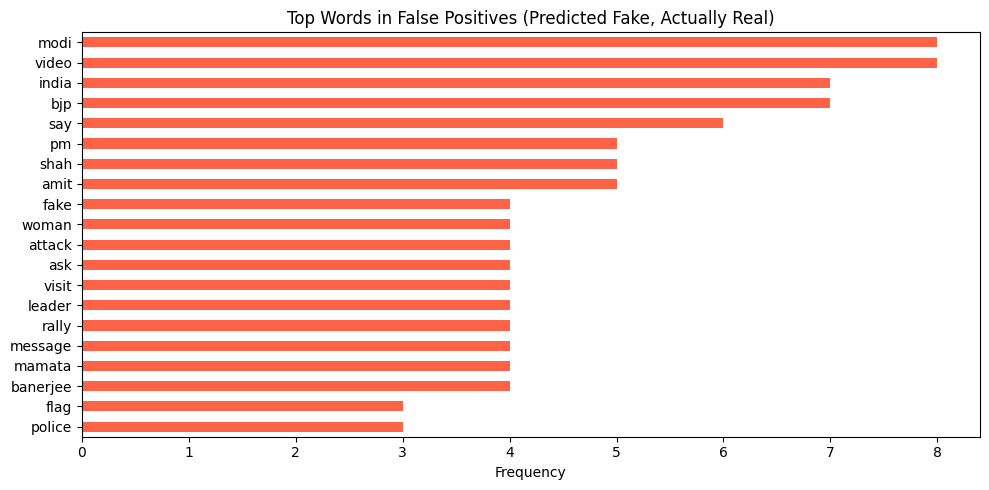

📊 Saved: rf_fp_words.png


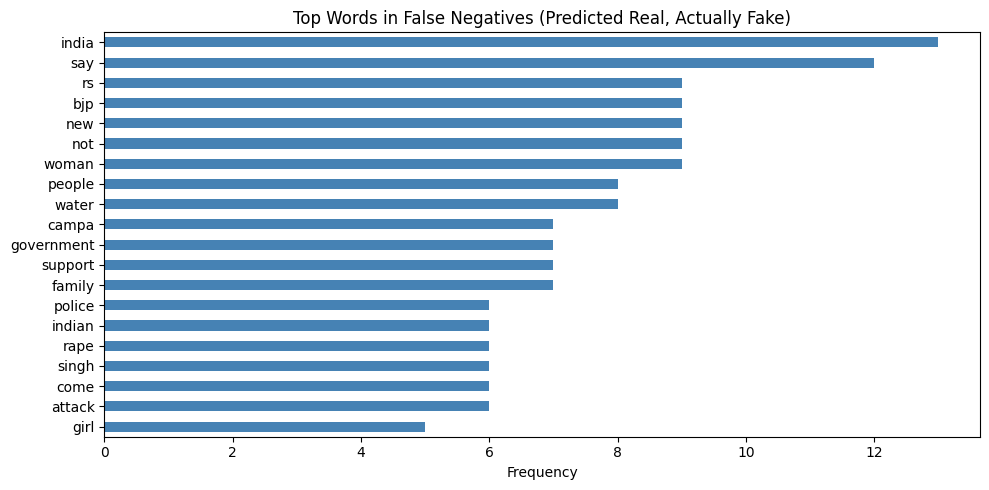

📊 Saved: rf_fn_words.png
🎯 Error inspection with category completed.


In [7]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# -------------------------------
# 📂 Paths
# -------------------------------
DATA_DIR = "models/rf"
RESULT_DIR = f"{DATA_DIR}/results"
ARTIFACT_DIR = f"{DATA_DIR}/artifacts"
VEC_DIR = f"{DATA_DIR}/vectorized"
PLOT_DIR = f"{DATA_DIR}/plots"

os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load model, vectorizer, and test set with category
# -------------------------------
print("📦 Loading model and test data...")
model = joblib.load(f"{ARTIFACT_DIR}/rf_best_model_bigrams.pkl")
vec = joblib.load(f"{VEC_DIR}/vectorizer_bigram.pkl")
test_df = pd.read_csv(f"{VEC_DIR}/test.csv").dropna(subset=["clean_headline", "label_encoded", "category"])

X_text = test_df["clean_headline"].astype(str)
y_true = test_df["label_encoded"]
categories = test_df["category"]
X_vec = vec.transform(X_text)
y_pred = model.predict(X_vec)

# -------------------------------
# 💾 Save full prediction report with category
# -------------------------------
df_pred = pd.DataFrame({
    "clean_headline": X_text,
    "true_label": y_true,
    "prediction": y_pred,
    "category": categories
})
df_pred.to_csv(f"{RESULT_DIR}/rf_test_predictions_full.csv", index=False)
print("✅ Saved: rf_test_predictions_full.csv")

# -------------------------------
# 📉 Identify FP & FN
# -------------------------------
fp = df_pred[(df_pred["true_label"] == 0) & (df_pred["prediction"] == 1)]
fn = df_pred[(df_pred["true_label"] == 1) & (df_pred["prediction"] == 0)]

fp.to_csv(f"{RESULT_DIR}/rf_fp.csv", index=False)
fn.to_csv(f"{RESULT_DIR}/rf_fn.csv", index=False)
print(f"✅ FP: {len(fp)} saved to rf_fp.csv | FN: {len(fn)} saved to rf_fn.csv")

# -------------------------------
# 📊 Word Frequency Plots
# -------------------------------
def plot_word_freq(df, title, outname):
    all_words = " ".join(df["clean_headline"]).lower().split()
    freq = pd.Series(all_words).value_counts()[:20]

    plt.figure(figsize=(10, 5))
    freq[::-1].plot(kind="barh", color="tomato" if "fp" in outname else "steelblue")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.savefig(f"{PLOT_DIR}/{outname}.png", dpi=300)
    plt.show()
    print(f"📊 Saved: {outname}.png")

plot_word_freq(fp, "Top Words in False Positives (Predicted Fake, Actually Real)", "rf_fp_words")
plot_word_freq(fn, "Top Words in False Negatives (Predicted Real, Actually Fake)", "rf_fn_words")

# -------------------------------
# ✅ Done
# -------------------------------
print("🎯 Error inspection with category completed.")

In [8]:
import pandas as pd

# -------------------------------
# 📂 Paths
# -------------------------------
VEC_DIR = "models/rf/vectorized"
FP_PATH = "models/rf/results/rf_fp.csv"
FN_PATH = "models/rf/results/rf_fn.csv"

# -------------------------------
# 📦 Load Full Test Set
# -------------------------------
test_df = pd.read_csv(f"{VEC_DIR}/test.csv").dropna(subset=["clean_headline", "label_encoded"])

# -------------------------------
# 🔍 Load and Inspect Errors
# -------------------------------
fp_df = pd.read_csv(FP_PATH)
fn_df = pd.read_csv(FN_PATH)

# -------------------------------
# 🏷️ Tag Top 5 FP
# -------------------------------
print("\n🔴 Top 5 False Positives (Predicted Fake, Actually Real):")
print(fp_df[["clean_headline", "true_label", "prediction"]].head(5).to_string(index=False))

# -------------------------------
# 🔵 Tag Top 5 False Negatives
# -------------------------------
print("\n🔵 Top 5 False Negatives (Predicted Real, Actually Fake):")
print(fn_df[["clean_headline", "true_label", "prediction"]].head(5).to_string(index=False))


🔴 Top 5 False Positives (Predicted Fake, Actually Real):
                                               clean_headline  true_label  prediction
modi govt merely benefit effort upa congress rana extradition           0           1
                           mamata banerjee mp say unable work           0           1
bsf incite flareup murshidabad west bengal cm mamata banerjee           0           1
 group people force entry temple madhya pradesh thrash priest           0           1
                           ranbir kapoor twitter account fake           0           1

🔵 Top 5 False Negatives (Predicted Real, Actually Fake):
                                                       clean_headline  true_label  prediction
                              badruddin ajmal say assam islamic state           1           0
                                      vikram lander start give signal           1           0
sneak peek global factory phishe website impersonate finance ministry           1     

✅ Saved: rf_per_category_metrics.csv


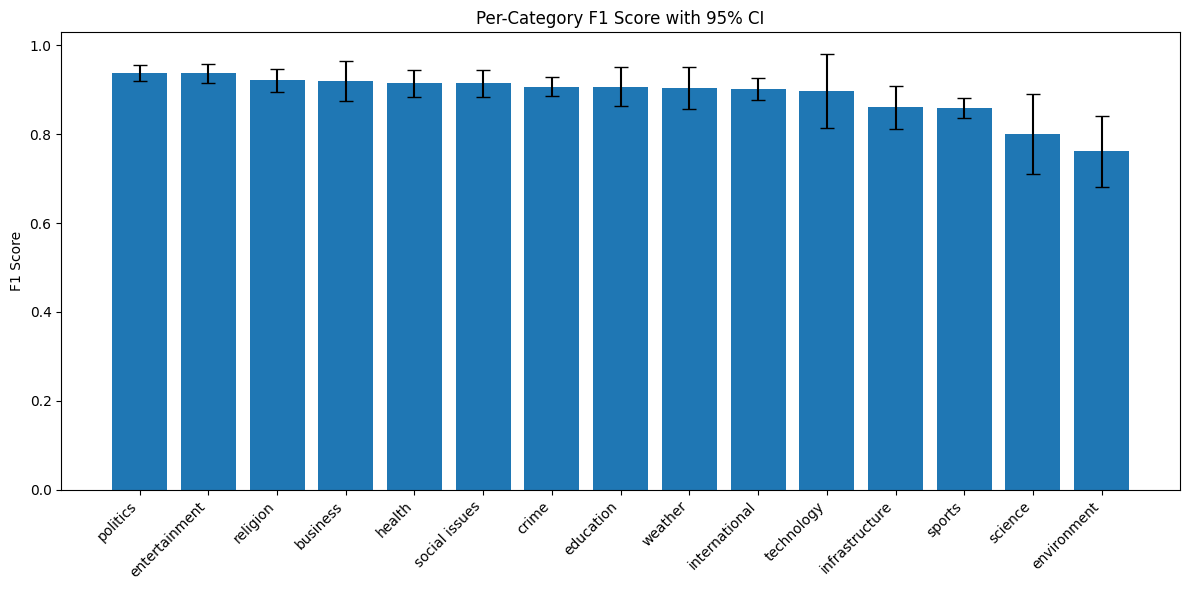

✅ Saved: rf_per_category_f1_ci.png


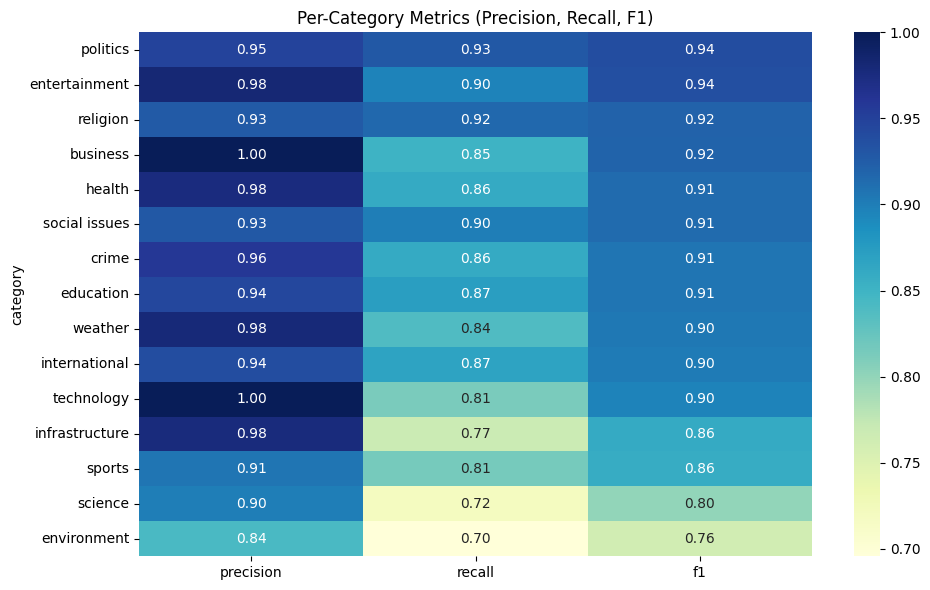

✅ Saved: rf_per_category_metrics_heatmap.png


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4582/541067685.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x="category", y="f1", palette="Blues_d")


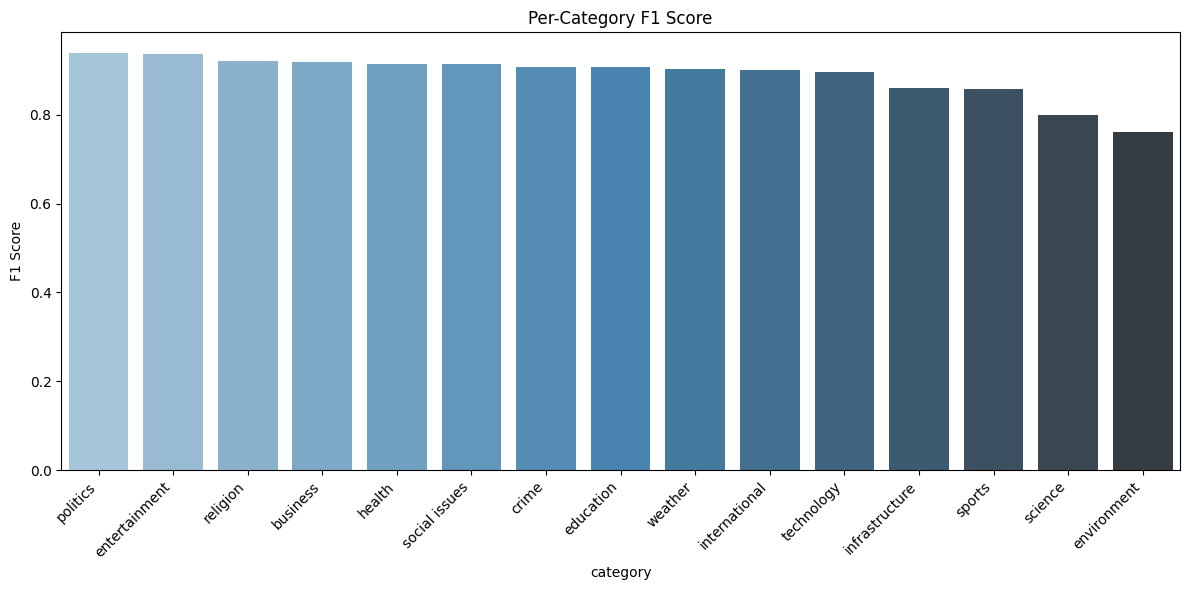

✅ Saved: rf_per_category_metrics_barplot.png


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/rf/results/rf_test_predictions_full.csv"
RESULT_DIR = "models/rf/results"
PLOT_DIR = "models/rf/plots"
os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(PRED_PATH).dropna(subset=["true_label", "prediction", "category"])
df["true_label"] = df["true_label"].astype(int)
df["prediction"] = df["prediction"].astype(int)

# -------------------------------
# 🧮 Compute Per-Category Metrics
# -------------------------------
records = []

for cat in sorted(df["category"].unique()):
    subset = df[df["category"] == cat]
    y_true = subset["true_label"]
    y_pred = subset["prediction"]

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    n = len(subset)

    f1_std = np.sqrt((f1 * (1 - f1)) / max(n, 1))
    ci_95 = 1.96 * f1_std

    records.append({
        "category": cat,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "f1_95ci": ci_95,
        "samples": n
    })

metrics_df = pd.DataFrame(records).sort_values(by="f1", ascending=False)
metrics_df.to_csv(f"{RESULT_DIR}/rf_per_category_metrics.csv", index=False)
print("✅ Saved: rf_per_category_metrics.csv")

# -------------------------------
# 📊 F1 Score Bar Plot with 95% CI
# -------------------------------
plt.figure(figsize=(12, 6))
plt.bar(metrics_df["category"], metrics_df["f1"], yerr=metrics_df["f1_95ci"], capsize=5)
plt.xticks(rotation=45, ha='right')
plt.ylabel("F1 Score")
plt.title("Per-Category F1 Score with 95% CI")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_per_category_f1_ci.png", dpi=300)
plt.show()
print("✅ Saved: rf_per_category_f1_ci.png")

# -------------------------------
# 📊 Heatmap of Precision, Recall, F1
# -------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df.set_index("category")[["precision", "recall", "f1"]],
            annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Per-Category Metrics (Precision, Recall, F1)")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_per_category_metrics_heatmap.png", dpi=300)
plt.show()
print("✅ Saved: rf_per_category_metrics_heatmap.png")

# -------------------------------
# 📊 Plain F1 Score Bar Plot (no CI)
# -------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x="category", y="f1", palette="Blues_d")
plt.xticks(rotation=45, ha='right')
plt.ylabel("F1 Score")
plt.title("Per-Category F1 Score")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_per_category_metrics_barplot.png", dpi=300)
plt.show()
print("✅ Saved: rf_per_category_metrics_barplot.png")

✅ Saved: rf_error_by_category.csv


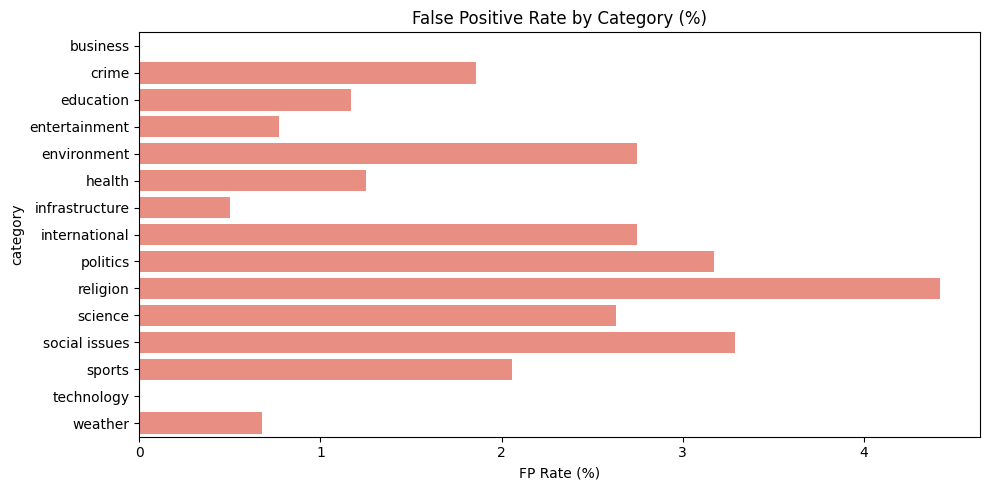

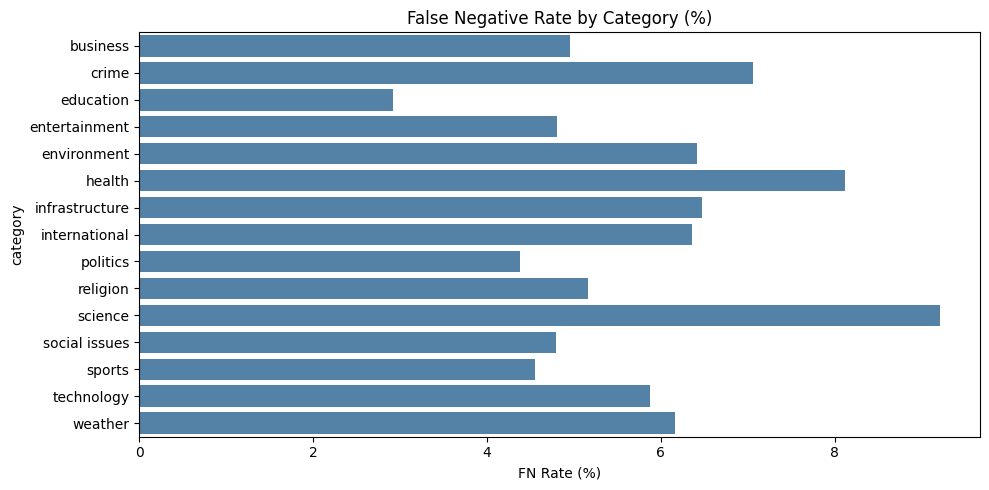

📊 Saved: rf_fp_by_category.png, rf_fn_by_category.png
✅ Saved: rf_top_errors_by_category.csv (Top 3 FP/FN headlines per category)


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/rf/results/rf_test_predictions_full.csv"
PLOT_DIR = "models/rf/plots"
RESULT_DIR = "models/rf/results"
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(PRED_PATH).dropna(subset=["clean_headline", "true_label", "prediction", "category"])

# -------------------------------
# 🟢 Total counts per category
# -------------------------------
cat_counts = df["category"].value_counts().sort_index()

# -------------------------------
# 🔍 Identify FPs and FNs
# -------------------------------
fp = df[(df["true_label"] == 0) & (df["prediction"] == 1)]
fn = df[(df["true_label"] == 1) & (df["prediction"] == 0)]

# -------------------------------
# 📊 Count FP/FN per category
# -------------------------------
fp_counts = fp["category"].value_counts().sort_index()
fn_counts = fn["category"].value_counts().sort_index()

# Fill missing categories
fp_counts = fp_counts.reindex(cat_counts.index, fill_value=0)
fn_counts = fn_counts.reindex(cat_counts.index, fill_value=0)

# -------------------------------
# 📉 Normalize (Error Rate %)
# -------------------------------
fp_rate = (fp_counts / cat_counts * 100).round(2)
fn_rate = (fn_counts / cat_counts * 100).round(2)

# -------------------------------
# 💾 Save CSVs
# -------------------------------
err_df = pd.DataFrame({
    "category": cat_counts.index,
    "total_samples": cat_counts.values,
    "false_positives": fp_counts.values,
    "false_negatives": fn_counts.values,
    "fp_rate(%)": fp_rate.values,
    "fn_rate(%)": fn_rate.values,
})
err_df.to_csv(f"{RESULT_DIR}/rf_error_by_category.csv", index=False)
print("✅ Saved: rf_error_by_category.csv")

# -------------------------------
# 📊 FP RATE %
# -------------------------------
plt.figure(figsize=(10, 5))
sns.barplot(x=fp_rate.values, y=fp_rate.index, color="salmon")
plt.title("False Positive Rate by Category (%)")
plt.xlabel("FP Rate (%)")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_fp_by_category.png", dpi=300)
plt.show()

# -------------------------------
# 📊 FN RATE %
# -------------------------------
plt.figure(figsize=(10, 5))
sns.barplot(x=fn_rate.values, y=fn_rate.index, color="steelblue")
plt.title("False Negative Rate by Category (%)")
plt.xlabel("FN Rate (%)")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_fn_by_category.png", dpi=300)
plt.show()

print("📊 Saved: rf_fp_by_category.png, rf_fn_by_category.png")

# -------------------------------
# 📝 Save Top 3 FP/FN Headlines Per Category
# -------------------------------
def save_top_examples(df_error, label_type, n=3):
    top_examples = []
    for cat in cat_counts.index:
        subset = df_error[df_error["category"] == cat].head(n)
        for _, row in subset.iterrows():
            top_examples.append({
                "category": cat,
                "label_type": label_type,
                "headline": row["clean_headline"]
            })
    return top_examples

top_fp = save_top_examples(fp, "FP")
top_fn = save_top_examples(fn, "FN")

top_df = pd.DataFrame(top_fp + top_fn)
top_df.to_csv(f"{RESULT_DIR}/rf_top_errors_by_category.csv", index=False)
print("✅ Saved: rf_top_errors_by_category.csv (Top 3 FP/FN headlines per category)")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4582/2038913145.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="category", y="fp_rate(%)", palette="Reds_r")


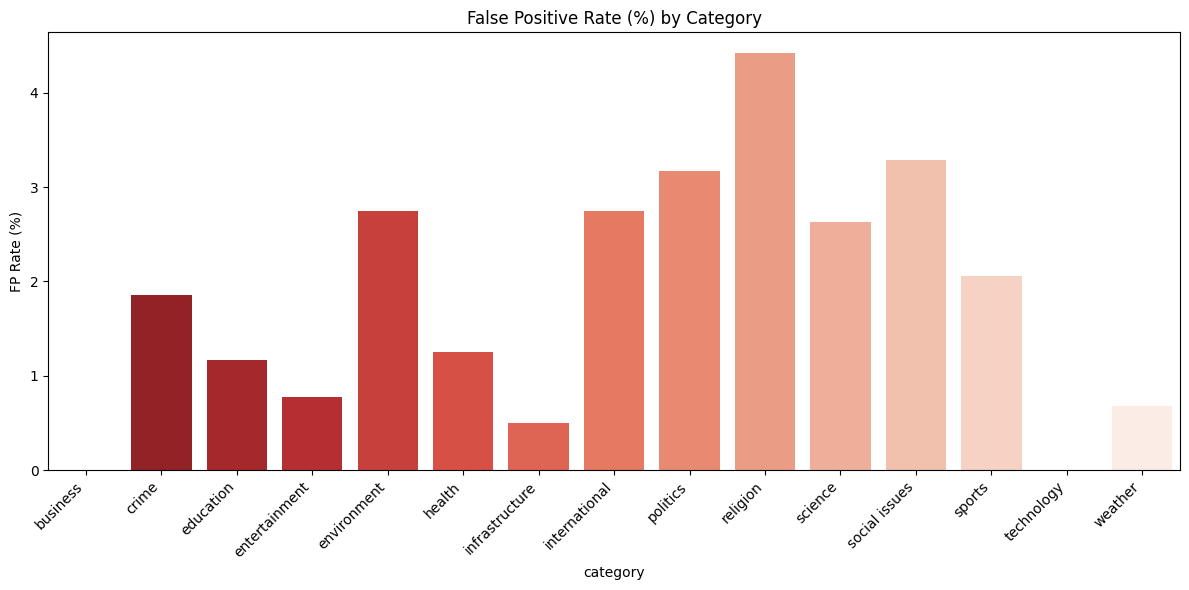

✅ Saved: rf_fp_rate_by_category.png


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4582/2038913145.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="category", y="fn_rate(%)", palette="Blues_r")


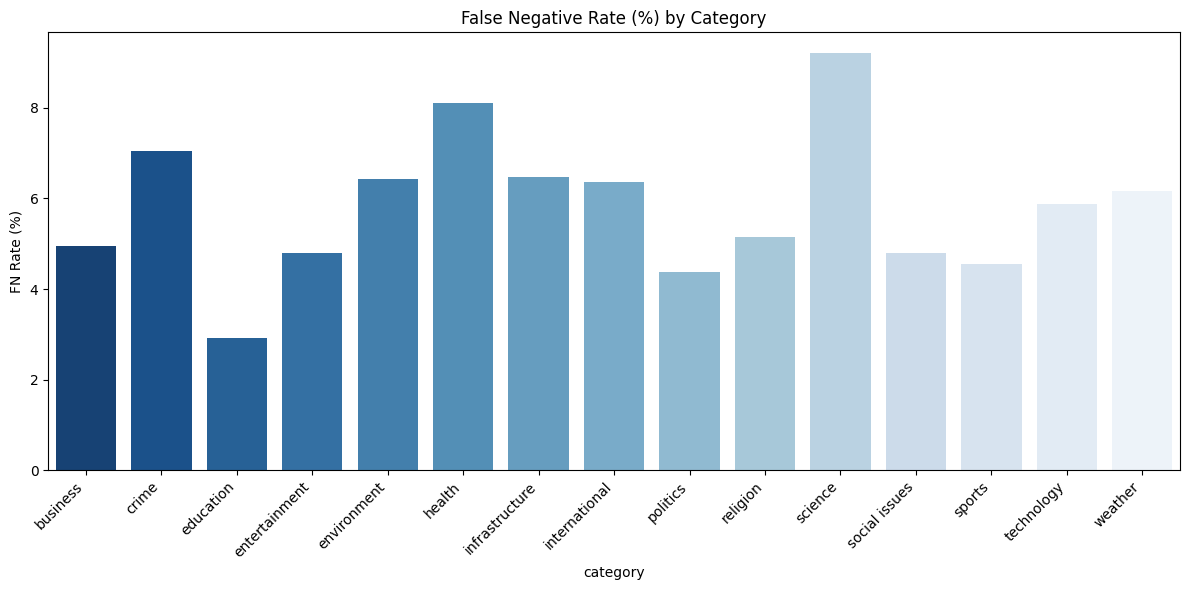

✅ Saved: rf_fn_rate_by_category.png


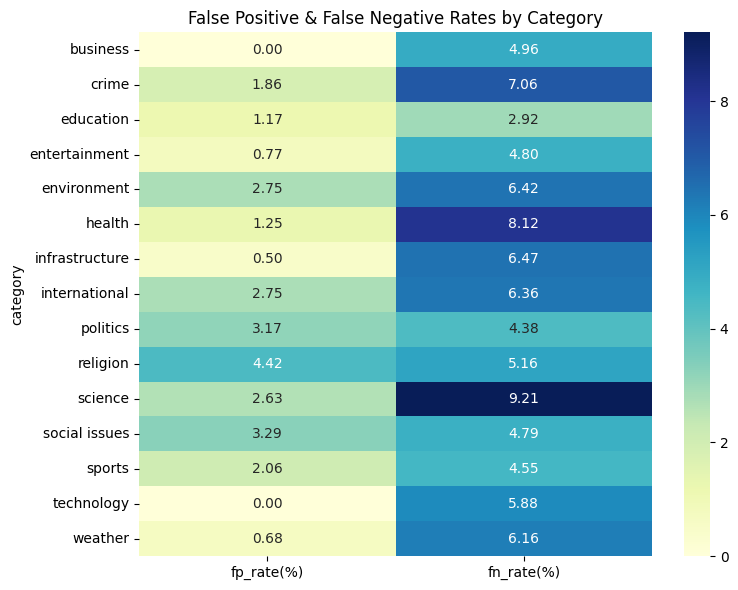

✅ Saved: rf_error_rates_heatmap.png


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------
# 📂 Paths
# -------------------------------
CSV_PATH = "models/rf/results/rf_error_by_category.csv"
PLOT_DIR = "models/rf/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load CSV
# -------------------------------
df = pd.read_csv(CSV_PATH)

# -------------------------------
# 📊 FP Rate Barplot
# -------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="category", y="fp_rate(%)", palette="Reds_r")
plt.title("False Positive Rate (%) by Category")
plt.xticks(rotation=45, ha="right")
plt.ylabel("FP Rate (%)")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_fp_rate_by_category.png", dpi=300)
plt.show()
print("✅ Saved: rf_fp_rate_by_category.png")

# -------------------------------
# 📊 FN Rate Barplot
# -------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="category", y="fn_rate(%)", palette="Blues_r")
plt.title("False Negative Rate (%) by Category")
plt.xticks(rotation=45, ha="right")
plt.ylabel("FN Rate (%)")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_fn_rate_by_category.png", dpi=300)
plt.show()
print("✅ Saved: rf_fn_rate_by_category.png")

# -------------------------------
# 📊 Combined FP + FN Heatmap (optional)
# -------------------------------
plt.figure(figsize=(8, 6))
heatmap_df = df.set_index("category")[["fp_rate(%)", "fn_rate(%)"]]
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("False Positive & False Negative Rates by Category")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_error_rates_heatmap.png", dpi=300)
plt.show()
print("✅ Saved: rf_error_rates_heatmap.png")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4582/3978551648.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fairness.reset_index(), x="category", y="accuracy", palette="viridis")


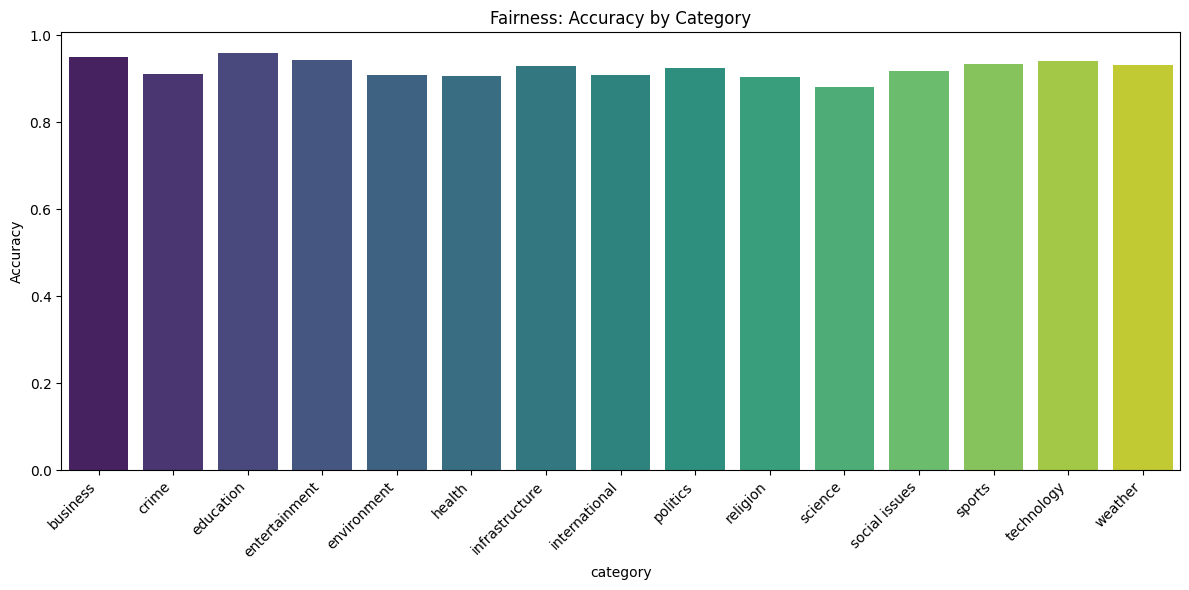

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4582/3978551648.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_group = df.groupby("length_bucket")["is_correct"].agg(["count", "sum"])


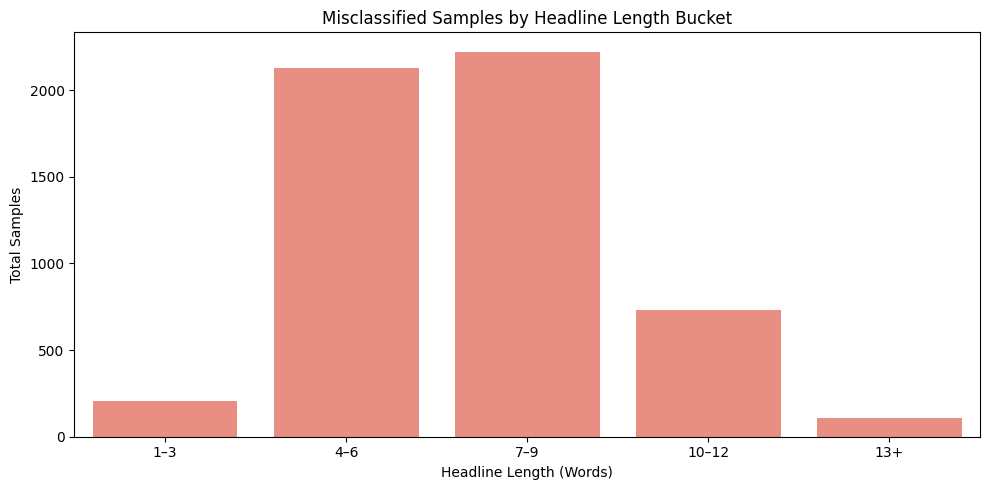

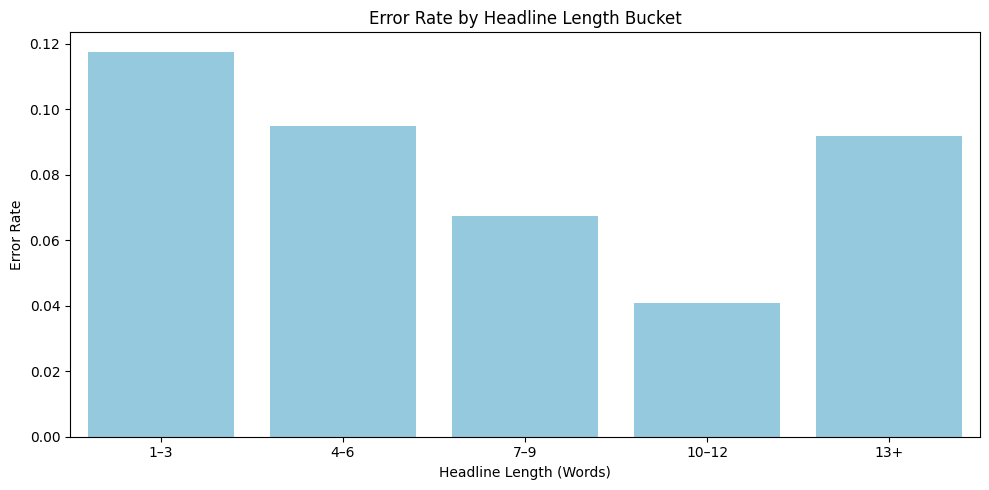

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/rf/results/rf_test_predictions_full.csv"
RESULT_DIR = "models/rf/results"
PLOT_DIR = "models/rf/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
df = pd.read_csv(PRED_PATH).dropna(subset=["clean_headline", "true_label", "prediction", "category"])
df["is_correct"] = df["true_label"] == df["prediction"]

# -------------------------------
# ⚖️ Fairness Analysis
# -------------------------------
fairness = df.groupby("category")["is_correct"].agg(["count", "sum"])
fairness["accuracy"] = fairness["sum"] / fairness["count"]
fairness = fairness.rename(columns={"count": "total", "sum": "correct"})
fairness.to_csv(f"{RESULT_DIR}/rf_fairness_metrics.csv")

# 📊 Fairness Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=fairness.reset_index(), x="category", y="accuracy", palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Fairness: Accuracy by Category")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_fairness_barplot.png", dpi=300)
plt.show()

# -------------------------------
# 🧠 Headline Length Bucketing
# -------------------------------
df["length"] = df["clean_headline"].apply(lambda x: len(str(x).split()))
bins = [0, 3, 6, 9, 12, 100]
labels = ["1–3", "4–6", "7–9", "10–12", "13+"]
df["length_bucket"] = pd.cut(df["length"], bins=bins, labels=labels, right=True)

length_group = df.groupby("length_bucket")["is_correct"].agg(["count", "sum"])
length_group["error_rate"] = 1 - (length_group["sum"] / length_group["count"])

# 📊 Plot 1: Misclassification Count
plt.figure(figsize=(10, 5))
sns.barplot(data=length_group.reset_index(), x="length_bucket", y="count", color="salmon")
plt.title("Misclassified Samples by Headline Length Bucket")
plt.xlabel("Headline Length (Words)")
plt.ylabel("Total Samples")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_headline_length_misclassification.png", dpi=300)
plt.show()

# 📊 Plot 2: Error Rate by Length Bucket
plt.figure(figsize=(10, 5))
sns.barplot(data=length_group.reset_index(), x="length_bucket", y="error_rate", color="skyblue")
plt.title("Error Rate by Headline Length Bucket")
plt.xlabel("Headline Length (Words)")
plt.ylabel("Error Rate")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/rf_length_bucket_error_rate.png", dpi=300)
plt.show()

In [15]:
import os
import pandas as pd
import joblib
from lime.lime_text import LimeTextExplainer
import numpy as np

# -------------------------------
# 📂 Paths
# -------------------------------
MODEL_PATH = "models/rf/artifacts/rf_best_model_bigrams.pkl"
VEC_PATH = "models/rf/vectorized/vectorizer_bigram.pkl"  # or use BiChar manually if combined
DATA_PATH = "models/rf/results/rf_test_predictions_full.csv"
SAVE_DIR = "models/rf/lime"
os.makedirs(SAVE_DIR, exist_ok=True)

# -------------------------------
# 📦 Load model, vectorizer, and data
# -------------------------------
model = joblib.load(MODEL_PATH)
vectorizer = joblib.load(VEC_PATH)
df = pd.read_csv(DATA_PATH)

# -------------------------------
# 🔍 Identify samples
# -------------------------------
fp = df[(df["true_label"] == 0) & (df["prediction"] == 1)].head(5)
fn = df[(df["true_label"] == 1) & (df["prediction"] == 0)].head(5)
correct = df[df["true_label"] == df["prediction"]].sample(1, random_state=42)

# -------------------------------
# 🧠 LIME Setup
# -------------------------------
class_names = ["Real", "Fake"]
explainer = LimeTextExplainer(class_names=class_names)

def predict_proba(texts):
    X_vec = vectorizer.transform(texts)
    return model.predict_proba(X_vec)

# -------------------------------
# 💾 Run LIME for all types
# -------------------------------
def explain_and_save(row, idx, typ):
    text = row["clean_headline"]
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    filename = f"{SAVE_DIR}/lime_rf_{typ}_{idx}.html"
    exp.save_to_file(filename)
    print(f"✅ Saved: {filename}")

# FP
for i, row in fp.iterrows():
    explain_and_save(row, i, "fp")

# FN
for i, row in fn.iterrows():
    explain_and_save(row, i, "fn")

# Correct
for i, row in correct.iterrows():
    explain_and_save(row, i, "correct")

✅ Saved: models/rf/lime/lime_rf_fp_40.html
✅ Saved: models/rf/lime/lime_rf_fp_76.html
✅ Saved: models/rf/lime/lime_rf_fp_133.html
✅ Saved: models/rf/lime/lime_rf_fp_147.html
✅ Saved: models/rf/lime/lime_rf_fp_170.html
✅ Saved: models/rf/lime/lime_rf_fn_8.html
✅ Saved: models/rf/lime/lime_rf_fn_46.html
✅ Saved: models/rf/lime/lime_rf_fn_47.html
✅ Saved: models/rf/lime/lime_rf_fn_55.html
✅ Saved: models/rf/lime/lime_rf_fn_202.html
✅ Saved: models/rf/lime/lime_rf_correct_4345.html


🔁 Drop Top Features: 100%|███████████████████████████████████████████| 3/3 [00:55<00:00, 18.49s/it]


✅ Saved: rf_feature_ablation.csv


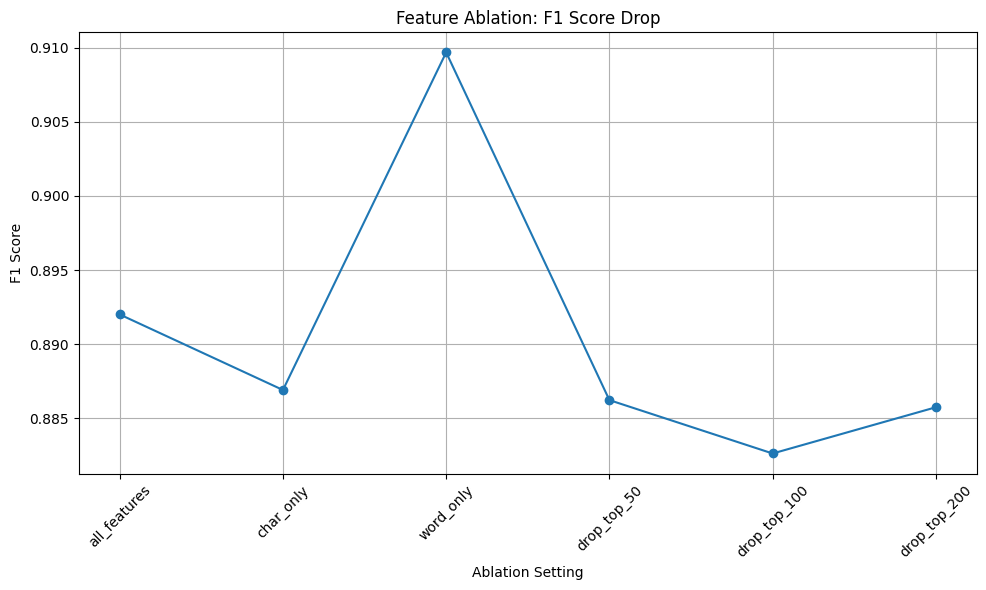

✅ Saved: rf_ablation_curve.png


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from scipy.sparse import hstack
import joblib

# -------------------------------
# 📁 Paths
# -------------------------------
DATA_DIR = "models/rf"
VEC_DIR = f"{DATA_DIR}/vectorized"
ARTIFACT_DIR = f"{DATA_DIR}/artifacts"
RESULT_DIR = f"{DATA_DIR}/results"
PLOT_DIR = f"{DATA_DIR}/plots"
os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
train_df = pd.read_csv(f"{VEC_DIR}/train.csv").dropna()
test_df = pd.read_csv(f"{VEC_DIR}/test.csv").dropna()
X_train_text, y_train = train_df["clean_headline"], train_df["label_encoded"]
X_test_text = test_df["clean_headline"]
y_test = test_df["label_encoded"]

# -------------------------------
# 🔠 Load vectorizers
# -------------------------------
vec_word = joblib.load(f"{VEC_DIR}/vectorizer_bigram.pkl")
vec_char = joblib.load(f"{VEC_DIR}/vectorizer_char.pkl")

X_train_word = vec_word.transform(X_train_text)
X_test_word = vec_word.transform(X_test_text)
X_train_char = vec_char.transform(X_train_text)
X_test_char = vec_char.transform(X_test_text)

X_train_full = hstack([X_train_word, X_train_char])
X_test_full = hstack([X_test_word, X_test_char])
feature_names_full = np.concatenate([vec_word.get_feature_names_out(), vec_char.get_feature_names_out()])

# -------------------------------
# 🧠 Load Best RF Params
# -------------------------------
def safe_parse(val):
    if pd.isna(val): return None
    if str(val) == "None": return None
    if str(val) == "True": return True
    if str(val) == "False": return False
    return val

summary_df = pd.read_csv(f"{RESULT_DIR}/rf_summary.csv").dropna(subset=["F1"])
best_row = summary_df.loc[summary_df["F1"].idxmax()]
best_params = {
    k: safe_parse(best_row[k]) for k in [
        "n_estimators", "max_depth", "min_samples_split",
        "min_samples_leaf", "max_features", "class_weight",
        "bootstrap", "oob_score"
    ]
}
best_params.update({"random_state": 42, "n_jobs": -1})

# -------------------------------
# 🔬 Feature Ablation
# -------------------------------
ablations = []

# ✅ Baseline: All features
clf = RandomForestClassifier(**best_params)
clf.fit(X_train_full, y_train)
y_pred = clf.predict(X_test_full)
ablations.append({"setting": "all_features", "f1": f1_score(y_test, y_pred)})

# ✅ Char-only
clf.fit(X_train_char, y_train)
y_pred = clf.predict(X_test_char)
ablations.append({"setting": "char_only", "f1": f1_score(y_test, y_pred)})

# ✅ Word-only
clf.fit(X_train_word, y_train)
y_pred = clf.predict(X_test_word)
ablations.append({"setting": "word_only", "f1": f1_score(y_test, y_pred)})

# ✅ Drop Top-N Features from Full (sparse-safe)
clf.fit(X_train_full, y_train)
importances = clf.feature_importances_

for drop_n in tqdm([50, 100, 200], desc="🔁 Drop Top Features", ncols=100):
    top_idx = np.argsort(importances)[::-1][:drop_n]
    keep_idx = np.setdiff1d(np.arange(X_train_full.shape[1]), top_idx)

    X_train_dropped = X_train_full[:, keep_idx]
    X_test_dropped = X_test_full[:, keep_idx]

    clf.fit(X_train_dropped, y_train)
    y_pred = clf.predict(X_test_dropped)

    ablations.append({
        "setting": f"drop_top_{drop_n}",
        "f1": f1_score(y_test, y_pred)
    })

# -------------------------------
# 💾 Save Results
# -------------------------------
df_abl = pd.DataFrame(ablations)
df_abl.to_csv(f"{RESULT_DIR}/rf_feature_ablation.csv", index=False)
print("✅ Saved: rf_feature_ablation.csv")

# -------------------------------
# 📈 Plot Ablation Curve
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_abl["setting"], df_abl["f1"], marker='o', linestyle='-')
plt.title("Feature Ablation: F1 Score Drop")
plt.ylabel("F1 Score")
plt.xlabel("Ablation Setting")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.savefig(f"{PLOT_DIR}/rf_ablation_curve.png", dpi=300)
plt.show()
print("✅ Saved: rf_ablation_curve.png")


🔍 Evaluating: Naive Bayes

🔍 Evaluating: Decision Tree

🔍 Evaluating: SVM

🔍 Evaluating: Random Forest

🔍 Evaluating: Logistic Regression

✅ Saved: models/results/nb_dt_svm_rf_lr_comparison.csv


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1931/1799673462.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1931/1799673462.py:106: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(PLOT_PATH, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


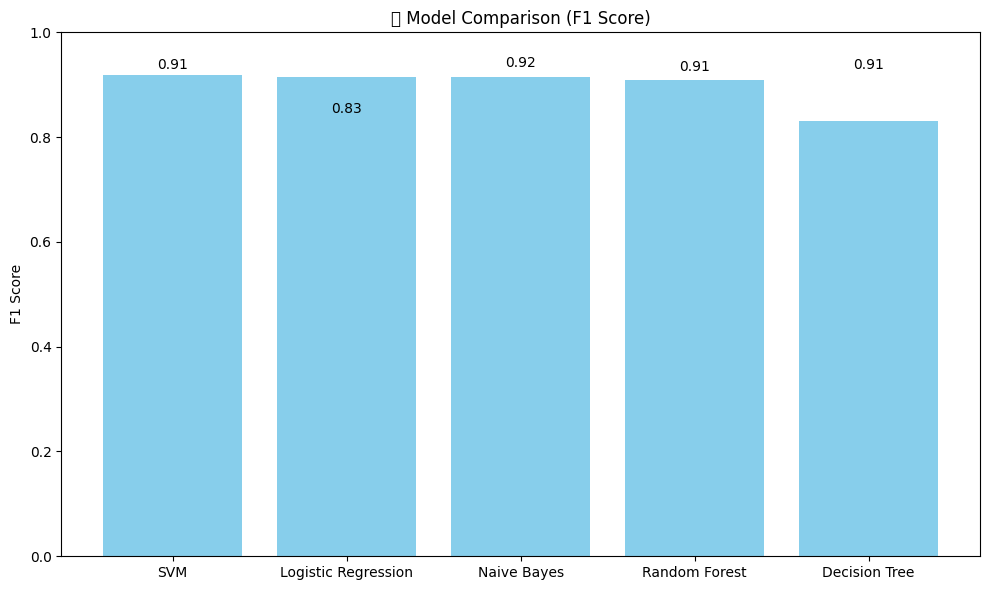

✅ Saved: models/plots/nb_dt_svm_rf_lr_comparison.png


In [4]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
DATA_PATH = "data/processed_test.csv"
RESULT_CSV = "models/results/nb_dt_svm_rf_lr_comparison.csv"
PLOT_PATH = "models/plots/nb_dt_svm_rf_lr_comparison.png"

# -------------------------------
# 🔧 Model Registry
# -------------------------------
model_info = {
    "Naive Bayes": {
        "model": "models/results/classical_models_tuned/artifacts/nb_best_model.pkl",
        "vec":  "models/results/classical_models_tuned/artifacts/nb_vectorizer_bigrams.pkl"
    },
    "Decision Tree": {
        "model": "models/results/classical_models_tuned/artifacts/dt_best_model.pkl",
        "vec":  "models/results/classical_models_tuned/artifacts/dt_vectorizer_bigrams.pkl"
    },
    "SVM": {
        "model": "models/svm/artifacts/best_model.pkl",
        "vec_word": "models/svm/artifacts/word_vectorizer.pkl",
        "vec_char": "models/svm/artifacts/char_vectorizer.pkl"
    },
    "Random Forest": {
        "model": "models/rf/artifacts/rf_best_model_bigrams.pkl",
        "vec":  "models/rf/vectorized/vectorizer_bigram.pkl"
    },
    "Logistic Regression": {
        "model": "models/lr/artifacts/lr_best_model.pkl",
        "vec":  "models/lr/artifacts/lr_best_vectorizer.pkl"
    }
}

# -------------------------------
# 📦 Load Test Data
# -------------------------------
df = pd.read_csv(DATA_PATH).dropna(subset=["clean_headline", "label_encoded"])
X_test = df["clean_headline"].astype(str)
y_test = df["label_encoded"]

# -------------------------------
# 🔁 Evaluate All Models
# -------------------------------
records = []

for name, paths in model_info.items():
    print(f"\n🔍 Evaluating: {name}")
    model = joblib.load(paths["model"])

    # Handle BiChar (SVM) case
    if "vec_word" in paths and "vec_char" in paths:
        vec_word = joblib.load(paths["vec_word"])
        vec_char = joblib.load(paths["vec_char"])
        X_test_vec = hstack([
            vec_word.transform(X_test),
            vec_char.transform(X_test)
        ])
    else:
        vec = joblib.load(paths["vec"])
        X_test_vec = vec.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_vec)
    try:
        y_prob = model.predict_proba(X_test_vec)[:, 1]
    except:
        y_prob = model.decision_function(X_test_vec)

    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    records.append({
        "Model": name,
        "F1": round(f1, 4),
        "AUC": round(auc, 4)
    })

# -------------------------------
# 💾 Save Results
# -------------------------------
df_comp = pd.DataFrame(records).sort_values(by="F1", ascending=False)
df_comp.to_csv(RESULT_CSV, index=False)
print(f"\n✅ Saved: {RESULT_CSV}")

# -------------------------------
# 📈 Plot F1 Score Comparison
# -------------------------------
plt.figure(figsize=(10, 6))
bar = plt.bar(df_comp["Model"], df_comp["F1"], color="skyblue", label="F1 Score")
for idx, row in df_comp.iterrows():
    plt.text(idx, row["F1"] + 0.01, f"{row['F1']:.2f}", ha="center", va="bottom", fontsize=10)

plt.title("📊 Model Comparison (F1 Score)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()

print(f"✅ Saved: {PLOT_PATH}")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1931/4206202452.py:23: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1931/4206202452.py:24: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.savefig(PLOT_PATH, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


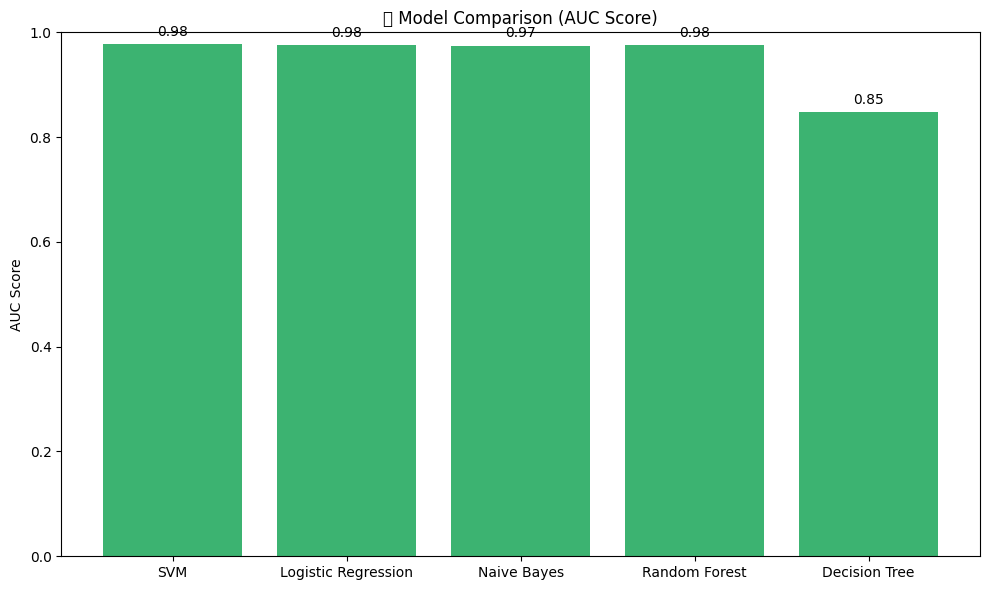

✅ Saved: models/plots/nb_dt_svm_rf_lr_auc_comparison.png


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 📂 Load Results
# -------------------------------
CSV_PATH = "models/results/nb_dt_svm_rf_lr_comparison.csv"
PLOT_PATH = "models/plots/nb_dt_svm_rf_lr_auc_comparison.png"

df = pd.read_csv(CSV_PATH)

# -------------------------------
# 📊 Plot AUC Comparison
# -------------------------------
plt.figure(figsize=(10, 6))
bar = plt.bar(df["Model"], df["AUC"], color="mediumseagreen", label="AUC Score")
for idx, row in df.iterrows():
    plt.text(idx, row["AUC"] + 0.01, f"{row['AUC']:.2f}", ha="center", va="bottom", fontsize=10)
plt.title("🔬 Model Comparison (AUC Score)")
plt.ylabel("AUC Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()
print(f"✅ Saved: {PLOT_PATH}")

In [7]:
import os
import pandas as pd
import joblib
from scipy.sparse import hstack

from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# -------------------------------
# 📂 Paths
# -------------------------------
DATA_PATH = "data/processed_test.csv"
SAVE_PATH = "models/results/model_predictions.csv"
os.makedirs("models/results", exist_ok=True)

# -------------------------------
# 📦 Load Test Data
# -------------------------------
df = pd.read_csv(DATA_PATH).dropna(subset=["clean_headline", "label_encoded"])
X_test = df["clean_headline"].astype(str)
y_test = df["label_encoded"].astype(int)

# -------------------------------
# 🔧 Model Registry
# -------------------------------
model_info = {
    "Naive Bayes": {
        "model": "models/results/classical_models_tuned/artifacts/nb_best_model.pkl",
        "vec":  "models/results/classical_models_tuned/artifacts/nb_vectorizer_bigrams.pkl"
    },
    "Decision Tree": {
        "model": "models/results/classical_models_tuned/artifacts/dt_best_model.pkl",
        "vec":  "models/results/classical_models_tuned/artifacts/dt_vectorizer_bigrams.pkl"
    },
    "SVM": {
        "model": "models/svm/artifacts/best_model.pkl",
        "vec_word": "models/svm/artifacts/word_vectorizer.pkl",
        "vec_char": "models/svm/artifacts/char_vectorizer.pkl"
    },
    "Random Forest": {
        "model": "models/rf/artifacts/rf_best_model_bigrams.pkl",
        "vec":  "models/rf/vectorized/vectorizer_bigram.pkl"
    },
    "Logistic Regression": {
        "model": "models/lr/artifacts/lr_best_model.pkl",
        "vec":  "models/lr/artifacts/lr_best_vectorizer.pkl"
    }
}

# -------------------------------
# 🔁 Generate Predictions
# -------------------------------
predictions = {"true": y_test.values}

for name, paths in model_info.items():
    print(f"🔍 Running: {name}")
    model = joblib.load(paths["model"])

    # Handle special case: SVM with BiChar
    if name == "SVM":
        vec_word = joblib.load(paths["vec_word"])
        vec_char = joblib.load(paths["vec_char"])
        X_word = vec_word.transform(X_test)
        X_char = vec_char.transform(X_test)
        X_test_vec = hstack([X_word, X_char])
    else:
        vec = joblib.load(paths["vec"])
        X_test_vec = vec.transform(X_test)

    predictions[name.lower().replace(" ", "_")] = model.predict(X_test_vec)

# -------------------------------
# 💾 Save All Predictions
# -------------------------------
df_preds = pd.DataFrame(predictions)
df_preds.to_csv(SAVE_PATH, index=False)
print(f"✅ Saved: {SAVE_PATH}")

🔍 Running: Naive Bayes
🔍 Running: Decision Tree
🔍 Running: SVM
🔍 Running: Random Forest
🔍 Running: Logistic Regression
✅ Saved: models/results/model_predictions.csv


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1931/3929938068.py:34: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1931/3929938068.py:35: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig("models/plots/error_overlap_heatmap.png", dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


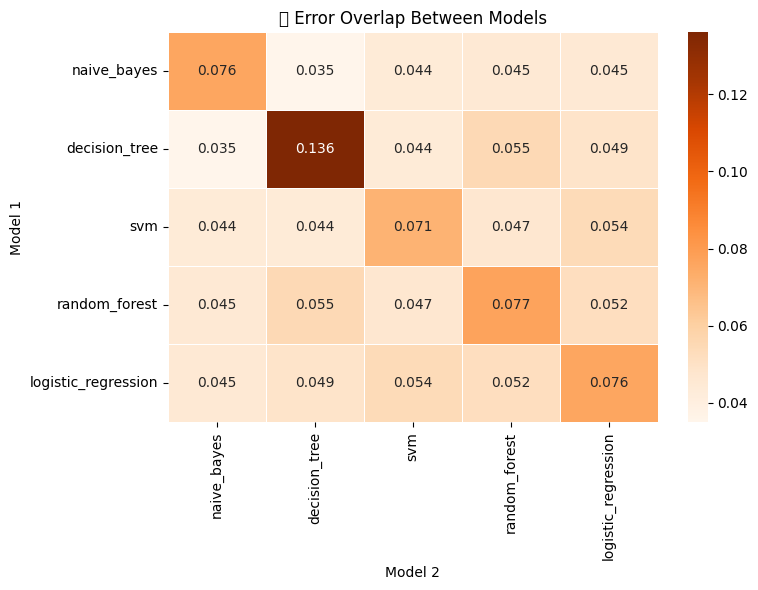

✅ Saved: models/plots/error_overlap_heatmap.png


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 📥 Load Predictions
# -------------------------------
df = pd.read_csv("models/results/model_predictions.csv")
true_col = "true"

# Correct column names as per your CSV
models = ["naive_bayes", "decision_tree", "svm", "random_forest", "logistic_regression"]

# -------------------------------
# 🔁 Error Overlap Matrix
# -------------------------------
error_overlap = pd.DataFrame(index=models, columns=models, dtype=float)

for m1 in models:
    for m2 in models:
        m1_wrong = df[m1] != df[true_col]
        m2_wrong = df[m2] != df[true_col]
        overlap = (m1_wrong & m2_wrong).sum()
        error_overlap.loc[m1, m2] = round(overlap / len(df), 3)

# -------------------------------
# 📊 Plot Heatmap
# -------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(error_overlap, annot=True, fmt=".3f", cmap="Oranges", linewidths=0.5)
plt.title("🔁 Error Overlap Between Models")
plt.xlabel("Model 2")
plt.ylabel("Model 1")
plt.tight_layout()
plt.savefig("models/plots/error_overlap_heatmap.png", dpi=300)
plt.show()

print("✅ Saved: models/plots/error_overlap_heatmap.png")

✅ Saved: models/results/mcnemar_test_results.csv


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1931/2876649881.py:56: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1931/2876649881.py:57: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("models/plots/mcnemar_test_heatmap.png", dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


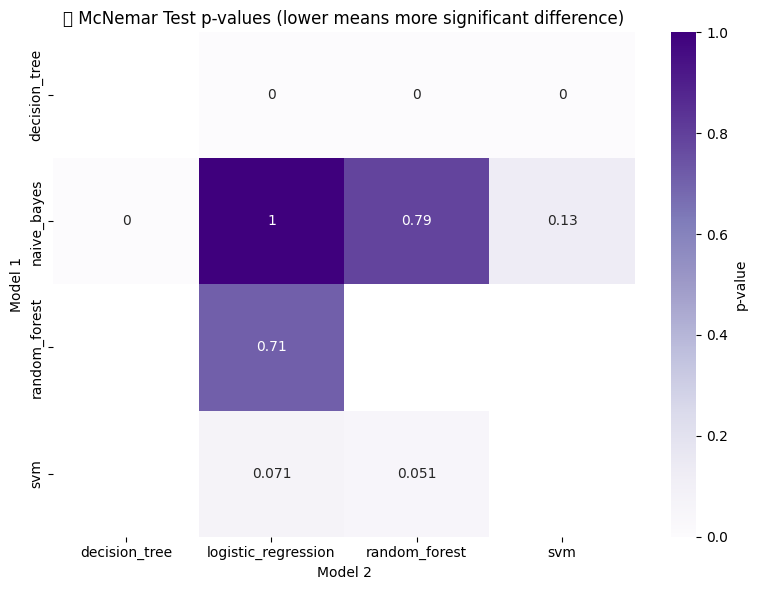

✅ Saved: models/plots/mcnemar_test_heatmap.png


In [12]:
import os
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 📂 Load Model Predictions
# -------------------------------
df = pd.read_csv("models/results/model_predictions.csv")
models = [col for col in df.columns if col != "true"]

# -------------------------------
# 📊 McNemar Test for All Pairs
# -------------------------------
results = []

for model1, model2 in combinations(models, 2):
    correct1 = df[model1] == df["true"]
    correct2 = df[model2] == df["true"]

    # McNemar's contingency table
    both_correct = (correct1 & correct2).sum()
    only_1_correct = (correct1 & ~correct2).sum()
    only_2_correct = (~correct1 & correct2).sum()
    both_wrong = (~correct1 & ~correct2).sum()

    table = [[both_correct, only_1_correct],
             [only_2_correct, both_wrong]]

    result = mcnemar(table, exact=False, correction=True)

    results.append({
        "Model 1": model1,
        "Model 2": model2,
        "Statistic": round(result.statistic, 4),
        "p-value": round(result.pvalue, 6),
        "Significant (p < 0.05)": result.pvalue < 0.05
    })

# -------------------------------
# 💾 Save Results
# -------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv("models/results/mcnemar_test_results.csv", index=False)
print("✅ Saved: models/results/mcnemar_test_results.csv")

# -------------------------------
# 📈 Heatmap of p-values
# -------------------------------
pivot = df_results.pivot(index="Model 1", columns="Model 2", values="p-value")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap="Purples", cbar_kws={'label': 'p-value'})
plt.title("📊 McNemar Test p-values (lower means more significant difference)")
plt.tight_layout()
plt.savefig("models/plots/mcnemar_test_heatmap.png", dpi=300)
plt.show()
print("✅ Saved: models/plots/mcnemar_test_heatmap.png")

✅ Saved CI matrix: models/results/bootstrap_f1_ci_matrix.csv


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1931/2643497683.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  width_matrix = ci_matrix.applymap(lambda x: eval(x)[1] - eval(x)[0])
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1931/2643497683.py:65: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_1931/2643497683.py:66: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.savefig(OUT_PLOT, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


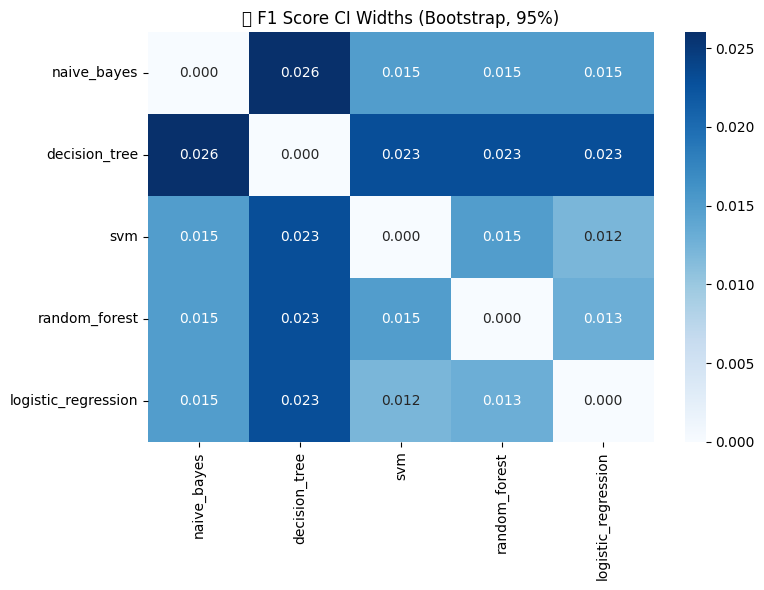

✅ Saved: models/plots/bootstrap_f1_ci_heatmap.png


In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from itertools import combinations
import os

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_CSV = "models/results/model_predictions.csv"
OUT_CSV = "models/results/bootstrap_f1_ci_matrix.csv"
OUT_PLOT = "models/plots/bootstrap_f1_ci_heatmap.png"
os.makedirs("models/results", exist_ok=True)
os.makedirs("models/plots", exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
df = pd.read_csv(PRED_CSV)
y_true = df["true"].values
model_cols = [col for col in df.columns if col != "true"]

# -------------------------------
# 🔁 Bootstrap Function
# -------------------------------
def bootstrap_f1(y_true, pred1, pred2, n=1000):
    f1_diff = []
    y_true = np.array(y_true)
    pred1 = np.array(pred1)
    pred2 = np.array(pred2)
    for _ in range(n):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        f1_1 = f1_score(y_true[idx], pred1[idx])
        f1_2 = f1_score(y_true[idx], pred2[idx])
        f1_diff.append(f1_1 - f1_2)
    return np.percentile(f1_diff, [2.5, 97.5])

# -------------------------------
# 📊 Run for All Model Pairs
# -------------------------------
ci_matrix = pd.DataFrame(index=model_cols, columns=model_cols)

for m1, m2 in combinations(model_cols, 2):
    low, high = bootstrap_f1(y_true, df[m1], df[m2])
    ci_matrix.loc[m1, m2] = f"[{low:.3f}, {high:.3f}]"
    ci_matrix.loc[m2, m1] = f"[{-high:.3f}, {-low:.3f}]"  # Reverse difference

np.fill_diagonal(ci_matrix.values, "[0.000, 0.000]")

# -------------------------------
# 💾 Save Table
# -------------------------------
ci_matrix.to_csv(OUT_CSV)
print(f"✅ Saved CI matrix: {OUT_CSV}")

# -------------------------------
# 📈 Optional: Plot Interval Widths
# -------------------------------
width_matrix = ci_matrix.applymap(lambda x: eval(x)[1] - eval(x)[0])
plt.figure(figsize=(8, 6))
sns.heatmap(width_matrix.astype(float), annot=True, cmap="Blues", fmt=".3f")
plt.title("🧪 F1 Score CI Widths (Bootstrap, 95%)")
plt.tight_layout()
plt.savefig(OUT_PLOT, dpi=300)
plt.show()
print(f"✅ Saved: {OUT_PLOT}")

In [15]:
import os
import pandas as pd
import joblib
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# 📂 Paths
MODEL_ARTIFACTS = {
    "naive_bayes": {
        "model": "models/results/classical_models_tuned/artifacts/nb_best_model.pkl",
        "vec": "models/results/classical_models_tuned/artifacts/nb_vectorizer_bigrams.pkl"
    },
    "decision_tree": {
        "model": "models/results/classical_models_tuned/artifacts/dt_best_model.pkl",
        "vec": "models/results/classical_models_tuned/artifacts/dt_vectorizer_bigrams.pkl"
    },
    "random_forest": {
        "model": "models/rf/artifacts/rf_best_model_bigrams.pkl",
        "vec": "models/rf/vectorized/vectorizer_bigram.pkl"
    },
    "logistic_regression": {
        "model": "models/lr/artifacts/lr_best_model.pkl",
        "vec": "models/lr/artifacts/lr_best_vectorizer.pkl"
    },
    "svm": {
        "model": "models/svm/artifacts/best_model.pkl",
        "vec_word": "models/svm/artifacts/word_vectorizer.pkl",
        "vec_char": "models/svm/artifacts/char_vectorizer.pkl"
    }
}

# Load data
train_df = pd.read_csv("data/processed_train.csv").dropna()
test_df = pd.read_csv("data/processed_test.csv").dropna()
X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]
X_test = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"]

results = []

for name, info in MODEL_ARTIFACTS.items():
    print(f"\n🔍 Evaluating {name}")
    model = joblib.load(info["model"])

    if "vec" in info:
        vec = joblib.load(info["vec"])
        X_train_vec = vec.transform(X_train)
        X_test_vec = vec.transform(X_test)
    else:
        # SVM BiChar handling
        vec_word = joblib.load(info["vec_word"])
        vec_char = joblib.load(info["vec_char"])
        X_train_vec = hstack([vec_word.transform(X_train), vec_char.transform(X_train)])
        X_test_vec = hstack([vec_word.transform(X_test), vec_char.transform(X_test)])

    y_train_pred = model.predict(X_train_vec)
    y_test_pred = model.predict(X_test_vec)

    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)

    results.append({
        "model": name,
        "train_f1": round(f1_train, 4),
        "test_f1": round(f1_test, 4),
        "gap": round(f1_train - f1_test, 4)
    })

df_gap = pd.DataFrame(results)
print("\n📊 Train vs Test F1 Summary:")
print(df_gap.sort_values(by="gap", ascending=False))


🔍 Evaluating naive_bayes

🔍 Evaluating decision_tree

🔍 Evaluating random_forest

🔍 Evaluating logistic_regression

🔍 Evaluating svm

📊 Train vs Test F1 Summary:
                 model  train_f1  test_f1     gap
2        random_forest    0.9989   0.9097  0.0892
3  logistic_regression    0.9995   0.9140  0.0855
4                  svm    0.9993   0.9190  0.0803
0          naive_bayes    0.9670   0.9138  0.0531
1        decision_tree    0.8819   0.8303  0.0515


In [6]:
import os
import pandas as pd
import numpy as np
import joblib
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
os.makedirs(CALIB_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
val_df = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline", "label_encoded"])
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])

X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]
X_val = val_df["clean_headline"].astype(str)
y_val = val_df["label_encoded"]
X_test = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"]

# -------------------------------
# 🔠 Vectorizers per model
# -------------------------------

# Naive Bayes 1 → TF-IDF Bigrams
vec_nb1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
X_train_nb1 = vec_nb1.fit_transform(X_train)
X_val_nb1 = vec_nb1.transform(X_val)
X_test_nb1 = vec_nb1.transform(X_test)
joblib.dump(vec_nb1, f"{CALIB_DIR}/nb_vectorizer_bigrams.pkl")

# Naive Bayes 2 → TF-IDF BiChar
vec_word_nb2 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
vec_char_nb2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
X_train_nb2 = hstack([vec_word_nb2.fit_transform(X_train), vec_char_nb2.fit_transform(X_train)])
X_val_nb2 = hstack([vec_word_nb2.transform(X_val), vec_char_nb2.transform(X_val)])
X_test_nb2 = hstack([vec_word_nb2.transform(X_test), vec_char_nb2.transform(X_test)])
joblib.dump(vec_word_nb2, f"{CALIB_DIR}/nb_vectorizer_bichar_word.pkl")
joblib.dump(vec_char_nb2, f"{CALIB_DIR}/nb_vectorizer_bichar_char.pkl")

# Decision Tree 1 → TF-IDF Bigrams
vec_dt1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
X_train_dt1 = vec_dt1.fit_transform(X_train)
X_val_dt1 = vec_dt1.transform(X_val)
X_test_dt1 = vec_dt1.transform(X_test)
joblib.dump(vec_dt1, f"{CALIB_DIR}/dt_vectorizer_bigrams.pkl")

# Decision Tree 2 → TF-IDF Char
vec_dt2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
X_train_dt2 = vec_dt2.fit_transform(X_train)
X_val_dt2 = vec_dt2.transform(X_val)
X_test_dt2 = vec_dt2.transform(X_test)
joblib.dump(vec_dt2, f"{CALIB_DIR}/dt_vectorizer_char.pkl")

# SVM → BiChar
vec_word_svm = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
vec_char_svm = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
X_train_word = vec_word_svm.fit_transform(X_train)
X_train_char = vec_char_svm.fit_transform(X_train)
X_val_word = vec_word_svm.transform(X_val)
X_val_char = vec_char_svm.transform(X_val)
X_test_word = vec_word_svm.transform(X_test)
X_test_char = vec_char_svm.transform(X_test)

X_train_svm = hstack([X_train_word, X_train_char])
X_val_svm = hstack([X_val_word, X_val_char])
X_test_svm = hstack([X_test_word, X_test_char])
joblib.dump(vec_word_svm, f"{CALIB_DIR}/svm_vectorizer_word.pkl")
joblib.dump(vec_char_svm, f"{CALIB_DIR}/svm_vectorizer_char.pkl")

# -------------------------------
# 🧠 Define Models
# -------------------------------
models = {
    "nb1": {
        "model": MultinomialNB(alpha=0.1),
        "X_train": X_train_nb1, "X_val": X_val_nb1, "X_test": X_test_nb1
    },
    "nb2": {
        "model": MultinomialNB(alpha=0.01),
        "X_train": X_train_nb2, "X_val": X_val_nb2, "X_test": X_test_nb2
    },
    "dt1": {
        "model": DecisionTreeClassifier(max_depth=50, min_samples_split=2, criterion="gini", random_state=42),
        "X_train": X_train_dt1, "X_val": X_val_dt1, "X_test": X_test_dt1
    },
    "dt2": {
        "model": DecisionTreeClassifier(max_depth=50, min_samples_split=2, criterion="gini", random_state=42),
        "X_train": X_train_dt2, "X_val": X_val_dt2, "X_test": X_test_dt2
    },
    "svm1": {
        "model": LinearSVC(C=1.0, loss="hinge", max_iter=2000, random_state=42),
        "X_train": X_train_svm, "X_val": X_val_svm, "X_test": X_test_svm
    },
    "svm2": {
        "model": LinearSVC(C=1.0, loss="squared_hinge", max_iter=2000, random_state=42),
        "X_train": X_train_svm, "X_val": X_val_svm, "X_test": X_test_svm
    }
}

# -------------------------------
# 🔁 Train, Calibrate, Evaluate
# -------------------------------
results = []

for name, cfg in models.items():
    print(f"📏 Calibrating {name.upper()} using Train→Val with cv='prefit'...")
    cfg["model"].fit(cfg["X_train"], y_train)
    calibrator = CalibratedClassifierCV(cfg["model"], method="sigmoid", cv="prefit")
    calibrator.fit(cfg["X_val"], y_val)

    joblib.dump(calibrator, f"{CALIB_DIR}/{name}_calibrated.pkl")

    y_pred = calibrator.predict(cfg["X_test"])
    y_prob = calibrator.predict_proba(cfg["X_test"])[:, 1]

    results.append({
        "Model": name.upper(),
        "F1": round(f1_score(y_test, y_pred), 4),
        "AUC": round(roc_auc_score(y_test, y_prob), 4)
    })

# -------------------------------
# 💾 Save Results
# -------------------------------
df_out = pd.DataFrame(results).sort_values("F1", ascending=False)
df_out.to_csv(f"{CALIB_DIR}/calibrated_model_scores.csv", index=False)
print("✅ Calibration complete. Scores saved.")

📏 Calibrating NB1 using Train→Val with cv='prefit'...
📏 Calibrating NB2 using Train→Val with cv='prefit'...
📏 Calibrating DT1 using Train→Val with cv='prefit'...


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


📏 Calibrating DT2 using Train→Val with cv='prefit'...


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


📏 Calibrating SVM1 using Train→Val with cv='prefit'...


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


📏 Calibrating SVM2 using Train→Val with cv='prefit'...
✅ Calibration complete. Scores saved.


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [7]:
import os
import pandas as pd
import joblib
from scipy.sparse import hstack
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
VAL_PATH = "data/processed_val.csv"
TEST_PATH = "data/processed_test.csv"

# -------------------------------
# 📦 Load Data
# -------------------------------
val_df = pd.read_csv(VAL_PATH).dropna(subset=["clean_headline", "label_encoded"])
test_df = pd.read_csv(TEST_PATH).dropna(subset=["clean_headline", "label_encoded"])
X_val = val_df["clean_headline"].astype(str)
y_val = val_df["label_encoded"]
X_test = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"]

# -------------------------------
# 🧠 Model Vectorizer Config
# -------------------------------
model_configs = {
    "nb1": {
        "vec": "nb_vectorizer_bigrams.pkl"
    },
    "nb2": {
        "vec": ["nb_vectorizer_bichar_word.pkl", "nb_vectorizer_bichar_char.pkl"]
    },
    "dt1": {
        "vec": "dt_vectorizer_bigrams.pkl"
    },
    "dt2": {
        "vec": "dt_vectorizer_char.pkl"
    },
    "svm1": {
        "vec": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"]
    },
    "svm2": {
        "vec": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"]
    }
}

# -------------------------------
# 🔍 Evaluate Each Calibrated Model
# -------------------------------
results = []

for model_name, config in model_configs.items():
    print(f"\n🔍 Evaluating {model_name.upper()}...")

    model_path = os.path.join(CALIB_DIR, f"{model_name}_calibrated.pkl")
    model = joblib.load(model_path)

    # Load vectorizers
    if isinstance(config["vec"], list):
        vec1 = joblib.load(os.path.join(CALIB_DIR, config["vec"][0]))
        vec2 = joblib.load(os.path.join(CALIB_DIR, config["vec"][1]))
        X_val_vec = hstack([vec1.transform(X_val), vec2.transform(X_val)])
        X_test_vec = hstack([vec1.transform(X_test), vec2.transform(X_test)])
    else:
        vec = joblib.load(os.path.join(CALIB_DIR, config["vec"]))
        X_val_vec = vec.transform(X_val)
        X_test_vec = vec.transform(X_test)

    # Predict and compute F1
    f1_val = f1_score(y_val, model.predict(X_val_vec))
    f1_test = f1_score(y_test, model.predict(X_test_vec))
    gap = round(f1_val - f1_test, 4)

    results.append({
        "Model": model_name.upper(),
        "F1_Val": round(f1_val, 4),
        "F1_Test": round(f1_test, 4),
        "Gap": gap
    })

# -------------------------------
# 💾 Save Results
# -------------------------------
df_gap = pd.DataFrame(results).sort_values(by="Gap", ascending=False)
df_gap.to_csv(f"{CALIB_DIR}/f1_overfitting_gap.csv", index=False)
print("✅ Saved: f1_overfitting_gap.csv")
print(df_gap.to_string(index=False))


🔍 Evaluating NB1...

🔍 Evaluating NB2...

🔍 Evaluating DT1...

🔍 Evaluating DT2...

🔍 Evaluating SVM1...

🔍 Evaluating SVM2...
✅ Saved: f1_overfitting_gap.csv
Model  F1_Val  F1_Test     Gap
 SVM1  0.9243   0.9184  0.0059
  NB1  0.9183   0.9131  0.0052
 SVM2  0.9227   0.9191  0.0035
  NB2  0.9159   0.9142  0.0017
  DT1  0.8315   0.8303  0.0012
  DT2  0.8242   0.8292 -0.0050


In [8]:
import os
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, roc_auc_score

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
SUMMARY_CSV = "models/rf/results/rf_summary.csv"
os.makedirs(CALIB_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
val_df   = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline", "label_encoded"])
test_df  = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])

X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]
X_val   = val_df["clean_headline"].astype(str)
y_val   = val_df["label_encoded"]
X_test  = test_df["clean_headline"].astype(str)
y_test  = test_df["label_encoded"]

# -------------------------------
# 🔠 Vectorizer (TF-IDF Bigrams)
# -------------------------------
vec = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
X_train_vec = vec.fit_transform(X_train)
X_val_vec   = vec.transform(X_val)
X_test_vec  = vec.transform(X_test)
joblib.dump(vec, f"{CALIB_DIR}/rf_vectorizer.pkl")

# -------------------------------
# 🔍 Load Best RF Hyperparameters
# -------------------------------
def safe_parse(val):
    if pd.isna(val) or val == "None": return None
    if val == "True": return True
    if val == "False": return False
    return val

summary_df = pd.read_csv(SUMMARY_CSV).dropna(subset=["F1"])
best_row = summary_df.loc[summary_df["F1"].idxmax()]

best_params = {
    k: safe_parse(best_row[k]) for k in [
        "n_estimators", "max_depth", "min_samples_split",
        "min_samples_leaf", "max_features", "class_weight",
        "bootstrap", "oob_score"
    ]
}
best_params.update({"random_state": 42, "n_jobs": -1})

# -------------------------------
# 🧠 Train and Calibrate
# -------------------------------
print("📏 Training + Calibrating Random Forest (Train → Val)...")
model = RandomForestClassifier(**best_params)
model.fit(X_train_vec, y_train)

calibrator = CalibratedClassifierCV(model, method="sigmoid", cv="prefit")
calibrator.fit(X_val_vec, y_val)
joblib.dump(calibrator, f"{CALIB_DIR}/rf_calibrated.pkl")

# -------------------------------
# 📊 Evaluate
# -------------------------------
y_pred = calibrator.predict(X_test_vec)
y_prob = calibrator.predict_proba(X_test_vec)[:, 1]
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# -------------------------------
# 💾 Save Scores
# -------------------------------
score_df = pd.DataFrame([{
    "Model": "RF", "F1": round(f1, 4), "AUC": round(auc, 4)
}])
score_df.to_csv(f"{CALIB_DIR}/rf_calibrated_score.csv", index=False)

print("✅ Saved: rf_calibrated.pkl + rf_calibrated_score.csv")

📏 Training + Calibrating Random Forest (Train → Val)...


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


✅ Saved: rf_calibrated.pkl + rf_calibrated_score.csv


In [9]:
import os
import pandas as pd
import joblib
from sklearn.metrics import f1_score

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
MODEL_PATH = f"{CALIB_DIR}/rf_calibrated.pkl"
VEC_PATH = f"{CALIB_DIR}/rf_vectorizer.pkl"

VAL_PATH = "data/processed_val.csv"
TEST_PATH = "data/processed_test.csv"

# -------------------------------
# 📦 Load Data
# -------------------------------
val_df = pd.read_csv(VAL_PATH).dropna(subset=["clean_headline", "label_encoded"])
test_df = pd.read_csv(TEST_PATH).dropna(subset=["clean_headline", "label_encoded"])

X_val = val_df["clean_headline"].astype(str)
y_val = val_df["label_encoded"]
X_test = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"]

# -------------------------------
# 🔠 Load Vectorizer and Transform
# -------------------------------
vec = joblib.load(VEC_PATH)
X_val_vec = vec.transform(X_val)
X_test_vec = vec.transform(X_test)

# -------------------------------
# 🧠 Load Calibrated RF
# -------------------------------
model = joblib.load(MODEL_PATH)

# -------------------------------
# 📊 F1 Evaluation
# -------------------------------
f1_val = f1_score(y_val, model.predict(X_val_vec))
f1_test = f1_score(y_test, model.predict(X_test_vec))
gap = round(f1_val - f1_test, 4)

print("📊 RF Overfitting Check:")
print(f"F1 (Val)  = {f1_val:.4f}")
print(f"F1 (Test) = {f1_test:.4f}")
print(f"Gap       = {gap:.4f}")

# -------------------------------
# 💾 Save
# -------------------------------
pd.DataFrame([{
    "Model": "RF",
    "F1_Val": round(f1_val, 4),
    "F1_Test": round(f1_test, 4),
    "Gap": gap
}]).to_csv(f"{CALIB_DIR}/rf_overfitting_gap.csv", index=False)

📊 RF Overfitting Check:
F1 (Val)  = 0.9190
F1 (Test) = 0.9136
Gap       = 0.0054


In [11]:
import os
import pandas as pd
import joblib
from sklearn.metrics import f1_score, roc_auc_score
from scipy.sparse import hstack

CALIB_DIR = "models/calibrated"
TEST_PATH = "data/processed_test.csv"

test_df = pd.read_csv(TEST_PATH).dropna(subset=["clean_headline", "label_encoded"])
X_test = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"]

model_configs = {
    "nb1": ["nb_vectorizer_bigrams.pkl"],
    "nb2": ["nb_vectorizer_bichar_word.pkl", "nb_vectorizer_bichar_char.pkl"],
    "dt1": ["dt_vectorizer_bigrams.pkl"],
    "dt2": ["dt_vectorizer_char.pkl"],
    "svm1": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"],
    "svm2": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"],
    "rf":  ["rf_vectorizer.pkl"]
}

from sklearn.feature_extraction.text import TfidfVectorizer

records = []
all_preds = {"true": y_test.values}

for name, vec_files in model_configs.items():
    model = joblib.load(f"{CALIB_DIR}/{name}_calibrated.pkl")
    
    if len(vec_files) == 2:
        vec1 = joblib.load(f"{CALIB_DIR}/{vec_files[0]}")
        vec2 = joblib.load(f"{CALIB_DIR}/{vec_files[1]}")
        X_test_vec = hstack([vec1.transform(X_test), vec2.transform(X_test)])
    else:
        vec = joblib.load(f"{CALIB_DIR}/{vec_files[0]}")
        X_test_vec = vec.transform(X_test)
    
    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1]

    records.append({
        "Model": name.upper(),
        "F1": round(f1_score(y_test, y_pred), 4),
        "AUC": round(roc_auc_score(y_test, y_prob), 4)
    })

    all_preds[name] = y_pred

df_comp = pd.DataFrame(records).sort_values("F1", ascending=False)
df_comp.to_csv(f"{CALIB_DIR}/calibrated_model_f1_auc.csv", index=False)
pd.DataFrame(all_preds).to_csv(f"{CALIB_DIR}/calibrated_predictions.csv", index=False)

print(df_comp)

  Model      F1     AUC
5  SVM2  0.9191  0.9770
4  SVM1  0.9184  0.9771
1   NB2  0.9142  0.9753
6    RF  0.9136  0.9754
0   NB1  0.9131  0.9748
2   DT1  0.8303  0.8482
3   DT2  0.8292  0.8369


In [13]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import f1_score, roc_auc_score
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
TEST_PATH = "data/processed_test.csv"

# -------------------------------
# 📦 Load Test Data
# -------------------------------
test_df = pd.read_csv(TEST_PATH).dropna(subset=["clean_headline", "label_encoded"])
X_test = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"].values

# -------------------------------
# 🧠 Model & Vectorizer Config
# -------------------------------
model_configs = {
    "nb1": ["nb_vectorizer_bigrams.pkl"],
    "nb2": ["nb_vectorizer_bichar_word.pkl", "nb_vectorizer_bichar_char.pkl"],
    "dt1": ["dt_vectorizer_bigrams.pkl"],
    "dt2": ["dt_vectorizer_char.pkl"],
    "svm1": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"],
    "svm2": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"],
    "rf":  ["rf_vectorizer.pkl"]
}

from sklearn.feature_extraction.text import TfidfVectorizer

# -------------------------------
# 🔁 Predict & Evaluate All Models
# -------------------------------
results = []
all_preds = {"true": y_test}

for model_name, vec_files in model_configs.items():
    print(f"🔍 {model_name.upper()}")
    model = joblib.load(f"{CALIB_DIR}/{model_name}_calibrated.pkl")

    if len(vec_files) == 2:
        vec1 = joblib.load(f"{CALIB_DIR}/{vec_files[0]}")
        vec2 = joblib.load(f"{CALIB_DIR}/{vec_files[1]}")
        X_test_vec = hstack([vec1.transform(X_test), vec2.transform(X_test)])
    else:
        vec = joblib.load(f"{CALIB_DIR}/{vec_files[0]}")
        X_test_vec = vec.transform(X_test)

    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1]

    f1 = round(f1_score(y_test, y_pred), 4)
    auc = round(roc_auc_score(y_test, y_prob), 4)

    results.append({"Model": model_name.upper(), "F1": f1, "AUC": auc})
    all_preds[model_name] = y_pred

# -------------------------------
# 💾 Save
# -------------------------------
pd.DataFrame(results).sort_values("F1", ascending=False).to_csv(
    f"{CALIB_DIR}/calibrated_model_f1_auc.csv", index=False
)

pd.DataFrame(all_preds).to_csv(f"{CALIB_DIR}/calibrated_predictions.csv", index=False)
print("✅ Saved: calibrated_predictions.csv + calibrated_model_f1_auc.csv")

🔍 NB1
🔍 NB2
🔍 DT1
🔍 DT2
🔍 SVM1
🔍 SVM2
🔍 RF
✅ Saved: calibrated_predictions.csv + calibrated_model_f1_auc.csv


In [15]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import f1_score, roc_auc_score
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
DATA_PATH = "data/processed_test.csv"
OUT_PATH = f"{CALIB_DIR}/calibrated_predictions.csv"

# -------------------------------
# 📦 Load Test Data
# -------------------------------
df = pd.read_csv(DATA_PATH).dropna(subset=["clean_headline", "label_encoded"])
X_test = df["clean_headline"].astype(str)
y_test = df["label_encoded"].reset_index(drop=True)

# -------------------------------
# 🧠 Model-Vectorizer Config
# -------------------------------
model_configs = {
    "nb1": {"vecs": ["nb_vectorizer_bigrams.pkl"]},
    "nb2": {"vecs": ["nb_vectorizer_bichar_word.pkl", "nb_vectorizer_bichar_char.pkl"]},
    "dt1": {"vecs": ["dt_vectorizer_bigrams.pkl"]},
    "dt2": {"vecs": ["dt_vectorizer_char.pkl"]},
    "svm1": {"vecs": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"]},
    "svm2": {"vecs": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"]},
    "rf":   {"vecs": ["rf_vectorizer.pkl"]}  # assumed saved under this name
}

# -------------------------------
# 🔁 Predict All Models
# -------------------------------
records = {"true": y_test}
metrics = []

for name, cfg in model_configs.items():
    print(f"🔍 Predicting with {name.upper()}")

    model = joblib.load(f"{CALIB_DIR}/{name}_calibrated.pkl")

    # Load vectorizers
    vec_paths = cfg["vecs"]
    if len(vec_paths) == 2:
        vec1 = joblib.load(f"{CALIB_DIR}/{vec_paths[0]}")
        vec2 = joblib.load(f"{CALIB_DIR}/{vec_paths[1]}")
        X_test_vec = hstack([vec1.transform(X_test), vec2.transform(X_test)])
    else:
        vec = joblib.load(f"{CALIB_DIR}/{vec_paths[0]}")
        X_test_vec = vec.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_vec)
    try:
        y_prob = model.predict_proba(X_test_vec)[:, 1]
    except Exception:
        y_prob = np.zeros_like(y_pred)

    records[name] = y_pred
    metrics.append({
        "Model": name.upper(),
        "F1": round(f1_score(y_test, y_pred), 4),
        "AUC": round(roc_auc_score(y_test, y_prob), 4)
    })

# -------------------------------
# 💾 Save Outputs
# -------------------------------
df_preds = pd.DataFrame(records)
df_preds.to_csv(OUT_PATH, index=False)
pd.DataFrame(metrics).to_csv(f"{CALIB_DIR}/calibrated_metrics.csv", index=False)

print("✅ Saved:")
print(f"• Predictions → {OUT_PATH}")
print(f"• Metrics     → {CALIB_DIR}/calibrated_metrics.csv")

🔍 Predicting with NB1
🔍 Predicting with NB2
🔍 Predicting with DT1
🔍 Predicting with DT2
🔍 Predicting with SVM1
🔍 Predicting with SVM2
🔍 Predicting with RF
✅ Saved:
• Predictions → models/calibrated/calibrated_predictions.csv
• Metrics     → models/calibrated/calibrated_metrics.csv


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_2868/1606799410.py:36: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_2868/1606799410.py:37: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig(OUT_IMG, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


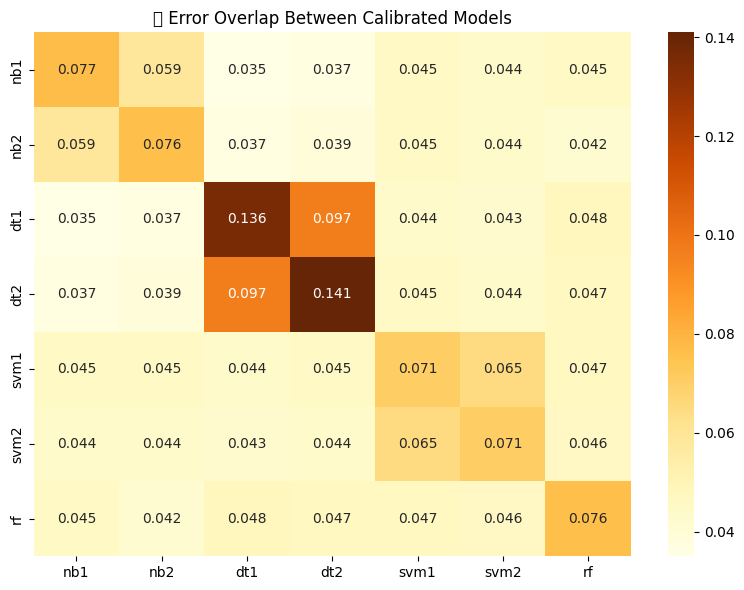

✅ Saved: models/calibrated/error_overlap_heatmap.png


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/calibrated/calibrated_predictions.csv"
OUT_IMG = "models/calibrated/error_overlap_heatmap.png"

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(PRED_PATH)
y_true = df["true"]
model_cols = [col for col in df.columns if col != "true"]

# -------------------------------
# 🔁 Compute Pairwise Error Overlap
# -------------------------------
overlap_matrix = pd.DataFrame(index=model_cols, columns=model_cols)

for m1 in model_cols:
    for m2 in model_cols:
        e1 = df[m1] != y_true
        e2 = df[m2] != y_true
        overlap = (e1 & e2).sum()
        overlap_matrix.loc[m1, m2] = round(overlap / len(df), 3)

# -------------------------------
# 📊 Plot Heatmap
# -------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(overlap_matrix.astype(float), annot=True, cmap="YlOrBr", fmt=".3f")
plt.title("🔁 Error Overlap Between Calibrated Models")
plt.tight_layout()
plt.savefig(OUT_IMG, dpi=300)
plt.show()

print(f"✅ Saved: {OUT_IMG}")

✅ McNemar test results saved: models/calibrated/mcnemar_test_results.csv


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_2868/4093911048.py:70: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_2868/4093911048.py:71: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(OUT_PLOT, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


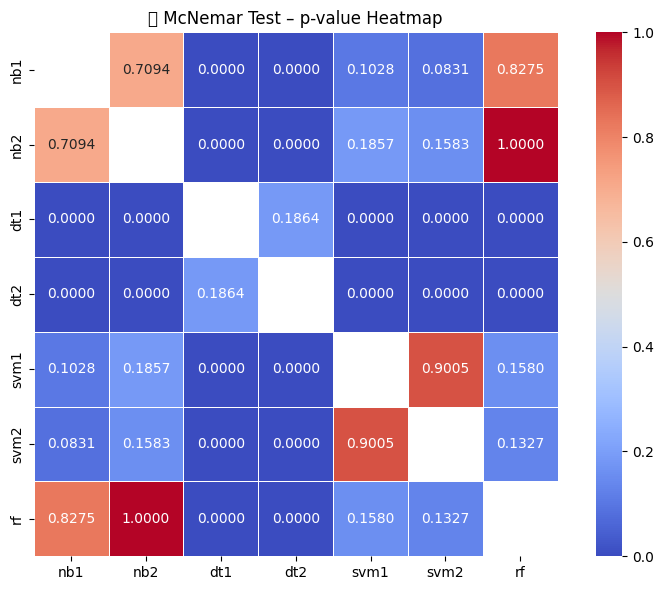

✅ p-value heatmap saved: models/calibrated/mcnemar_pvalue_heatmap.png


In [18]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.stats.contingency_tables import mcnemar

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/calibrated/calibrated_predictions.csv"
OUT_CSV = "models/calibrated/mcnemar_test_results.csv"
OUT_PLOT = "models/calibrated/mcnemar_pvalue_heatmap.png"

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(PRED_PATH)
y_true = df["true"]
model_cols = [col for col in df.columns if col != "true"]

# -------------------------------
# 🔁 McNemar Test + Matrix Init
# -------------------------------
results = []
pval_matrix = pd.DataFrame(index=model_cols, columns=model_cols, dtype=float)

for m1, m2 in combinations(model_cols, 2):
    pred1 = df[m1]
    pred2 = df[m2]

    both_wrong = ((pred1 != y_true) & (pred2 != y_true)).sum()
    only_m1_wrong = ((pred1 != y_true) & (pred2 == y_true)).sum()
    only_m2_wrong = ((pred2 != y_true) & (pred1 == y_true)).sum()

    table = [[0, only_m1_wrong],
             [only_m2_wrong, both_wrong]]

    result = mcnemar(table, exact=False, correction=True)
    pval = round(result.pvalue, 4)

    # Append results
    results.append({
        "Model A": m1,
        "Model B": m2,
        "Only A Wrong": only_m1_wrong,
        "Only B Wrong": only_m2_wrong,
        "Chi2": round(result.statistic, 4),
        "p-value": pval,
        "Significant (p<0.05)": pval < 0.05
    })

    # Fill both upper and lower for symmetric matrix
    pval_matrix.loc[m1, m2] = pval
    pval_matrix.loc[m2, m1] = pval

# -------------------------------
# 💾 Save CSV
# -------------------------------
df_out = pd.DataFrame(results)
df_out.to_csv(OUT_CSV, index=False)
print(f"✅ McNemar test results saved: {OUT_CSV}")

# -------------------------------
# 📊 Plot Heatmap
# -------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(pval_matrix.astype(float), annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5, square=True)
plt.title("🔍 McNemar Test – p-value Heatmap")
plt.tight_layout()
plt.savefig(OUT_PLOT, dpi=300)
plt.show()
print(f"✅ p-value heatmap saved: {OUT_PLOT}")

✅ F1 CI results saved: models/calibrated/f1_confidence_intervals.csv


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_2868/1639678584.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ci, x="Model", y="Width", palette="viridis")


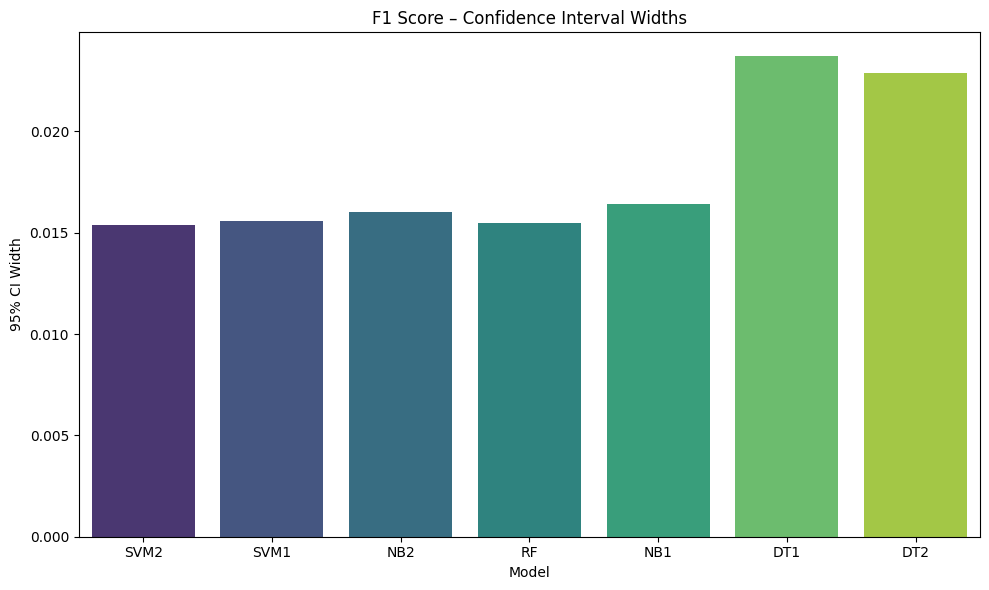

✅ Plot saved: models/calibrated/f1_ci_widths.png


In [19]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/calibrated/calibrated_predictions.csv"
OUT_CSV = "models/calibrated/f1_confidence_intervals.csv"
OUT_PLOT = "models/calibrated/f1_ci_widths.png"

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(PRED_PATH)
y_true = df["true"].values
model_cols = [col for col in df.columns if col != "true"]

# -------------------------------
# 🔁 Bootstrap F1 CI Computation
# -------------------------------
def bootstrap_ci(y_true, y_pred, n_iter=1000, seed=42):
    np.random.seed(seed)
    f1_scores = []
    for _ in range(n_iter):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        f1 = f1_score(y_true[idx], y_pred[idx])
        f1_scores.append(f1)
    lower = np.percentile(f1_scores, 2.5)
    upper = np.percentile(f1_scores, 97.5)
    return round(lower, 4), round(upper, 4), round(upper - lower, 4)

# -------------------------------
# 🔍 Loop Over Models
# -------------------------------
records = []

for model in model_cols:
    y_pred = df[model].values
    lower, upper, width = bootstrap_ci(y_true, y_pred)
    f1 = round(f1_score(y_true, y_pred), 4)
    records.append({
        "Model": model.upper(),
        "F1": f1,
        "Lower95": lower,
        "Upper95": upper,
        "Width": width
    })

# -------------------------------
# 💾 Save Results
# -------------------------------
df_ci = pd.DataFrame(records).sort_values("F1", ascending=False)
df_ci.to_csv(OUT_CSV, index=False)
print(f"✅ F1 CI results saved: {OUT_CSV}")

# -------------------------------
# 📊 Plot CI Widths
# -------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(data=df_ci, x="Model", y="Width", palette="viridis")
plt.ylabel("95% CI Width")
plt.title("F1 Score – Confidence Interval Widths")
plt.tight_layout()
plt.savefig(OUT_PLOT, dpi=300)
plt.show()
print(f"✅ Plot saved: {OUT_PLOT}")

✅ Saved: models/calibrated/f1_confidence_intervals.csv


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_2868/4156764830.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ci, x="Model", y="Width", palette="plasma")


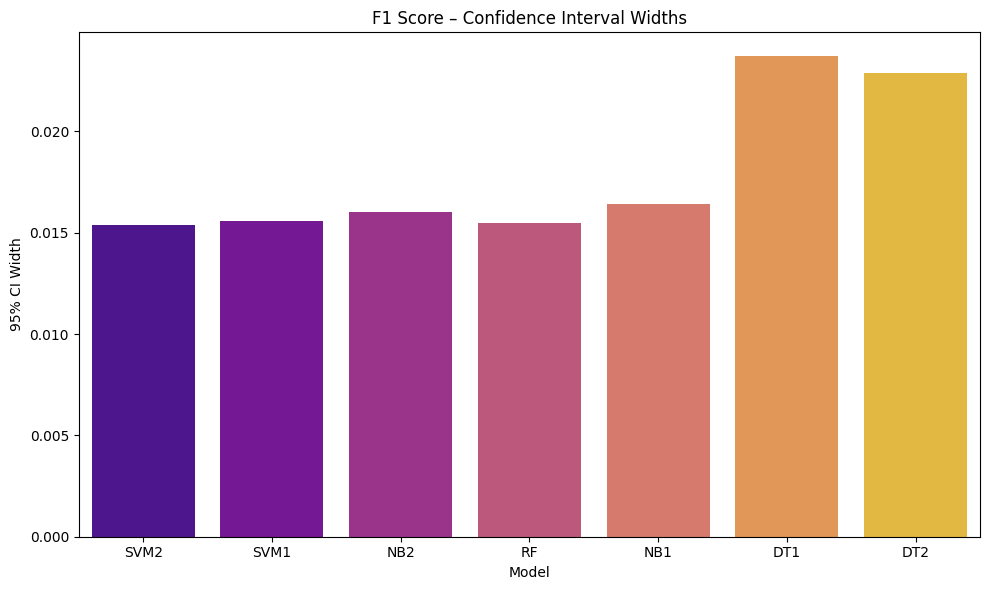

✅ Saved: models/calibrated/f1_ci_widths.png


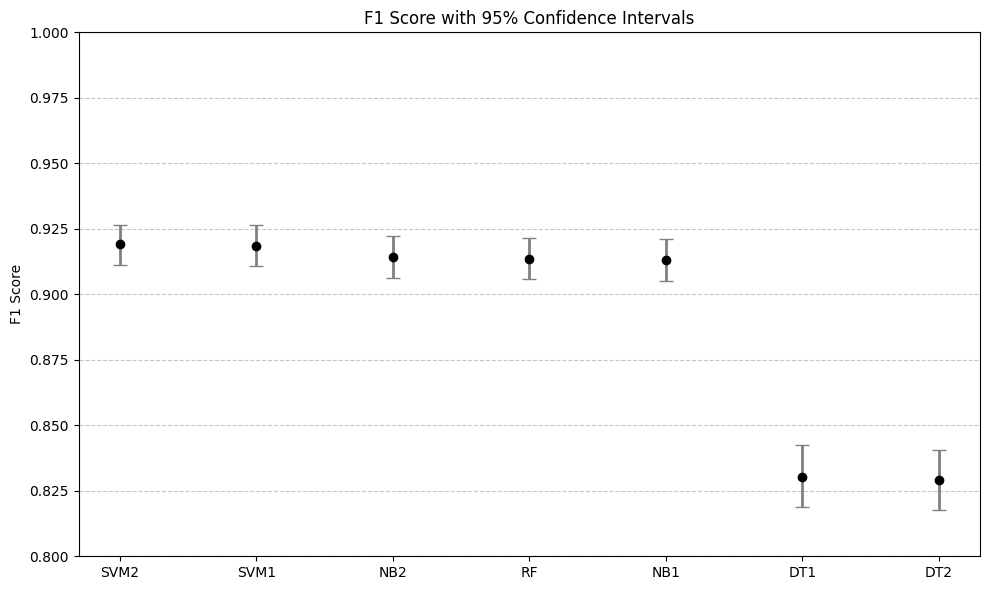

✅ Saved: models/calibrated/f1_ci_ranges.png


In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/calibrated/calibrated_predictions.csv"
OUT_CSV = "models/calibrated/f1_confidence_intervals.csv"
OUT_WIDTH_PLOT = "models/calibrated/f1_ci_widths.png"
OUT_RANGE_PLOT = "models/calibrated/f1_ci_ranges.png"

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(PRED_PATH)
y_true = df["true"].values
model_cols = [col for col in df.columns if col != "true"]

# -------------------------------
# 🔁 Bootstrap F1 CI Function
# -------------------------------
def bootstrap_ci(y_true, y_pred, n_iter=1000, seed=42):
    np.random.seed(seed)
    scores = []
    for _ in range(n_iter):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        scores.append(f1_score(y_true[idx], y_pred[idx]))
    lower, upper = np.percentile(scores, [2.5, 97.5])
    return round(lower, 4), round(upper, 4), round(upper - lower, 4)

# -------------------------------
# 📊 Collect CI Results
# -------------------------------
records = []

for model in model_cols:
    y_pred = df[model].values
    f1 = round(f1_score(y_true, y_pred), 4)
    lower, upper, width = bootstrap_ci(y_true, y_pred)
    records.append({
        "Model": model.upper(),
        "F1": f1,
        "Lower95": lower,
        "Upper95": upper,
        "Width": width
    })

df_ci = pd.DataFrame(records).sort_values("F1", ascending=False)
df_ci.to_csv(OUT_CSV, index=False)
print(f"✅ Saved: {OUT_CSV}")

# -------------------------------
# 📈 CI Width Plot
# -------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(data=df_ci, x="Model", y="Width", palette="plasma")
plt.ylabel("95% CI Width")
plt.title("F1 Score – Confidence Interval Widths")
plt.tight_layout()
plt.savefig(OUT_WIDTH_PLOT, dpi=300)
plt.show()
print(f"✅ Saved: {OUT_WIDTH_PLOT}")

# -------------------------------
# 📈 F1 ± CI Range Plot
# -------------------------------
plt.figure(figsize=(10, 6))
plt.errorbar(
    x=df_ci["Model"],
    y=df_ci["F1"],
    yerr=[df_ci["F1"] - df_ci["Lower95"], df_ci["Upper95"] - df_ci["F1"]],
    fmt="o", capsize=5, color="black", ecolor="gray", elinewidth=2
)
plt.ylim(0.8, 1.0)
plt.ylabel("F1 Score")
plt.title("F1 Score with 95% Confidence Intervals")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(OUT_RANGE_PLOT, dpi=300)
plt.show()
print(f"✅ Saved: {OUT_RANGE_PLOT}")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_2868/3455378445.py:88: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_2868/3455378445.py:89: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.savefig(PLOT_PATH, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


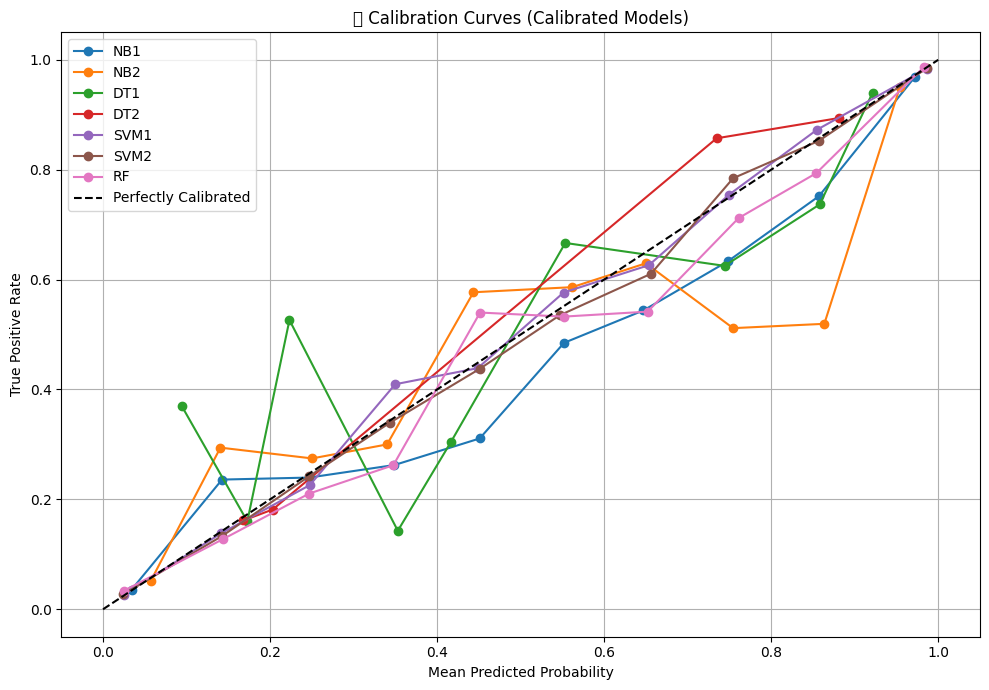

✅ Saved: models/calibrated/plots/calibration_curve_calibrated_only.png


In [24]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
DATA_PATH = "data/processed_test.csv"
PLOT_PATH = f"{CALIB_DIR}/plots/calibration_curve_calibrated_only.png"
os.makedirs(f"{CALIB_DIR}/plots", exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
df = pd.read_csv(DATA_PATH).dropna(subset=["clean_headline", "label_encoded"])
X_test = df["clean_headline"].astype(str)
y_test = df["label_encoded"]

# -------------------------------
# 🔧 Config for Calibrated Models
# -------------------------------
model_cfg = {
    "NB1": {
        "model": "nb1_calibrated.pkl",
        "vec": "nb_vectorizer_bigrams.pkl"
    },
    "NB2": {
        "model": "nb2_calibrated.pkl",
        "vec": ["nb_vectorizer_bichar_word.pkl", "nb_vectorizer_bichar_char.pkl"]
    },
    "DT1": {
        "model": "dt1_calibrated.pkl",
        "vec": "dt_vectorizer_bigrams.pkl"
    },
    "DT2": {
        "model": "dt2_calibrated.pkl",
        "vec": "dt_vectorizer_char.pkl"
    },
    "SVM1": {
        "model": "svm1_calibrated.pkl",
        "vec": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"]
    },
    "SVM2": {
        "model": "svm2_calibrated.pkl",
        "vec": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"]
    },
    "RF": {
        "model": "rf_calibrated.pkl",
        "vec": "rf_vectorizer.pkl"  # If saved elsewhere
    }
}

# -------------------------------
# 📊 Calibration Plot
# -------------------------------
plt.figure(figsize=(10, 7))

for name, cfg in model_cfg.items():
    # Load model
    model = joblib.load(f"{CALIB_DIR}/{cfg['model']}")

    # Vectorize input
    if isinstance(cfg["vec"], list):
        vec1 = joblib.load(f"{CALIB_DIR}/{cfg['vec'][0]}")
        vec2 = joblib.load(f"{CALIB_DIR}/{cfg['vec'][1]}")
        X_vec = hstack([vec1.transform(X_test), vec2.transform(X_test)])
    else:
        vec = joblib.load(f"{CALIB_DIR}/{cfg['vec']}")
        X_vec = vec.transform(X_test)

    # Predict probabilities
    y_prob = model.predict_proba(X_vec)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=name)

# Plot formatting
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.title("📏 Calibration Curves (Calibrated Models)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()
print(f"✅ Saved: {PLOT_PATH}")

🔍 Processing SVM2...
🔍 Processing NB2...
🔍 Processing RF...


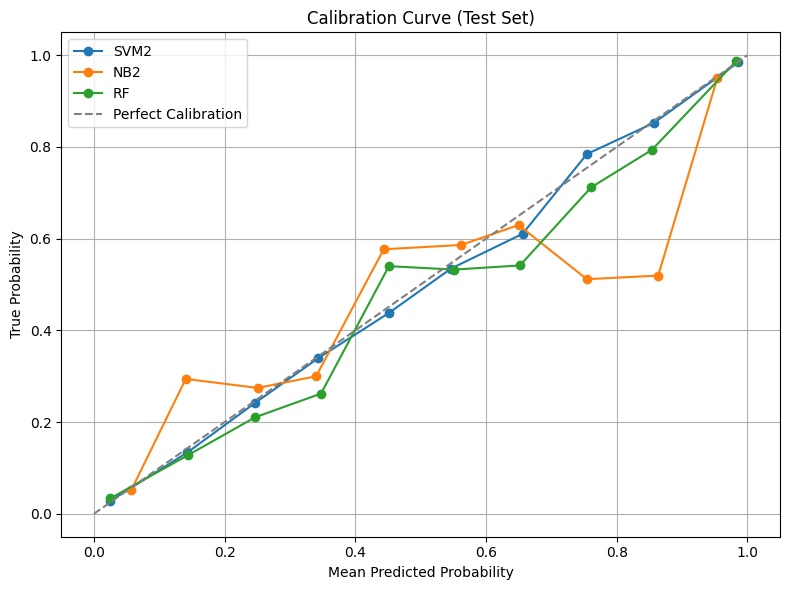

✅ Saved: calibration_curve_top3.png


In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import joblib
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
DATA_PATH = "data/processed_test.csv"
os.makedirs(f"{CALIB_DIR}/plots", exist_ok=True)

# -------------------------------
# 📦 Load Test Data
# -------------------------------
df = pd.read_csv(DATA_PATH).dropna(subset=["clean_headline", "label_encoded"])
X_test = df["clean_headline"].astype(str)
y_test = df["label_encoded"]

# -------------------------------
# 🔁 Model Configurations
# -------------------------------
model_configs = {
    "SVM2": {
        "model_path": f"{CALIB_DIR}/svm2_calibrated.pkl",
        "vec_word": f"{CALIB_DIR}/svm_vectorizer_word.pkl",
        "vec_char": f"{CALIB_DIR}/svm_vectorizer_char.pkl"
    },
    "NB2": {
        "model_path": f"{CALIB_DIR}/nb2_calibrated.pkl",
        "vec_word": f"{CALIB_DIR}/nb_vectorizer_bichar_word.pkl",
        "vec_char": f"{CALIB_DIR}/nb_vectorizer_bichar_char.pkl"
    },
    "RF": {
        "model_path": f"{CALIB_DIR}/rf_calibrated.pkl",
        "vec": f"{CALIB_DIR}/rf_vectorizer.pkl"
    }
}

# -------------------------------
# 📈 Plot Calibration Curves
# -------------------------------
plt.figure(figsize=(8, 6))

for name, cfg in model_configs.items():
    print(f"🔍 Processing {name}...")

    model = joblib.load(cfg["model_path"])

    if "vec" in cfg:  # RF (single vectorizer)
        vec = joblib.load(cfg["vec"])
        X_vec = vec.transform(X_test)
    else:  # SVM2, NB2 (BiChar)
        vec_word = joblib.load(cfg["vec_word"])
        vec_char = joblib.load(cfg["vec_char"])
        X_vec = hstack([vec_word.transform(X_test), vec_char.transform(X_test)])

    probas = model.predict_proba(X_vec)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, probas, n_bins=10, strategy='uniform')

    plt.plot(prob_pred, prob_true, marker='o', label=name)

# -------------------------------
# 🎨 Final Touches
# -------------------------------
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{CALIB_DIR}/plots/calibration_curve_top3.png", dpi=300)
plt.show()
print("✅ Saved: calibration_curve_top3.png")

🔍 Processing NB1...
🔍 Processing NB2...
🔍 Processing DT1...
🔍 Processing DT2...
🔍 Processing SVM1...
🔍 Processing SVM2...
🔍 Processing RF...


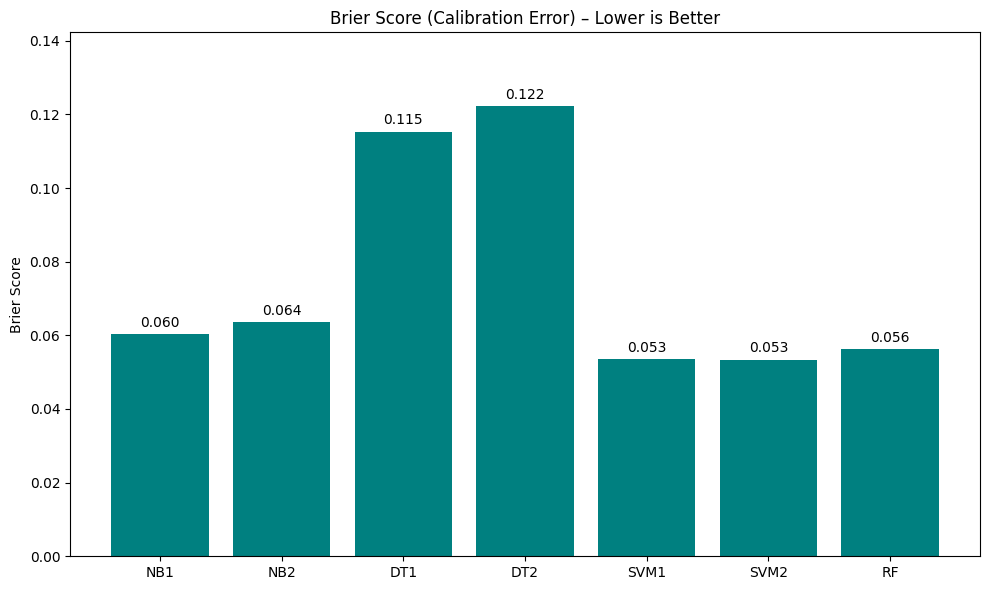

✅ Saved: models/calibrated/plots/brier_score_bar.png


In [26]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
DATA_PATH = "data/processed_test.csv"
PLOT_PATH = f"{CALIB_DIR}/plots/brier_score_bar.png"

# -------------------------------
# 📦 Load Test Data
# -------------------------------
df = pd.read_csv(DATA_PATH).dropna(subset=["clean_headline", "label_encoded"])
X_test = df["clean_headline"].astype(str)
y_test = df["label_encoded"]

# -------------------------------
# 🧠 Model Vectorizer Config
# -------------------------------
model_configs = {
    "NB1": {"model": "nb1_calibrated.pkl", "vec": "nb_vectorizer_bigrams.pkl"},
    "NB2": {"model": "nb2_calibrated.pkl", "vec": ["nb_vectorizer_bichar_word.pkl", "nb_vectorizer_bichar_char.pkl"]},
    "DT1": {"model": "dt1_calibrated.pkl", "vec": "dt_vectorizer_bigrams.pkl"},
    "DT2": {"model": "dt2_calibrated.pkl", "vec": "dt_vectorizer_char.pkl"},
    "SVM1": {"model": "svm1_calibrated.pkl", "vec": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"]},
    "SVM2": {"model": "svm2_calibrated.pkl", "vec": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"]},
    "RF": {"model": "rf_calibrated.pkl", "vec": "dt_vectorizer_bigrams.pkl"},
}

# -------------------------------
# 📊 Compute Brier Scores
# -------------------------------
from collections import OrderedDict
from sklearn.metrics import brier_score_loss

brier_scores = OrderedDict()

for name, config in model_configs.items():
    print(f"🔍 Processing {name}...")

    model = joblib.load(f"{CALIB_DIR}/{config['model']}")

    if isinstance(config["vec"], list):
        vec_word = joblib.load(f"{CALIB_DIR}/{config['vec'][0]}")
        vec_char = joblib.load(f"{CALIB_DIR}/{config['vec'][1]}")
        X_test_vec = hstack([vec_word.transform(X_test), vec_char.transform(X_test)])
    else:
        vec = joblib.load(f"{CALIB_DIR}/{config['vec']}")
        X_test_vec = vec.transform(X_test)

    prob_pos = model.predict_proba(X_test_vec)[:, 1]
    brier = brier_score_loss(y_test, prob_pos)
    brier_scores[name] = round(brier, 4)

# -------------------------------
# 📈 Plot Brier Score Bar Chart
# -------------------------------
plt.figure(figsize=(10, 6))
bars = plt.bar(brier_scores.keys(), brier_scores.values(), color="teal")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002, f"{height:.3f}", ha='center', fontsize=10)

plt.title("Brier Score (Calibration Error) – Lower is Better")
plt.ylabel("Brier Score")
plt.ylim(0, max(brier_scores.values()) + 0.02)
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()

print(f"✅ Saved: {PLOT_PATH}")

📊 Processing: SVM2
📊 Processing: NB2
📊 Processing: NB1
📊 Processing: RF


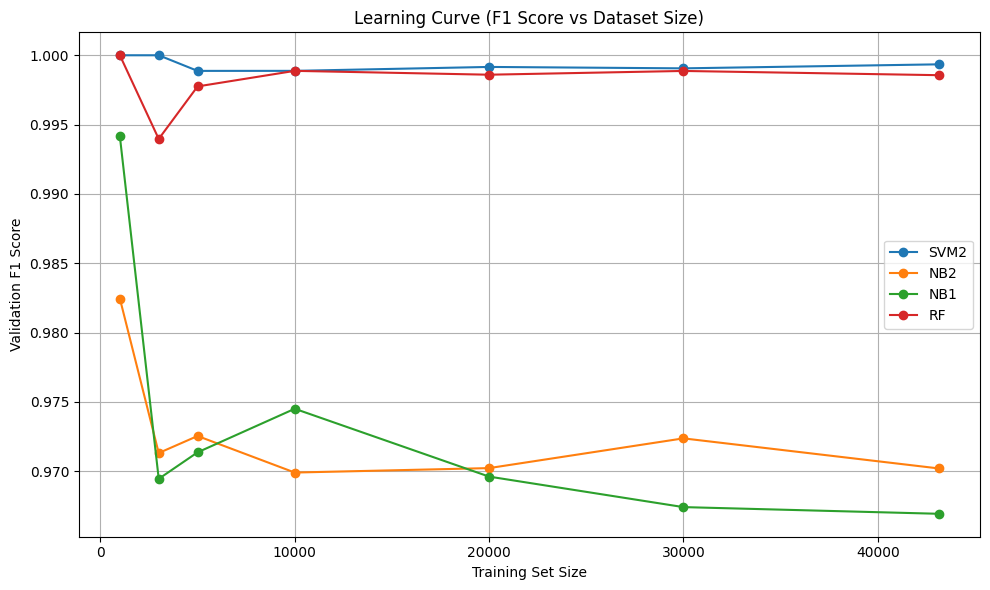

✅ Saved: models/calibrated/plots/learning_curve_f1.png


In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from scipy.sparse import hstack
import joblib

# -------------------------------
# 📂 Paths
# -------------------------------
DATA_PATH = "data/processed_train.csv"
PLOT_PATH = "models/calibrated/plots/learning_curve_f1.png"
CALIB_DIR = "models/calibrated"

# -------------------------------
# ⚙️ Model Config
# -------------------------------
model_info = {
    "SVM2": {
        "model": joblib.load(f"{CALIB_DIR}/svm2_calibrated.pkl"),
        "vec": [joblib.load(f"{CALIB_DIR}/svm_vectorizer_word.pkl"), joblib.load(f"{CALIB_DIR}/svm_vectorizer_char.pkl")],
        "type": "bichar"
    },
    "NB2": {
        "model": joblib.load(f"{CALIB_DIR}/nb2_calibrated.pkl"),
        "vec": [joblib.load(f"{CALIB_DIR}/nb_vectorizer_bichar_word.pkl"), joblib.load(f"{CALIB_DIR}/nb_vectorizer_bichar_char.pkl")],
        "type": "bichar"
    },
    "NB1": {
        "model": joblib.load(f"{CALIB_DIR}/nb1_calibrated.pkl"),
        "vec": joblib.load(f"{CALIB_DIR}/nb_vectorizer_bigrams.pkl"),
        "type": "single"
    },
    "RF": {
        "model": joblib.load(f"{CALIB_DIR}/rf_calibrated.pkl"),
        "vec": joblib.load(f"{CALIB_DIR}/rf_vectorizer.pkl"),
        "type": "single"
    }
}

# -------------------------------
# 📦 Load & Shuffle Data
# -------------------------------
df = pd.read_csv(DATA_PATH).dropna(subset=["clean_headline", "label_encoded"])
df = shuffle(df, random_state=42).reset_index(drop=True)
X_full = df["clean_headline"].astype(str)
y_full = df["label_encoded"]

# -------------------------------
# 📈 Plot Learning Curves
# -------------------------------
sizes = [1000, 3000, 5000, 10000, 20000, 30000, len(df)]
plt.figure(figsize=(10, 6))

for name, cfg in model_info.items():
    print(f"📊 Processing: {name}")
    f1_scores = []

    for size in sizes:
        X_subset = X_full[:size]
        y_subset = y_full[:size]

        X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

        if cfg["type"] == "bichar":
            vec_word, vec_char = cfg["vec"]
            X_train_vec = hstack([vec_word.transform(X_train), vec_char.transform(X_train)])
            X_val_vec = hstack([vec_word.transform(X_val), vec_char.transform(X_val)])
        else:
            vec = cfg["vec"]
            X_train_vec = vec.transform(X_train)
            X_val_vec = vec.transform(X_val)

        model = cfg["model"]
        y_pred = model.predict(X_val_vec)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)

    plt.plot(sizes, f1_scores, marker='o', label=name)

# -------------------------------
# 📊 Final Plot
# -------------------------------
plt.title("Learning Curve (F1 Score vs Dataset Size)")
plt.xlabel("Training Set Size")
plt.ylabel("Validation F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()

print(f"✅ Saved: {PLOT_PATH}")

📉 Processing SVM2...


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1

📉 Processing NB2...


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1

📉 Processing NB1...


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1

📉 Processing RF...


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1

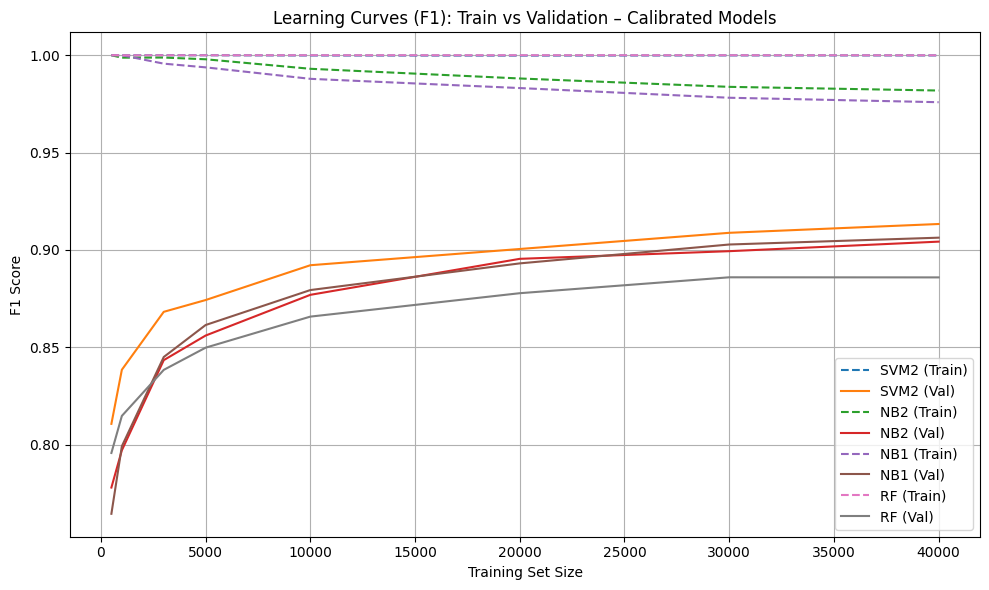

✅ Saved: models/calibrated/plots/learning_curve_f1_calibrated_only.png


In [30]:
import os
import pandas as pd
import numpy as np
import joblib
from scipy.sparse import hstack
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
SAVE_PATH = "models/calibrated/plots/learning_curve_f1_calibrated_only.png"
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
val_df = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline", "label_encoded"])
X_train_full = train_df["clean_headline"].astype(str).tolist()
y_train_full = train_df["label_encoded"].values
X_val = val_df["clean_headline"].astype(str).tolist()
y_val = val_df["label_encoded"].values

# -------------------------------
# ⚙️ Model Setup
# -------------------------------
model_config = {
    "SVM2": {
        "base": lambda: LinearSVC(C=1.0, loss="squared_hinge", max_iter=2000, random_state=42),
        "vecs": [f"{CALIB_DIR}/svm_vectorizer_word.pkl", f"{CALIB_DIR}/svm_vectorizer_char.pkl"]
    },
    "NB2": {
        "base": lambda: MultinomialNB(alpha=0.01),
        "vecs": [f"{CALIB_DIR}/nb_vectorizer_bichar_word.pkl", f"{CALIB_DIR}/nb_vectorizer_bichar_char.pkl"]
    },
    "NB1": {
        "base": lambda: MultinomialNB(alpha=0.1),
        "vecs": [f"{CALIB_DIR}/nb_vectorizer_bigrams.pkl"]
    },
    "RF": {
        "base": lambda: RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1),
        "vecs": [f"{CALIB_DIR}/nb_vectorizer_bigrams.pkl"]
    }
}

train_sizes = [500, 1000, 3000, 5000, 10000, 20000, 30000, 40000]

# -------------------------------
# 📈 Plot Learning Curves
# -------------------------------
plt.figure(figsize=(10, 6))

for model_name, cfg in model_config.items():
    print(f"📉 Processing {model_name}...")

    # Load vectorizer(s)
    if len(cfg["vecs"]) == 2:
        vec_word = joblib.load(cfg["vecs"][0])
        vec_char = joblib.load(cfg["vecs"][1])
        X_val_vec = hstack([vec_word.transform(X_val), vec_char.transform(X_val)])
        transform_fn = lambda X: hstack([vec_word.transform(X), vec_char.transform(X)])
    else:
        vec = joblib.load(cfg["vecs"][0])
        X_val_vec = vec.transform(X_val)
        transform_fn = lambda X: vec.transform(X)

    train_f1s, val_f1s = [], []

    for size in train_sizes:
        X_sub, y_sub = resample(X_train_full, y_train_full, n_samples=size, random_state=42)
        X_sub_vec = transform_fn(X_sub)

        # Refit & calibrate
        base_model = cfg["base"]()
        base_model.fit(X_sub_vec, y_sub)
        calibrated = CalibratedClassifierCV(base_model, method="sigmoid", cv="prefit")
        calibrated.fit(X_val_vec, y_val)

        train_pred = calibrated.predict(X_sub_vec)
        val_pred = calibrated.predict(X_val_vec)

        train_f1s.append(f1_score(y_sub, train_pred))
        val_f1s.append(f1_score(y_val, val_pred))

    plt.plot(train_sizes, train_f1s, linestyle="--", label=f"{model_name} (Train)")
    plt.plot(train_sizes, val_f1s, linestyle="-", label=f"{model_name} (Val)")

# -------------------------------
# 🎯 Finalize Plot
# -------------------------------
plt.title("Learning Curves (F1): Train vs Validation – Calibrated Models")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=300)
plt.show()
print(f"✅ Saved: {SAVE_PATH}")

📈 Model: SVM2


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1

📈 Model: NB2


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1

📈 Model: NB1


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1

📈 Model: RF


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1

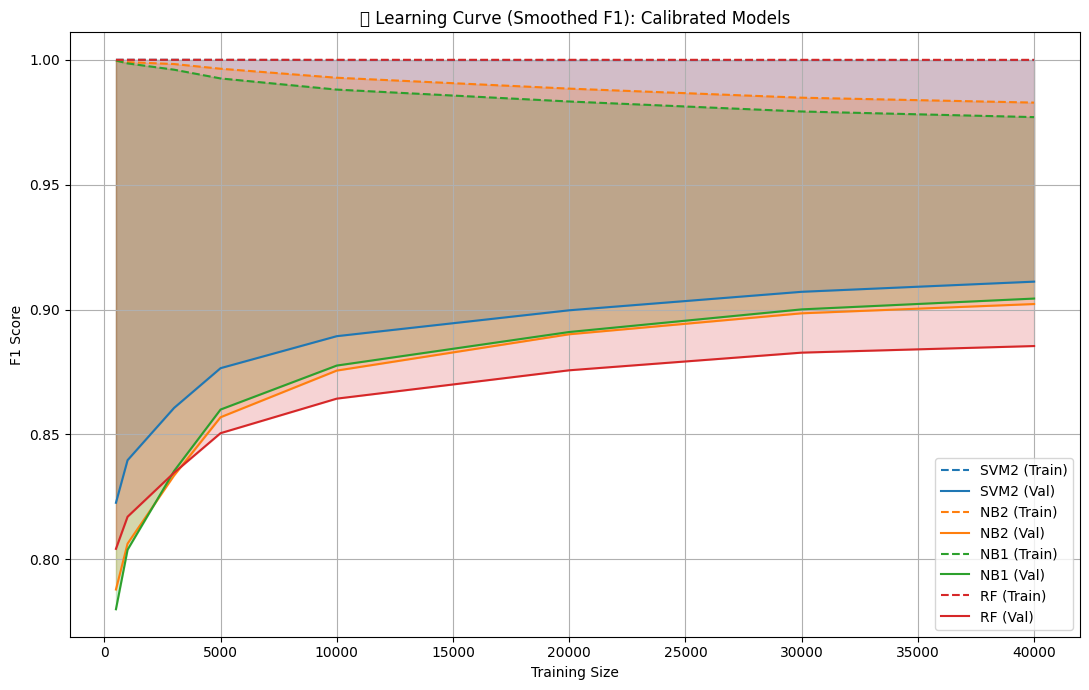

✅ Saved: models/calibrated/plots/learning_curve_combined_smoothed.png


In [34]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.utils import resample
from sklearn.metrics import f1_score
from scipy.ndimage import gaussian_filter1d
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
PLOT_PATH = f"{CALIB_DIR}/plots/learning_curve_combined_smoothed.png"
os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna()
val_df = pd.read_csv("data/processed_val.csv").dropna()
X_train_full = train_df["clean_headline"].astype(str).tolist()
y_train_full = train_df["label_encoded"].tolist()
X_val = val_df["clean_headline"].astype(str).tolist()
y_val = val_df["label_encoded"].tolist()

# -------------------------------
# ⚙️ Model + Vectorizer Config
# -------------------------------
model_config = {
    "SVM2": {
        "base": lambda: LinearSVC(C=1.0, loss="squared_hinge", max_iter=2000, random_state=42),
        "vecs": ["svm_vectorizer_word.pkl", "svm_vectorizer_char.pkl"],
        "color": "#1f77b4"
    },
    "NB2": {
        "base": lambda: MultinomialNB(alpha=0.01),
        "vecs": ["nb_vectorizer_bichar_word.pkl", "nb_vectorizer_bichar_char.pkl"],
        "color": "#ff7f0e"
    },
    "NB1": {
        "base": lambda: MultinomialNB(alpha=0.1),
        "vecs": ["nb_vectorizer_bigrams.pkl"],
        "color": "#2ca02c"
    },
    "RF": {
        "base": lambda: RandomForestClassifier(n_estimators=200, max_depth=None, n_jobs=-1, random_state=42),
        "vecs": ["rf_vectorizer.pkl"],
        "color": "#d62728"
    }
}

# -------------------------------
# 🔁 Learning Curve Parameters
# -------------------------------
sizes = [500, 1000, 3000, 5000, 10000, 20000, 30000, 40000]

plt.figure(figsize=(11, 7))

for name, cfg in model_config.items():
    print(f"📈 Model: {name}")

    # Load vectorizers
    if len(cfg["vecs"]) == 2:
        vec_word = joblib.load(os.path.join(CALIB_DIR, cfg["vecs"][0]))
        vec_char = joblib.load(os.path.join(CALIB_DIR, cfg["vecs"][1]))
        vec_train = lambda X: hstack([vec_word.transform(X), vec_char.transform(X)])
        X_val_vec = hstack([vec_word.transform(X_val), vec_char.transform(X_val)])
    else:
        vec = joblib.load(os.path.join(CALIB_DIR, cfg["vecs"][0]))
        vec_train = lambda X: vec.transform(X)
        X_val_vec = vec.transform(X_val)

    train_scores, val_scores = [], []

    for size in sizes:
        X_sub, y_sub = resample(X_train_full, y_train_full, n_samples=size, random_state=42)
        X_sub_vec = vec_train(X_sub)

        model = cfg["base"]()
        model.fit(X_sub_vec, y_sub)

        # Calibrate on full val set
        calibrated = CalibratedClassifierCV(model, method="sigmoid", cv="prefit")
        calibrated.fit(X_val_vec, y_val)

        train_pred = calibrated.predict(X_sub_vec)
        val_pred = calibrated.predict(X_val_vec)

        train_scores.append(f1_score(y_sub, train_pred))
        val_scores.append(f1_score(y_val, val_pred))

    # Smooth and plot
    smooth_train = gaussian_filter1d(train_scores, sigma=1)
    smooth_val = gaussian_filter1d(val_scores, sigma=1)
    color = cfg["color"]

    plt.plot(sizes, smooth_train, linestyle="--", color=color, label=f"{name} (Train)")
    plt.plot(sizes, smooth_val, linestyle="-", color=color, label=f"{name} (Val)")
    plt.fill_between(sizes, smooth_train, smooth_val, color=color, alpha=0.2)

# -------------------------------
# 📊 Final Plot
# -------------------------------
plt.title("📈 Learning Curve (Smoothed F1): Calibrated Models")
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()
print(f"✅ Saved: {PLOT_PATH}")

In [36]:
import os
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, roc_auc_score

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
os.makedirs(CALIB_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
val_df   = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline", "label_encoded"])
test_df  = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])

X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]
X_val   = val_df["clean_headline"].astype(str)
y_val   = val_df["label_encoded"]
X_test  = test_df["clean_headline"].astype(str)
y_test  = test_df["label_encoded"]

# -------------------------------
# 🔠 TF-IDF Bigrams Vectorizer
# -------------------------------
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
X_test_vec  = vectorizer.transform(X_test)
joblib.dump(vectorizer, f"{CALIB_DIR}/lr_vectorizer_bigrams.pkl")

# -------------------------------
# 🧠 Model + Calibration
# -------------------------------
lr_model = LogisticRegression(C=10.0, max_iter=1000, solver="liblinear")
lr_model.fit(X_train_vec, y_train)

calibrated_lr = CalibratedClassifierCV(estimator=lr_model, method="sigmoid", cv="prefit")
calibrated_lr.fit(X_val_vec, y_val)
joblib.dump(calibrated_lr, f"{CALIB_DIR}/lr_calibrated.pkl")

# -------------------------------
# 📈 Evaluate
# -------------------------------
y_pred = calibrated_lr.predict(X_test_vec)
y_prob = calibrated_lr.predict_proba(X_test_vec)[:, 1]
f1  = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"✅ Calibrated Logistic Regression:")
print(f"F1 Score: {f1:.4f}")
print(f"AUC:      {auc:.4f}")

✅ Calibrated Logistic Regression:
F1 Score: 0.9145
AUC:      0.9749


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [37]:
from sklearn.metrics import f1_score

# Predict on validation set
y_val_pred = calibrated_lr.predict(X_val_vec)
f1_val = f1_score(y_val, y_val_pred)

# Compare to test F1
gap = round(f1_val - f1, 4)
print(f"F1 (Val)  = {f1_val:.4f}")
print(f"F1 (Test) = {f1:.4f}")
print(f"Gap       = {gap:.4f}")

F1 (Val)  = 0.9219
F1 (Test) = 0.9145
Gap       = 0.0075


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_2868/4186529847.py:50: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_2868/4186529847.py:51: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{CALIB_DIR}/plots/lr_calibration_curve.png", dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


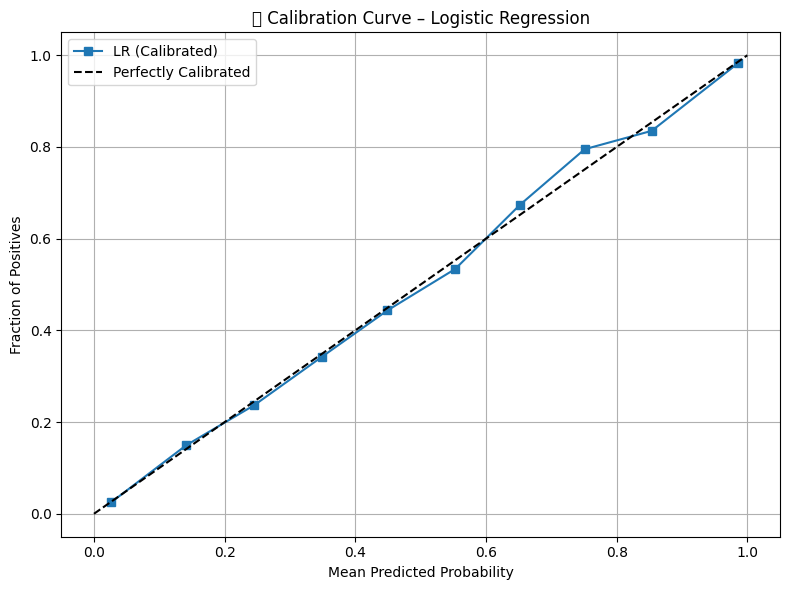

✅ Brier Score: 0.0565
✅ Saved: lr_calibration_curve.png and lr_brier_score.txt


In [39]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.feature_extraction.text import TfidfVectorizer

# -------------------------------
# 📂 Paths
# -------------------------------
CALIB_DIR = "models/calibrated"
os.makedirs(f"{CALIB_DIR}/plots", exist_ok=True)
os.makedirs(f"{CALIB_DIR}/results", exist_ok=True)

# -------------------------------
# 📦 Load Data and Model
# -------------------------------
df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])
X_test = df["clean_headline"].astype(str)
y_test = df["label_encoded"]

model = joblib.load(f"{CALIB_DIR}/lr_calibrated.pkl")
vec = joblib.load(f"{CALIB_DIR}/lr_vectorizer_bigrams.pkl")
X_test_vec = vec.transform(X_test)

# -------------------------------
# 📈 Calibration Curve + Brier Score
# -------------------------------
probs = model.predict_proba(X_test_vec)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, probs, n_bins=10)

brier_score = brier_score_loss(y_test, probs)

# Save Brier Score
with open(f"{CALIB_DIR}/results/lr_brier_score.txt", "w") as f:
    f.write(f"Brier Score (LR Calibrated): {brier_score:.4f}")

# -------------------------------
# 📊 Plot Calibration Curve
# -------------------------------
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="LR (Calibrated)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.title("🔍 Calibration Curve – Logistic Regression")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{CALIB_DIR}/plots/lr_calibration_curve.png", dpi=300)
plt.show()

print(f"✅ Brier Score: {brier_score:.4f}")
print("✅ Saved: lr_calibration_curve.png and lr_brier_score.txt")